# DLAI Autumn 2019 Project **TEAM 3**
Cai Badal, Gabriel Ferrater, Gerard Gallego & Oriol Sala

**Notebook created for the development of the exercises**


## 0. Project Initialization

### 0.1 Imports

In [0]:
import numpy as np

import copy
import torch
from torch import optim
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms, utils
from IPython.display import display
from PIL import Image
import pandas as pd
import numpy as np
import math

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})




### 0.2 System setup

In [0]:
# Random Seed
torch.manual_seed(1)
np.random.seed(1)

# Select the available device
device = 'cpu'
if torch.cuda.is_available():
  device = 'cuda'
  torch.cuda.manual_seed_all(1)

### 0.3 Data setup

#### 0.3.1 Loading MNIST dataset
We load the Train and Test datasets.

In [0]:
mnist_trainset = datasets.MNIST('data', train=True, download=True,
                                transform=transforms.ToTensor())

mnist_testset = datasets.MNIST('data', train=False, 
                               transform=transforms.ToTensor())

0it [00:00, ?it/s]

9920512it [00:02, 3831661.02it/s]                            


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 56618.16it/s]                           
0it [00:00, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


1654784it [00:01, 962258.17it/s]                             
0it [00:00, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


8192it [00:00, 21871.23it/s]            

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


#### 0.3.2 Train/Validation splits
We split the Train dataset into 95% for training and 5% for validation.

In [0]:
num_train = len(mnist_trainset)
indices = list(range(num_train))
split = int(np.floor(0.05 * num_train))
np.random.shuffle(indices)
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

### 0.4 Functions definition

####0.4.1 Train & Validation

In [0]:
# It helps not crashing when running the notebook the first time
ConvAutoencoder = None
ClassifierTL = None
ConvVarAutoencoder = None

In [0]:
def train_epoch(model, hparams, loader, optimizer, device, epoch):
    losses = []
    model.train()
    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        if type(model) == ConvAutoencoder:
            criterion = hparams['criterion']
            loss = criterion(output, data)
        elif type(model) == ClassifierTL:
            criterion = hparams['criterion']
            loss = criterion(output, target)   
        elif type(model) == ConvVarAutoencoder:
            output, mu, logvar = output
            loss = model.criterion(output, data, mu, logvar)
        else:
            raise Exception("You are using a module not implemented yet.")
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if batch_idx % hparams['log_interval'] == 0:
            dataset_len = len(loader) * hparams['batch_size']
            processed_data_len = batch_idx * hparams['batch_size']
            processed_data_len_str = format(processed_data_len, '0'+str(len(str(dataset_len))))
            processed_ratio = round((100. * batch_idx / len(loader)),0)
            loss_str = str(round(loss.item(),6))
            #print(f"Train Epoch: {epoch} [{processed_data_len_str}/{dataset_len} "+\
            #      f"({processed_ratio}%)]\tLoss: {loss_str}")
    return losses

In [0]:
def validate_epoch(model, hparams, loader, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            if type(model) == ConvAutoencoder:
                criterion = hparams['criterion']
                loss = criterion(output, data)
            elif type(model) == ClassifierTL:
                criterion = hparams['criterion']
                loss = criterion(output, target)   
            elif type(model) == ConvVarAutoencoder:
                output, mu, logvar = output
                loss = model.criterion(output, data, mu, logvar)
            else:
                raise Exception("You are using a module not implemented yet.")
            losses.append(loss.item())
    
    avg_loss = sum(losses) / len(losses)
    validation_loss_str = str(round(avg_loss,6))
    #print(f"\nValidation:\t\t\t\tLoss: {validation_loss_str} (avg.)\n\n")
    
    return avg_loss

In [0]:
def train(model, hparams, train_loader, valid_loader, optimizer, device):
    train_losses = []
    valid_losses = []
    valid_x = []
    for epoch in range(1, hparams['num_epochs'] + 1):
        epoch_train_losses = train_epoch(model, hparams, train_loader,
                                         optimizer, device, epoch)
        train_losses.extend(epoch_train_losses)
        epoch_valid_loss = validate_epoch(model, hparams, valid_loader, device)
        valid_losses.append(epoch_valid_loss)
        valid_x.append(len(train_losses) - 1)

    train_x = range(len(train_losses))

    return (train_x, train_losses), (valid_x, valid_losses)

####0.4.2 Results

In [0]:
def compute_avg_mse(model, loader):
    avg_mse = []
    for inputs, _ in iter(loader):
        outputs = model(inputs.to(device))
        outputs = outputs.detach().cpu().numpy()
        for input_, output in zip(inputs, outputs):
            mse = (np.square(input_.detach().cpu().numpy() - output)).mean(axis=None)
            avg_mse.append(mse)
    avg_mse = sum(avg_mse) / len(avg_mse)
    return avg_mse

In [0]:
def compute_avg_accuracy(model, loader):
    score = 0
    tests = 0
    for inputs, targets in iter(loader):
      outputs = model(inputs.to(device))
      outputs = outputs.detach().cpu().numpy()
      score += sum(targets.numpy() == np.argmax(outputs, axis=1))
      tests += len(outputs)

    avg_acc = score / tests
    return avg_acc

## 1. **Exercise 1** Convolutional Autoencoder
Train a convolutional autoencoder on MNIST, study the influence of the bottleneck size and generate some images.

### 1.1 Hyperparameters

In [0]:
hparams1 = {
    'num_epochs': 20,
    'batch_size': 256,
    'test_batch_size': 1024,
    'criterion': F.mse_loss,
    'learning_rate': 1e-3,
    'log_interval': 40,
}

### 1.2 Data loaders

In [0]:
train_loader = torch.utils.data.DataLoader(
    mnist_trainset,
    batch_size=hparams1['batch_size'], 
    sampler=train_sampler)
train_iter = iter(train_loader)

valid_loader = torch.utils.data.DataLoader(
    mnist_trainset,
    batch_size=hparams1['test_batch_size'], 
    sampler=valid_sampler)
valid_iter = iter(valid_loader)

test_loader = torch.utils.data.DataLoader(
    mnist_testset,
    batch_size=hparams1['test_batch_size'], 
    shuffle=False)
test_iter = iter(test_loader)

### 1.3 _Convolutional Autoencoder_

#### 1.3.1 Encoder

In [0]:
class Encoder(nn.Module):
    def __init__(self, output_size=20):
        super(Encoder, self).__init__()
        
        self.conv_layer1 = nn.Sequential(  
            nn.Conv2d(1, 6, 5, padding=2),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv_layer2 = nn.Sequential(  
            nn.Conv2d(6, 16, 5, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.mlp_layer1 = nn.Sequential(   
            nn.Linear(5*5*16, 200),
            nn.BatchNorm1d(200),
            nn.ReLU(),
        )
        self.mlp_layer2 = nn.Sequential( 
            nn.Linear(200, output_size),
            nn.BatchNorm1d(output_size),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x = x.view(-1, 16*5*5)
        x = self.mlp_layer1(x)
        out = self.mlp_layer2(x)
              
        return out

#### 1.3.2 Decoder

In [0]:
class Decoder(nn.Module):
    def __init__(self, input_size=20):
        super(Decoder, self).__init__()

        self.mlp_layer1 = nn.Sequential(
            nn.Linear(input_size, 200),
            nn.BatchNorm1d(200),
            nn.ReLU(),
        )
        self.mlp_layer2 = nn.Sequential(   
            nn.Linear(200, 400),
            nn.BatchNorm1d(400),
            nn.ReLU()
        )
        self.deconv_layer1 = nn.Sequential(
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.ConvTranspose2d(16, 6, 5, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
        )
        self.deconv_layer2 = nn.Sequential(
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.ConvTranspose2d(6, 1, 5, padding=2),
            nn.BatchNorm2d(1),
            nn.Sigmoid()                
        )

    def forward(self, x):
        x = self.mlp_layer1(x)
        x = self.mlp_layer2(x)
        x = x.view(-1,16,5,5)
        x = self.deconv_layer1(x)
        out = self.deconv_layer2(x)
              
        return out

#### 1.3.3 Autoencoder

In [0]:
class ConvAutoencoder(nn.Module):
    def __init__(self, bottleneck=20):
        super(ConvAutoencoder, self).__init__()
        self.encoder = Encoder(bottleneck)
        self.decoder = Decoder(bottleneck)
    
    def forward(self, x):
        x = self.encoder(x)
        out = self.decoder(x)

        return out

### 1.4 Training

In [0]:
bottlenecks = [1, 2, 6, 10, 16]

In [0]:
models_cae = dict.fromkeys(bottlenecks, None)
tr_losses = dict.fromkeys(bottlenecks, None)
val_losses = dict.fromkeys(bottlenecks, None)

for bn_size in bottlenecks:
    #print('\n'*3, '*'*10, f'Training with bottleneck size: {bn_size}',
    #      '*'*10, '\n')
    models_cae[bn_size] = ConvAutoencoder(bottleneck=bn_size).to(device)
    optimizer = optim.Adam(models_cae[bn_size].parameters(),
                           lr=hparams1['learning_rate'])
    tr_losses[bn_size], val_losses[bn_size] = train(models_cae[bn_size], hparams1,
                                                    train_loader, valid_loader,
                                                    optimizer, device)

### 1.5 Results

#### 1.5.1 Loss curves

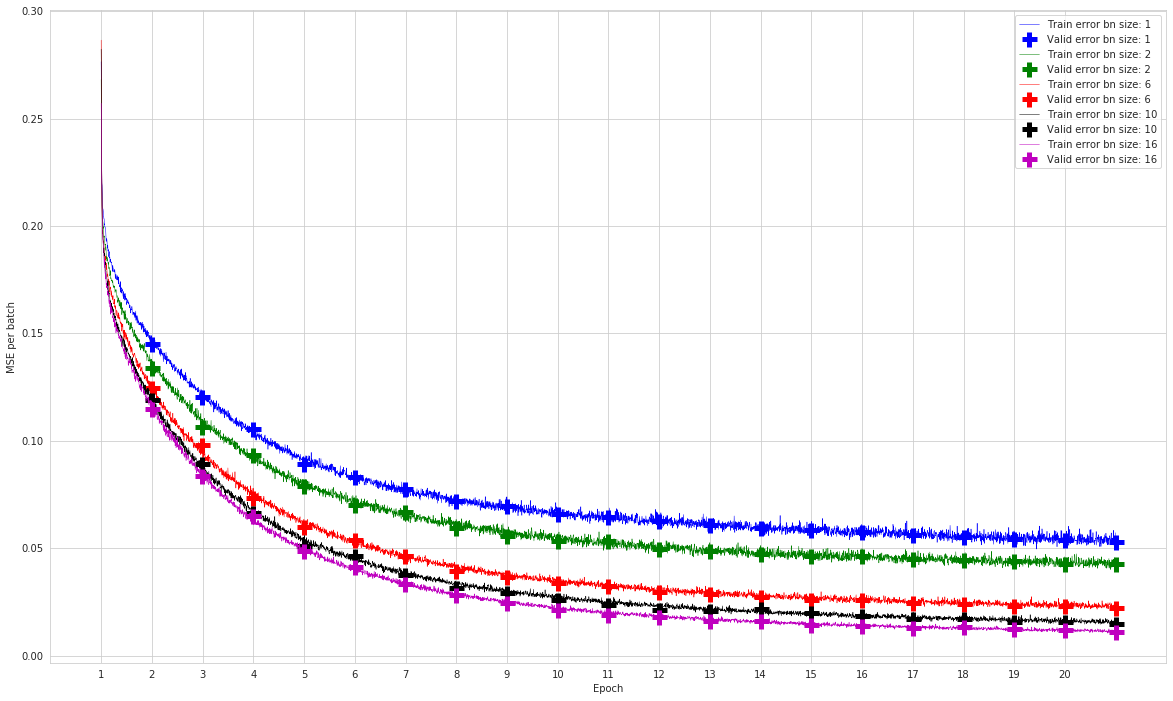

In [0]:
plt.figure(figsize=(20,12))
colors = "bgrkmycw"

for i, bn_size in enumerate(bottlenecks):
    plt.plot(tr_losses[bn_size][0], tr_losses[bn_size][1], '-', color=colors[i],
             lw=0.5, label=f'Train error bn size: {bn_size}')
    plt.plot(val_losses[bn_size][0], val_losses[bn_size][1], '+', color=colors[i],
             ms=15.0, mew=5.0, label=f'Valid error bn size: {bn_size}')

plt.xticks(np.arange(0, max(tr_losses[bn_size][0]),
                     step=max(tr_losses[bn_size][0])/hparams1['num_epochs']), 
                     [i + 1 for i in range(hparams1['num_epochs'])])
plt.xlabel('Epoch')
plt.ylabel('MSE per batch')
plt.grid(True)
plt.legend()
plt.show()

#### 1.5.2 Image reconstruction average error

In [0]:
df_ex1 = pd.DataFrame()
for bn_size, model in models_cae.items():  
    df_ex1.loc[bn_size, 'mse'] = compute_avg_mse(model, valid_loader)
    df_ex1.loc[bn_size, 'trainable_params'] = int(sum(p.numel() for p in models_cae[bn_size].parameters() if p.requires_grad))
    
display(df_ex1)

mse  trainable_params
1   0.053094          167990.0
2   0.042841          168393.0
6   0.022206          170005.0
10  0.014978          171617.0
16  0.010937          174035.0

#### 1.5.3 Image reconstruction w/ test input & bottleneck size = 16

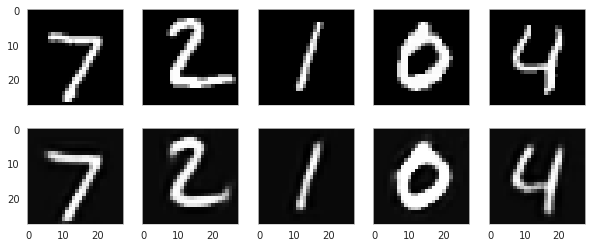

In [0]:
num_images = 5
bottleneck_size = 16
model = models_cae[bottleneck_size]

inputs, targets = test_iter.next()
inputs = inputs[:num_images]
outputs = model(inputs.to(device))
outputs = outputs.detach().cpu().numpy()

fig, axes = plt.subplots(nrows=2, ncols=num_images,
                          sharex=True, sharey=True, figsize=(10,4))
for i in range(num_images):
    axes[0][i].imshow(np.squeeze(inputs[i]), cmap='gray')
    axes[1][i].imshow(np.squeeze(outputs[i]), cmap='gray')

fig.show()

#### 1.5.4 Image reconstruction w/ random latent vector & bottleneck size = 16

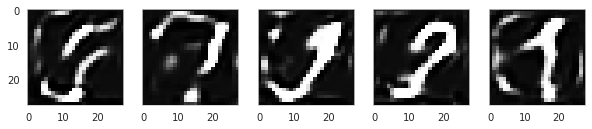

In [0]:
num_images = 5
bottleneck_size = 16
model = models_cae[bottleneck_size]

latent = torch.randn(num_images,bottleneck_size)
outputs = model.decoder(latent.to(device))
outputs = outputs.detach().cpu().numpy()

fig, axes = plt.subplots(nrows=1, ncols=num_images,
                          sharex=True, sharey=True, figsize=(10,4))
for i in range(num_images):
    axes[i].imshow(np.squeeze(outputs[i]), cmap='gray')

fig.show()

## 2. **Exercise 2** Transfer learning
Reuse autoencoder weights for pre-training and fine-tuning of a classifier trained on a small labeled subset of MNIST.

### 2.1 Hyperparameters

In [0]:
hparams2 = {
    'num_epochs': 250,
    'batch_size': 10,
    'test_batch_size': 256,
    'criterion': F.nll_loss,
    'learning_rate': 1e-3,
    'num_classes': 10,
    'log_interval': 2,
}

### 2.2 Data loaders

In [0]:
train100_sampler = SubsetRandomSampler(train_idx[:100])
train100_loader = torch.utils.data.DataLoader(
    mnist_trainset,
    batch_size=hparams2['batch_size'], 
    sampler=train100_sampler)
train100_iter = iter(train100_loader)

### 2.3 _Classifier_

In [0]:
class ClassifierTL(nn.Module):
    def __init__(self, encoder, hparams):
        super(ClassifierTL, self).__init__()
        self.encoder = encoder
        encoder_out_size = [p for p in self.encoder.parameters()][-1].shape[0]
        self.mlp = nn.Sequential(   
            nn.Linear(encoder_out_size, hparams['num_classes']),
            nn.BatchNorm1d(hparams['num_classes']),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        out = self.mlp(x)
              
        return out

### 2.4 Training

In [0]:
clf_types = ['last_layer', 'finetuning', 'scratch']

models_clf = dict.fromkeys(clf_types, None)
tr_losses = dict.fromkeys(clf_types, None)
val_losses = dict.fromkeys(clf_types, None)

#### 2.4.1 Loading/training Autoencoder

In [0]:
bn_size = 16

try:
    model_cae = models_cae[bn_size]
    
except NameError:
    model_cae = ConvAutoencoder(bottleneck=bn_size).to(device)
    optimizer = optim.Adam(model_cae.parameters(),
                            lr=hparams1['learning_rate'])
    tr_losses, val_losses = train(model_cae, hparams1,
                                  train_loader, valid_loader,
                                  optimizer, device)

#### 2.4.2 Training only last layer
We have freezed the encoding layers trained by the Autoencoder and we have only trained the last classification layer.

In [0]:
convEncoder = copy.deepcopy(model_cae.encoder)
for param in convEncoder.parameters():
    param.requires_grad = False

models_clf['last_layer'] = ClassifierTL(convEncoder, hparams2).to(device)
optimizer = optim.Adam(models_clf['last_layer'].parameters(),
                       lr=hparams2['learning_rate'])
tr_losses['last_layer'], val_losses['last_layer'] = train(models_clf['last_layer'],
                                                          hparams2, train100_loader,
                                                          valid_loader, optimizer,
                                                          device)

#### 2.4.4 Training with fine-tuning
We have trained the whole model but adjusting a learning rate x100 lower for the encoder trained by the Autoencoder.

In [0]:
convEncoder = copy.deepcopy(model_cae.encoder)
models_clf['finetuning'] = ClassifierTL(convEncoder, hparams2).to(device)


optimizer = optim.Adam([{'params': models_clf['finetuning'].encoder.parameters(),
                         'lr': hparams2['learning_rate']/5},
                        {'params': models_clf['finetuning'].mlp.parameters(),
                         'lr': hparams2['learning_rate']}
                        ])

tr_losses['finetuning'], val_losses['finetuning'] = train(models_clf['finetuning'],
                                                          hparams2, train100_loader,
                                                          valid_loader, optimizer,
                                                          device)

#### 2.4.5 Training from scratch
We have used the structure of the encoder from the Autoencoder, but we have reinitilized the weights.

In [0]:
model_cae_empty = ConvAutoencoder(bottleneck=bn_size).to(device)
models_clf['scratch'] = ClassifierTL(model_cae_empty.encoder, hparams2).to(device)
optimizer = optim.Adam(models_clf['scratch'].parameters(),
                       lr=hparams2['learning_rate'])
tr_losses['scratch'], val_losses['scratch'] = train(models_clf['scratch'], hparams2,
                                                    train100_loader, valid_loader,
                                                    optimizer, device)

### 2.5 Results

#### 2.5.1 Loss curves

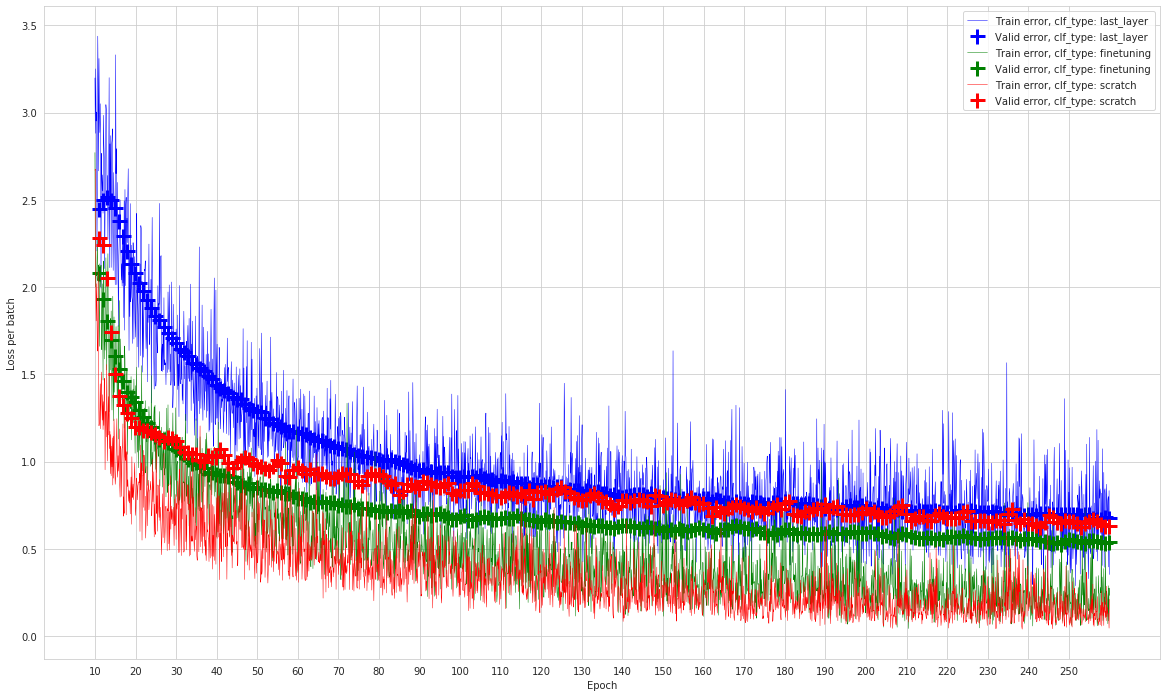

In [0]:
plt.figure(figsize=(20,12))
colors = "bgrkmycw"

for i, clf_type in enumerate(clf_types):
    plt.plot(tr_losses[clf_type][0], tr_losses[clf_type][1],
             '-', lw=0.5, label=f'Train error, clf_type: {clf_type}', color=colors[i])
    plt.plot(val_losses[clf_type][0], val_losses[clf_type][1],
             '+', ms=15.0, mew=3.0, label=f'Valid error, clf_type: {clf_type}', color=colors[i])
plt.xticks(np.arange(0, max(tr_losses[clf_type][0]),
                     step=10*max(tr_losses[clf_type][0])/hparams2['num_epochs']), 
                     [10*(i+1) for i in range(hparams2['num_epochs'])])
plt.xlabel('Epoch')
plt.ylabel('Loss per batch')
plt.grid(True)
plt.legend()
plt.show()

#### 2.5.2 Accuracies

In [0]:
df_ex2 = pd.DataFrame()
for k, model_clf in models_clf.items():  
    df_ex2.loc[k, 'accuracy'] = compute_avg_accuracy(model_clf, test_loader)
    df_ex2.loc[k, 'trainable_params'] = int(sum(p.numel() for p in model_clf.parameters() if p.requires_grad))

display(df_ex2)

accuracy  trainable_params
last_layer    0.8436             190.0
finetuning    0.8780           86654.0
scratch       0.8587           86654.0

## 3. **Exercise A** Convolutional Variational Autoencoder
Turn the autoencoder from Exercise 1 into a variational autoencoder.

### 3.1 Hyperparameters

In [0]:
hparams3 = {
    'num_epochs': 40,
    'batch_size': 256,
    'test_batch_size': 1024,
    'learning_rate': 1e-3,
    'bottleneck_size': 16,
    'num_z': 15,
    'log_interval': 40,
}

### 3.2 Data loaders

In [0]:
train_loader = torch.utils.data.DataLoader(
    mnist_trainset,
    batch_size=hparams3['batch_size'], 
    sampler=train_sampler)
train_iter = iter(train_loader)

valid_loader = torch.utils.data.DataLoader(
    mnist_trainset,
    batch_size=hparams3['test_batch_size'], 
    sampler=valid_sampler)
valid_iter = iter(valid_loader)

test_loader = torch.utils.data.DataLoader(
    mnist_testset,
    batch_size=hparams3['test_batch_size'], 
    shuffle=False)
test_iter = iter(test_loader)

### 3.3 _Convolutional Variational Autoencoder_

In [0]:
class VarEncoder(Encoder):
    def __init__(self, output_size=20):
        super(VarEncoder, self).__init__(output_size)
        self.mlp_layer21 = copy.deepcopy(self.mlp_layer2)
        self.mlp_layer22 = copy.deepcopy(self.mlp_layer2)
    def forward(self, x):
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x = x.view(-1, 16*5*5)
        x = self.mlp_layer1(x)
        mu = self.mlp_layer21(x)
        logvar = self.mlp_layer22(x)

        return mu, logvar

In [0]:
class ConvVarAutoencoder(ConvAutoencoder):
    def __init__(self, bottleneck=20, num_z=10):
        super(ConvVarAutoencoder, self).__init__(bottleneck)
        self.encoder = VarEncoder(bottleneck)
        self.bottleneck = bottleneck
        self.num_z = num_z

    def reparametrize(self, mu, logvar):
        if self.training:
            z = []
            for i in range(self.num_z):
                std = logvar.mul(0.5).exp_()
                eps = Variable(std.data.new(std.size()).normal_())
                z.append(eps.mul(std).add_(mu))
            return z
        else:
            return mu

    def criterion(self, y, x, mu, logvar):
        if self.training:
            BCE = 0
            for y_i in y:
                BCE += F.binary_cross_entropy(y_i, x)
            BCE /= len(y)
        else:
            BCE = F.binary_cross_entropy(y, x)

        # Kullback-Leibler divergence respect to N(0,1)
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        KLD /= int(x.view(-1).shape[0])

        return BCE + KLD
  
    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparametrize(mu, logvar)
        if self.training:
            return [self.decoder(z) for z in z], mu, logvar
        else:
            return self.decoder(z), mu, logvar

        return out, mu, logvar

###3.4 Training

In [0]:
model_cvae = ConvVarAutoencoder(bottleneck=hparams3['bottleneck_size'],
                                num_z=hparams3['num_z']).to(device)
optimizer = optim.Adam(model_cvae.parameters(),
                       lr=hparams3['learning_rate'])
tr_losses, val_losses = train(model_cvae, hparams3,
                              train_loader, valid_loader,
                              optimizer, device)

### 3.5 Results

#### 3.5.1 Loss curves

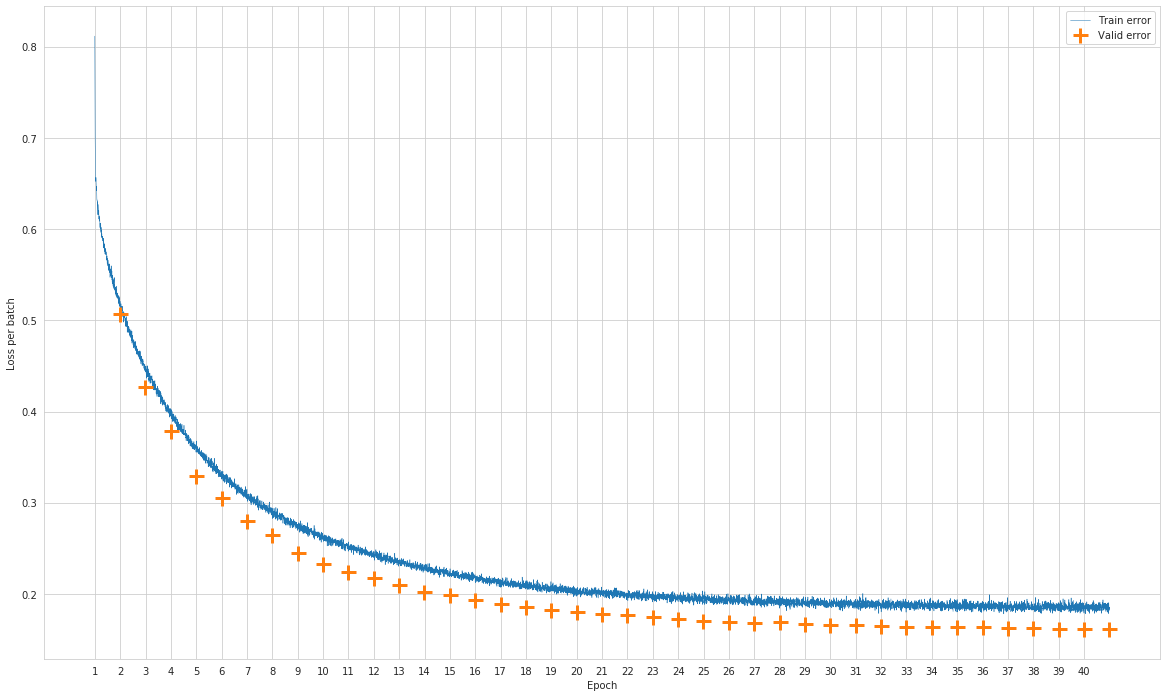

In [0]:
plt.figure(figsize=(20,12))

plt.plot(tr_losses[0], tr_losses[1],
          '-', lw=0.5, label=f'Train error')
plt.plot(val_losses[0], val_losses[1],
          '+', ms=15.0, mew=3.0, label=f'Valid error')

plt.xticks(np.arange(0, max(tr_losses[0]),
                     step=max(tr_losses[0])/hparams3['num_epochs']), 
                     [i + 1 for i in range(hparams3['num_epochs'])])
plt.xlabel('Epoch')
plt.ylabel('Loss per batch')
plt.grid(True)
plt.legend()
plt.show()

#### 3.5.3 Image reconstruction w/ test input & bottleneck size = 16

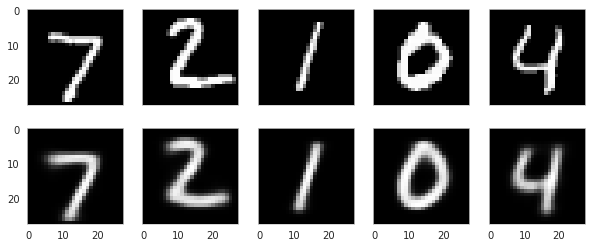

In [0]:
num_images = 5

inputs, targets = test_iter.next()
inputs = inputs[:num_images]
outputs = model_cvae(inputs.to(device))
outputs = outputs[0].detach().cpu().numpy()

fig, axes = plt.subplots(nrows=2, ncols=num_images,
                          sharex=True, sharey=True, figsize=(10,4))
for i in range(num_images):
    axes[0][i].imshow(np.squeeze(inputs[i]), cmap='gray')
    axes[1][i].imshow(np.squeeze(outputs[i]), cmap='gray')

fig.show()

#### 3.5.4 Image reconstruction w/ random latent vector & bottleneck size = 16

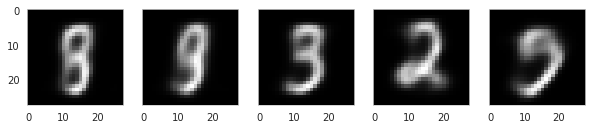

In [0]:
num_images = 5

latent = torch.randn(num_images, hparams3['bottleneck_size'])
outputs = model_cvae.decoder(latent.to(device))
outputs = outputs.detach().cpu().numpy()

fig, axes = plt.subplots(nrows=1, ncols=num_images,
                          sharex=True, sharey=True, figsize=(10,4))
for i in range(num_images):
    axes[i].imshow(np.squeeze(outputs[i]), cmap='gray')

fig.show()

## 4. **Exercise B** Conditional GAN
⚠️ For this exercise, we used as a starting point the code used in the lab about GANs. We did very few modifications on it, only the necessary to turn it conditional, so this is the reason why the coding style and the exercise structure is different from the previous exercises.

### 4.1 Utils

In [0]:
def norm_noise(size):
    return torch.cuda.FloatTensor(size, 100).normal_()
  
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('BatchNorm') != -1:
        m.weight.data.normal_(0.00, 0.02)
  
def display_batch_images(img, imtype=np.uint8, unnormalize=True, nrows=None, mean=0.5, std=0.5):
    # select a sample or create grid if img is a batch
    if len(img.shape) == 4:
        nrows = nrows if nrows is not None else int(math.sqrt(img.size(0)))
        img = utils.make_grid(img, nrow=nrows)

    # unnormalize
    img = img.cpu().float()
    img = (img*std+mean)*255

    # to numpy
    image_numpy = img.numpy()
    image_numpy = np.transpose(image_numpy, (1, 2, 0))
    display(Image.fromarray(image_numpy.astype(imtype))) 

### 4.2 Data
Yes, we are loading it again in order to modify the minimum the original GAN code.

In [0]:
def mnist():
    tf = transforms.Compose(
        [
            transforms.Resize(32, interpolation=0),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (.5,))
        ])
    return datasets.MNIST(root='./data/', train=True, transform=tf, download=True)

In [4]:
batch_size = 100
data_loader = torch.utils.data.DataLoader(mnist(), batch_size=batch_size, shuffle=True)

0it [00:00, ?it/s]

9920512it [00:01, 8740855.09it/s]                            


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 126994.07it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


1654784it [00:00, 2306617.41it/s]                           
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


8192it [00:00, 48333.95it/s]            

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


### 4.3 _Conditional GAN_

In [0]:
class Condition(torch.nn.Module):
    
    def __init__(self, out_shape):
        super(Condition, self).__init__()
        self.__out_shape = out_shape
        self.embedding = nn.Embedding(num_embeddings=10, embedding_dim=50)
        self.dense = nn.Linear(50, np.prod(out_shape))

    def forward(self, x):
        x = self.embedding(x)
        x = self.dense(x)
        out = x.view(-1, 1, self.__out_shape[0], self.__out_shape[1])
        return out

In [0]:
class Generator(torch.nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
      
        self._fc = torch.nn.Linear(100, 1024*4*4)

        self._conv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self._conv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=513, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self._conv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=1, kernel_size=4, stride=2, padding=1, bias=False),
            torch.nn.Tanh()
        )

        self.cond = Condition([8, 8])

    def forward(self, x, c):
        c = self.cond(c)
        # Noise to image
        x = self._fc(x)
        x = self._conv1(x.view(x.shape[0], 1024, 4, 4))
        x = torch.cat((x,c), dim=1)
        x = self._conv2(x)
        return self._conv3(x)

In [0]:
class Discriminator(torch.nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()

        self.cond = Condition([32, 32])

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=2, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(512*4*4, 1),
            nn.Sigmoid()
        )

    def forward(self, x, c):
        # Classify image as fake or real
        c = self.cond(c)
        x = torch.cat((x, c), dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return self.fc(x.view(-1, 512*4*4))

In [0]:
class Model:
    # --------------------------
    # -- PREPARE MODEL
    # --------------------------
    
    def __init__(self, batch_size):
        self._create_networks()
        self._create_optimizer()
        self._init_criterion(batch_size)
        
    def _create_networks(self):
        # create networks
        self._generator = Generator()
        self._discriminator = Discriminator()
        
        # init weights
        self._generator.apply(init_weights)
        self._discriminator.apply(init_weights)
        
        # move to cuda
        self._generator.cuda()
        self._discriminator.cuda()
        
    def _create_optimizer(self):
        # generator optimizer
        self._opt_g = torch.optim.Adam(self._generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        
        # discriminator optimizer
        self._opt_d = torch.optim.Adam(self._discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        
    def _init_criterion(self, batch_size):
        self._criterion = nn.BCELoss()
        self._label_real = Variable(torch.ones(batch_size, 1)).cuda()
        self._label_fake = Variable(torch.zeros(batch_size, 1)).cuda()
        
    # --------------------------
    # -- Generate Fake Samples
    # --------------------------
    
    def generate_samples(self, batch_size, z=None):
        # sample random noise
        if z is None:
            z = norm_noise(batch_size)
            
        # TODO: generate fake samples out of the random noise z
        fake_nums = torch.LongTensor(batch_size).random_(0, 10).cuda()
        fake_samples = self._generator(z, fake_nums)
        
        return fake_samples, fake_nums
    
    # --------------------------
    # -- Optimize Model
    # --------------------------
        
    def step_optimization(self, real_samples, real_nums):
        # generate fake samples
        fake_samples, fake_nums = self.generate_samples(real_samples.size(0))
        
        # optimize generator
        loss_g = self._step_opt_g(fake_samples, fake_nums)
        
        # optimize discriminator
        loss_d = self._step_opt_d(real_samples, real_nums, fake_samples.detach(), fake_nums.detach())
        
        return loss_g, loss_d
      
    def _step_opt_g(self, fake_samples, fake_nums):
        # Reset gradients
        self._opt_g.zero_grad()
        
        # TODO: Calculate generator loss
        estim_fake = self._discriminator(fake_samples, fake_nums)
        loss = self._criterion(estim_fake, self._label_real)
        loss.backward()
        
        # Update weights
        self._opt_g.step()
        
        return loss.item()
        
    def _step_opt_d(self, real_samples, real_nums, fake_samples, fake_nums):
        # Reset gradients
        self._opt_d.zero_grad()

        # TODO: Calculate discriminator loss for real samples
        estim_real = self._discriminator(real_samples, real_nums)
        loss_real = self._criterion(estim_real, self._label_real)

        # TODO: Calculate discriminator loss for fake samples
        estim_fake = self._discriminator(fake_samples, fake_nums)
        loss_fake = self._criterion(estim_fake, self._label_fake)
        
        # Total discriminator loss
        loss = (loss_real + loss_fake) / 2
        loss.backward()

        # Update weights
        self._opt_d.step()

        return loss_real.item(), loss_fake.item()

### 4.4 Training

In [0]:
num_epochs = 300
num_val_samples = 25
z_val = norm_noise(num_val_samples)
model = Model(batch_size)

epoch: 0/300, batch: 0/600, G_loss: 0.6974005699157715, D_loss: (0.6985620260238647, 0.6889351010322571)


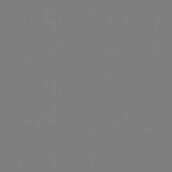

epoch: 0/300, batch: 10/600, G_loss: 0.864643931388855, D_loss: (0.5523638725280762, 0.5474880933761597)
epoch: 0/300, batch: 20/600, G_loss: 1.2440990209579468, D_loss: (0.3896052837371826, 0.3422485589981079)
epoch: 0/300, batch: 30/600, G_loss: 1.68645441532135, D_loss: (0.24894939363002777, 0.20752231776714325)
epoch: 0/300, batch: 40/600, G_loss: 2.0396957397460938, D_loss: (0.15359029173851013, 0.14540152251720428)
epoch: 0/300, batch: 50/600, G_loss: 2.4918298721313477, D_loss: (0.10023237019777298, 0.08962009102106094)
epoch: 0/300, batch: 60/600, G_loss: 2.8410511016845703, D_loss: (0.07398566603660583, 0.06294006109237671)
epoch: 0/300, batch: 70/600, G_loss: 3.047544479370117, D_loss: (0.048838600516319275, 0.05310475826263428)
epoch: 0/300, batch: 80/600, G_loss: 3.3968617916107178, D_loss: (0.15803617238998413, 0.035289790481328964)
epoch: 0/300, batch: 90/600, G_loss: 3.475583553314209, D_loss: (0.044131193310022354, 0.034584686160087585)
epoch: 0/300, batch: 100/600, G_l

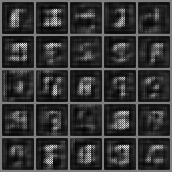

epoch: 0/300, batch: 110/600, G_loss: 4.43586540222168, D_loss: (3.0114591121673584, 0.012835493311285973)
epoch: 0/300, batch: 120/600, G_loss: 3.0204482078552246, D_loss: (0.04935162514448166, 0.054660309106111526)
epoch: 0/300, batch: 130/600, G_loss: 2.716740608215332, D_loss: (0.04629574716091156, 0.10482203215360641)
epoch: 0/300, batch: 140/600, G_loss: 1.3342580795288086, D_loss: (0.2546939253807068, 0.3792556822299957)
epoch: 0/300, batch: 150/600, G_loss: 2.753054618835449, D_loss: (0.09148748219013214, 0.09170405566692352)
epoch: 0/300, batch: 160/600, G_loss: 3.3549389839172363, D_loss: (0.05575849860906601, 0.04546261206269264)
epoch: 0/300, batch: 170/600, G_loss: 3.0861806869506836, D_loss: (0.06266745924949646, 0.07777301967144012)
epoch: 0/300, batch: 180/600, G_loss: 2.113603115081787, D_loss: (0.021348459646105766, 0.23590105772018433)
epoch: 0/300, batch: 190/600, G_loss: 1.164645791053772, D_loss: (0.5108979940414429, 0.4111744165420532)
epoch: 0/300, batch: 200/60

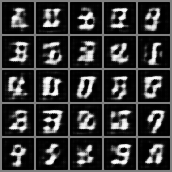

epoch: 0/300, batch: 210/600, G_loss: 2.795395851135254, D_loss: (0.2098264843225479, 0.08337095379829407)
epoch: 0/300, batch: 220/600, G_loss: 1.7085270881652832, D_loss: (0.054539769887924194, 0.2744545638561249)
epoch: 0/300, batch: 230/600, G_loss: 3.5162513256073, D_loss: (0.34024882316589355, 0.03926803916692734)
epoch: 0/300, batch: 240/600, G_loss: 1.9706084728240967, D_loss: (0.10556313395500183, 0.2215983271598816)
epoch: 0/300, batch: 250/600, G_loss: 0.3511180579662323, D_loss: (0.018816737458109856, 1.6492313146591187)
epoch: 0/300, batch: 260/600, G_loss: 2.326364278793335, D_loss: (0.23463904857635498, 0.16521358489990234)
epoch: 0/300, batch: 270/600, G_loss: 4.7242279052734375, D_loss: (2.2370245456695557, 0.011174377985298634)
epoch: 0/300, batch: 280/600, G_loss: 1.7466834783554077, D_loss: (0.19370731711387634, 0.2485424429178238)
epoch: 0/300, batch: 290/600, G_loss: 2.3739125728607178, D_loss: (0.27520713210105896, 0.14017131924629211)
epoch: 0/300, batch: 300/60

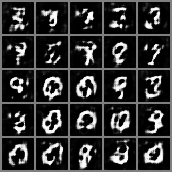

epoch: 0/300, batch: 310/600, G_loss: 1.2644963264465332, D_loss: (0.1048087477684021, 0.44337162375450134)
epoch: 0/300, batch: 320/600, G_loss: 2.1555161476135254, D_loss: (0.2577706575393677, 0.15722759068012238)
epoch: 0/300, batch: 330/600, G_loss: 3.8678903579711914, D_loss: (0.9785244464874268, 0.032159656286239624)
epoch: 0/300, batch: 340/600, G_loss: 1.6592934131622314, D_loss: (0.15059098601341248, 0.32051634788513184)
epoch: 0/300, batch: 350/600, G_loss: 0.3138136565685272, D_loss: (0.02893763966858387, 1.7189418077468872)
epoch: 0/300, batch: 360/600, G_loss: 2.350477695465088, D_loss: (0.33931446075439453, 0.13875891268253326)
epoch: 0/300, batch: 370/600, G_loss: 2.365767478942871, D_loss: (0.4566386938095093, 0.1352396011352539)
epoch: 0/300, batch: 380/600, G_loss: 3.188875675201416, D_loss: (0.8873516917228699, 0.06083914265036583)
epoch: 0/300, batch: 390/600, G_loss: 1.443661093711853, D_loss: (0.21840713918209076, 0.34049052000045776)
epoch: 0/300, batch: 400/600,

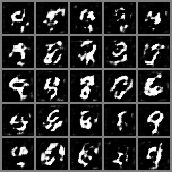

epoch: 0/300, batch: 410/600, G_loss: 1.8226956129074097, D_loss: (0.1887558400630951, 0.2340560406446457)
epoch: 0/300, batch: 420/600, G_loss: 2.933335542678833, D_loss: (0.6567734479904175, 0.07861151546239853)
epoch: 0/300, batch: 430/600, G_loss: 2.710158586502075, D_loss: (0.5428968667984009, 0.09028162807226181)
epoch: 0/300, batch: 440/600, G_loss: 1.580196738243103, D_loss: (0.17952869832515717, 0.30702847242355347)
epoch: 0/300, batch: 450/600, G_loss: 1.4247187376022339, D_loss: (0.1152237132191658, 0.39905688166618347)
epoch: 0/300, batch: 460/600, G_loss: 1.2879383563995361, D_loss: (0.17283466458320618, 0.4186919927597046)
epoch: 0/300, batch: 470/600, G_loss: 2.6312713623046875, D_loss: (0.6334044933319092, 0.12943187355995178)
epoch: 0/300, batch: 480/600, G_loss: 1.5266656875610352, D_loss: (0.1550503969192505, 0.31007716059684753)
epoch: 0/300, batch: 490/600, G_loss: 3.4410367012023926, D_loss: (0.9168006777763367, 0.05048340931534767)
epoch: 0/300, batch: 500/600, G

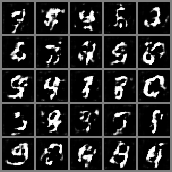

epoch: 0/300, batch: 510/600, G_loss: 1.8437445163726807, D_loss: (0.198471337556839, 0.2390967160463333)
epoch: 0/300, batch: 520/600, G_loss: 2.377676486968994, D_loss: (0.26514920592308044, 0.1382080465555191)
epoch: 0/300, batch: 530/600, G_loss: 3.339360237121582, D_loss: (0.5002478957176208, 0.05877074599266052)
epoch: 0/300, batch: 540/600, G_loss: 2.442864179611206, D_loss: (0.3358355462551117, 0.1537955105304718)
epoch: 0/300, batch: 550/600, G_loss: 3.6225507259368896, D_loss: (0.5477495193481445, 0.04227154329419136)
epoch: 0/300, batch: 560/600, G_loss: 1.5269172191619873, D_loss: (0.06852134317159653, 0.3530915081501007)
epoch: 0/300, batch: 570/600, G_loss: 1.6117756366729736, D_loss: (0.11600173264741898, 0.36952900886535645)
epoch: 0/300, batch: 580/600, G_loss: 2.822777032852173, D_loss: (0.20948833227157593, 0.09726797789335251)
epoch: 0/300, batch: 590/600, G_loss: 3.2612464427948, D_loss: (0.5295867323875427, 0.06240573897957802)
epoch: 1/300, batch: 0/600, G_loss: 

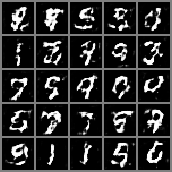

epoch: 1/300, batch: 10/600, G_loss: 3.3021504878997803, D_loss: (0.3042992949485779, 0.05909009277820587)
epoch: 1/300, batch: 20/600, G_loss: 1.4490885734558105, D_loss: (0.05885307863354683, 0.39238643646240234)
epoch: 1/300, batch: 30/600, G_loss: 2.4812257289886475, D_loss: (0.311012864112854, 0.1363196223974228)
epoch: 1/300, batch: 40/600, G_loss: 0.7631914615631104, D_loss: (0.01547847967594862, 0.9704594612121582)
epoch: 1/300, batch: 50/600, G_loss: 1.7281407117843628, D_loss: (0.10233593732118607, 0.2954097092151642)
epoch: 1/300, batch: 60/600, G_loss: 2.8779296875, D_loss: (0.18523624539375305, 0.09157707542181015)
epoch: 1/300, batch: 70/600, G_loss: 2.772109270095825, D_loss: (0.18487948179244995, 0.09823696315288544)
epoch: 1/300, batch: 80/600, G_loss: 2.942437171936035, D_loss: (0.15612690150737762, 0.08126718550920486)
epoch: 1/300, batch: 90/600, G_loss: 3.0748038291931152, D_loss: (0.5971553325653076, 0.07197833806276321)
epoch: 1/300, batch: 100/600, G_loss: 2.147

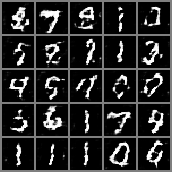

epoch: 1/300, batch: 110/600, G_loss: 0.7637672424316406, D_loss: (0.018490690737962723, 0.951002836227417)
epoch: 1/300, batch: 120/600, G_loss: 1.9736682176589966, D_loss: (0.06811191886663437, 0.22163228690624237)
epoch: 1/300, batch: 130/600, G_loss: 2.9164252281188965, D_loss: (0.14052852988243103, 0.07960163801908493)
epoch: 1/300, batch: 140/600, G_loss: 1.7727771997451782, D_loss: (0.042174383997917175, 0.31671392917633057)
epoch: 1/300, batch: 150/600, G_loss: 3.3602585792541504, D_loss: (0.16142727434635162, 0.057417336851358414)
epoch: 1/300, batch: 160/600, G_loss: 2.6708080768585205, D_loss: (0.26637253165245056, 0.11283597350120544)
epoch: 1/300, batch: 170/600, G_loss: 2.5793776512145996, D_loss: (0.051594194024801254, 0.13236457109451294)
epoch: 1/300, batch: 180/600, G_loss: 1.5957603454589844, D_loss: (0.033155594021081924, 0.39403071999549866)
epoch: 1/300, batch: 190/600, G_loss: 3.5918195247650146, D_loss: (0.23433822393417358, 0.04575281962752342)
epoch: 1/300, ba

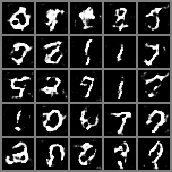

epoch: 1/300, batch: 210/600, G_loss: 2.1784310340881348, D_loss: (0.09704597294330597, 0.20367835462093353)
epoch: 1/300, batch: 220/600, G_loss: 2.4812188148498535, D_loss: (0.04321673884987831, 0.14671392738819122)
epoch: 1/300, batch: 230/600, G_loss: 2.855670213699341, D_loss: (0.040429696440696716, 0.08858693391084671)
epoch: 1/300, batch: 240/600, G_loss: 1.9513074159622192, D_loss: (0.12546013295650482, 0.43713024258613586)
epoch: 1/300, batch: 250/600, G_loss: 1.327682614326477, D_loss: (0.027008824050426483, 0.5914732217788696)
epoch: 1/300, batch: 260/600, G_loss: 2.33681321144104, D_loss: (0.06871762126684189, 0.14397156238555908)
epoch: 1/300, batch: 270/600, G_loss: 1.4934508800506592, D_loss: (0.02159578539431095, 0.4180314242839813)
epoch: 1/300, batch: 280/600, G_loss: 3.1812384128570557, D_loss: (0.15197820961475372, 0.0833636224269867)
epoch: 1/300, batch: 290/600, G_loss: 2.647205114364624, D_loss: (0.07219312340021133, 0.13357257843017578)
epoch: 1/300, batch: 300/

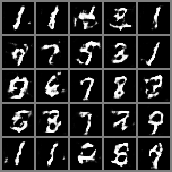

epoch: 1/300, batch: 310/600, G_loss: 1.0703994035720825, D_loss: (0.027539096772670746, 0.7925376296043396)
epoch: 1/300, batch: 320/600, G_loss: 2.17942476272583, D_loss: (0.15443052351474762, 0.21764647960662842)
epoch: 1/300, batch: 330/600, G_loss: 3.356118679046631, D_loss: (0.28195273876190186, 0.06502244621515274)
epoch: 1/300, batch: 340/600, G_loss: 1.0080963373184204, D_loss: (0.016904616728425026, 1.050571322441101)
epoch: 1/300, batch: 350/600, G_loss: 3.6024532318115234, D_loss: (0.1741005778312683, 0.044697489589452744)
epoch: 1/300, batch: 360/600, G_loss: 3.090466260910034, D_loss: (0.15207619965076447, 0.0768183171749115)
epoch: 1/300, batch: 370/600, G_loss: 2.71504282951355, D_loss: (0.11686235666275024, 0.12169723212718964)
epoch: 1/300, batch: 380/600, G_loss: 2.355674982070923, D_loss: (0.06915706396102905, 0.16317668557167053)
epoch: 1/300, batch: 390/600, G_loss: 1.718095302581787, D_loss: (0.04012677073478699, 0.28901880979537964)
epoch: 1/300, batch: 400/600,

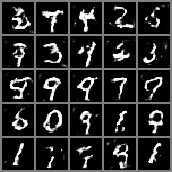

epoch: 1/300, batch: 410/600, G_loss: 2.498180627822876, D_loss: (0.030286431312561035, 0.14237327873706818)
epoch: 1/300, batch: 420/600, G_loss: 2.7054271697998047, D_loss: (0.03366944193840027, 0.11542270332574844)
epoch: 1/300, batch: 430/600, G_loss: 3.723628520965576, D_loss: (0.21495574712753296, 0.036660343408584595)
epoch: 1/300, batch: 440/600, G_loss: 6.774081230163574, D_loss: (1.2328885793685913, 0.0019206528086215258)
epoch: 1/300, batch: 450/600, G_loss: 3.7617480754852295, D_loss: (0.12667134404182434, 0.04835435375571251)
epoch: 1/300, batch: 460/600, G_loss: 2.0404443740844727, D_loss: (0.03639699146151543, 0.20036563277244568)
epoch: 1/300, batch: 470/600, G_loss: 2.263096809387207, D_loss: (0.13022619485855103, 0.1967049539089203)
epoch: 1/300, batch: 480/600, G_loss: 5.046111106872559, D_loss: (0.4460047781467438, 0.010790381580591202)
epoch: 1/300, batch: 490/600, G_loss: 4.501214504241943, D_loss: (0.20166125893592834, 0.022742116823792458)
epoch: 1/300, batch: 5

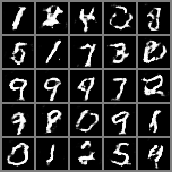

epoch: 1/300, batch: 510/600, G_loss: 4.804867267608643, D_loss: (0.7932990789413452, 0.023053806275129318)
epoch: 1/300, batch: 520/600, G_loss: 2.3992221355438232, D_loss: (0.1500198394060135, 0.15480946004390717)
epoch: 1/300, batch: 530/600, G_loss: 2.5039525032043457, D_loss: (0.042881641536951065, 0.14491061866283417)
epoch: 1/300, batch: 540/600, G_loss: 3.179337501525879, D_loss: (0.05229492112994194, 0.11218482255935669)
epoch: 1/300, batch: 550/600, G_loss: 2.4380452632904053, D_loss: (0.10935736447572708, 0.16642387211322784)
epoch: 1/300, batch: 560/600, G_loss: 2.538165330886841, D_loss: (0.016687456518411636, 0.1471146047115326)
epoch: 1/300, batch: 570/600, G_loss: 1.6614348888397217, D_loss: (0.04259417951107025, 0.37659552693367004)
epoch: 1/300, batch: 580/600, G_loss: 2.9208922386169434, D_loss: (0.3272629976272583, 0.0975852757692337)
epoch: 1/300, batch: 590/600, G_loss: 3.244738817214966, D_loss: (0.056817296892404556, 0.06580369174480438)
epoch: 2/300, batch: 0/6

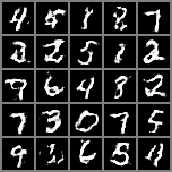

epoch: 2/300, batch: 10/600, G_loss: 3.4189038276672363, D_loss: (0.07442066073417664, 0.06112208962440491)
epoch: 2/300, batch: 20/600, G_loss: 1.726434350013733, D_loss: (0.02730313315987587, 0.3128446936607361)
epoch: 2/300, batch: 30/600, G_loss: 2.1495893001556396, D_loss: (0.0567825585603714, 0.18865403532981873)
epoch: 2/300, batch: 40/600, G_loss: 4.4774346351623535, D_loss: (0.37319493293762207, 0.024973494932055473)
epoch: 2/300, batch: 50/600, G_loss: 5.128507137298584, D_loss: (0.5405447483062744, 0.015398025512695312)
epoch: 2/300, batch: 60/600, G_loss: 2.5630075931549072, D_loss: (0.06354972720146179, 0.14079707860946655)
epoch: 2/300, batch: 70/600, G_loss: 2.673396587371826, D_loss: (0.10464790463447571, 0.1508435606956482)
epoch: 2/300, batch: 80/600, G_loss: 4.199629306793213, D_loss: (0.3812725841999054, 0.028479689732193947)
epoch: 2/300, batch: 90/600, G_loss: 2.2083263397216797, D_loss: (0.12750312685966492, 0.20467832684516907)
epoch: 2/300, batch: 100/600, G_lo

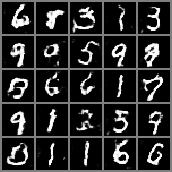

epoch: 2/300, batch: 110/600, G_loss: 1.7169896364212036, D_loss: (0.07015704363584518, 0.3249734938144684)
epoch: 2/300, batch: 120/600, G_loss: 1.336098313331604, D_loss: (0.048853062093257904, 0.5220078825950623)
epoch: 2/300, batch: 130/600, G_loss: 3.637195348739624, D_loss: (0.23280616104602814, 0.06609515845775604)
epoch: 2/300, batch: 140/600, G_loss: 1.041184902191162, D_loss: (0.010124867781996727, 0.7024198770523071)
epoch: 2/300, batch: 150/600, G_loss: 3.6731340885162354, D_loss: (0.2878706455230713, 0.054078955203294754)
epoch: 2/300, batch: 160/600, G_loss: 3.1890816688537598, D_loss: (0.11424215137958527, 0.07933280616998672)
epoch: 2/300, batch: 170/600, G_loss: 1.870447039604187, D_loss: (0.013742971234023571, 0.34483852982521057)
epoch: 2/300, batch: 180/600, G_loss: 2.4599459171295166, D_loss: (0.09281697869300842, 0.17379985749721527)
epoch: 2/300, batch: 190/600, G_loss: 2.4470391273498535, D_loss: (0.20744039118289948, 0.1694427877664566)
epoch: 2/300, batch: 200

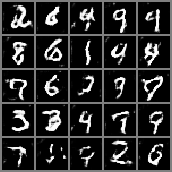

epoch: 2/300, batch: 210/600, G_loss: 3.3925604820251465, D_loss: (0.04654284939169884, 0.06248977780342102)
epoch: 2/300, batch: 220/600, G_loss: 3.8279671669006348, D_loss: (0.37344542145729065, 0.04608910530805588)
epoch: 2/300, batch: 230/600, G_loss: 6.640195369720459, D_loss: (1.604283094406128, 0.0033436939120292664)
epoch: 2/300, batch: 240/600, G_loss: 2.5163397789001465, D_loss: (0.032566629350185394, 0.17556212842464447)
epoch: 2/300, batch: 250/600, G_loss: 2.8387339115142822, D_loss: (0.07078856229782104, 0.0869639590382576)
epoch: 2/300, batch: 260/600, G_loss: 3.34804105758667, D_loss: (0.18769830465316772, 0.054695505648851395)
epoch: 2/300, batch: 270/600, G_loss: 1.9166498184204102, D_loss: (0.06263816356658936, 0.264176607131958)
epoch: 2/300, batch: 280/600, G_loss: 1.9759550094604492, D_loss: (0.02102675475180149, 0.27066949009895325)
epoch: 2/300, batch: 290/600, G_loss: 1.9644694328308105, D_loss: (0.17715775966644287, 0.2410477101802826)
epoch: 2/300, batch: 300

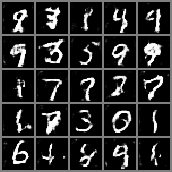

epoch: 2/300, batch: 310/600, G_loss: 2.5665323734283447, D_loss: (0.10106445103883743, 0.15254250168800354)
epoch: 2/300, batch: 320/600, G_loss: 2.8125200271606445, D_loss: (0.21962383389472961, 0.12320973724126816)
epoch: 2/300, batch: 330/600, G_loss: 2.5462520122528076, D_loss: (0.08092036843299866, 0.14908114075660706)
epoch: 2/300, batch: 340/600, G_loss: 3.456569194793701, D_loss: (0.20471526682376862, 0.065553218126297)
epoch: 2/300, batch: 350/600, G_loss: 2.8612701892852783, D_loss: (0.22380173206329346, 0.14501433074474335)
epoch: 2/300, batch: 360/600, G_loss: 3.3265624046325684, D_loss: (0.2443799525499344, 0.07061129063367844)
epoch: 2/300, batch: 370/600, G_loss: 3.426753520965576, D_loss: (0.10671140998601913, 0.06074538081884384)
epoch: 2/300, batch: 380/600, G_loss: 2.3243277072906494, D_loss: (0.09881093353033066, 0.21685592830181122)
epoch: 2/300, batch: 390/600, G_loss: 1.4566038846969604, D_loss: (0.027336642146110535, 0.46631428599357605)
epoch: 2/300, batch: 40

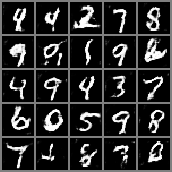

epoch: 2/300, batch: 410/600, G_loss: 1.0535802841186523, D_loss: (0.03162704408168793, 0.9600318670272827)
epoch: 2/300, batch: 420/600, G_loss: 5.246339797973633, D_loss: (1.0557059049606323, 0.020389201119542122)
epoch: 2/300, batch: 430/600, G_loss: 4.14816427230835, D_loss: (0.46445202827453613, 0.03208426386117935)
epoch: 2/300, batch: 440/600, G_loss: 1.6460957527160645, D_loss: (0.12258166074752808, 0.3177110254764557)
epoch: 2/300, batch: 450/600, G_loss: 2.0524942874908447, D_loss: (0.05653959885239601, 0.3955190181732178)
epoch: 2/300, batch: 460/600, G_loss: 1.3329778909683228, D_loss: (0.022458571940660477, 0.4842005670070648)
epoch: 2/300, batch: 470/600, G_loss: 1.9889914989471436, D_loss: (0.029430458322167397, 0.23524099588394165)
epoch: 2/300, batch: 480/600, G_loss: 2.4603757858276367, D_loss: (0.12136244773864746, 0.15058590471744537)
epoch: 2/300, batch: 490/600, G_loss: 3.5720767974853516, D_loss: (0.4583880603313446, 0.050414662808179855)
epoch: 2/300, batch: 500

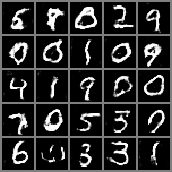

epoch: 2/300, batch: 510/600, G_loss: 2.108893632888794, D_loss: (0.06943672895431519, 0.18246114253997803)
epoch: 2/300, batch: 520/600, G_loss: 3.4999725818634033, D_loss: (0.16819335520267487, 0.05833248794078827)
epoch: 2/300, batch: 530/600, G_loss: 3.4147818088531494, D_loss: (0.40169525146484375, 0.06559638679027557)
epoch: 2/300, batch: 540/600, G_loss: 2.194761276245117, D_loss: (0.10096506029367447, 0.19123628735542297)
epoch: 2/300, batch: 550/600, G_loss: 2.009331464767456, D_loss: (0.1389796882867813, 0.29667189717292786)
epoch: 2/300, batch: 560/600, G_loss: 2.5123491287231445, D_loss: (0.09874698519706726, 0.13987818360328674)
epoch: 2/300, batch: 570/600, G_loss: 3.3268518447875977, D_loss: (0.42210501432418823, 0.10009145736694336)
epoch: 2/300, batch: 580/600, G_loss: 3.2663774490356445, D_loss: (0.36625221371650696, 0.0665784552693367)
epoch: 2/300, batch: 590/600, G_loss: 2.613180637359619, D_loss: (0.16882473230361938, 0.1271461546421051)
epoch: 3/300, batch: 0/600

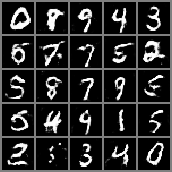

epoch: 3/300, batch: 10/600, G_loss: 1.7638577222824097, D_loss: (0.034931086003780365, 0.3463592231273651)
epoch: 3/300, batch: 20/600, G_loss: 0.951943039894104, D_loss: (0.06551500409841537, 0.8113906979560852)
epoch: 3/300, batch: 30/600, G_loss: 1.5371642112731934, D_loss: (0.06336670368909836, 0.39339640736579895)
epoch: 3/300, batch: 40/600, G_loss: 3.6274144649505615, D_loss: (0.28314676880836487, 0.06049836799502373)
epoch: 3/300, batch: 50/600, G_loss: 1.5326495170593262, D_loss: (0.024227194488048553, 0.36762022972106934)
epoch: 3/300, batch: 60/600, G_loss: 0.8246939182281494, D_loss: (0.009940026327967644, 0.9699259400367737)
epoch: 3/300, batch: 70/600, G_loss: 2.4506773948669434, D_loss: (0.07138428837060928, 0.16906507313251495)
epoch: 3/300, batch: 80/600, G_loss: 2.1801681518554688, D_loss: (0.037206023931503296, 0.1909554898738861)
epoch: 3/300, batch: 90/600, G_loss: 2.7611629962921143, D_loss: (0.06514129042625427, 0.08876147121191025)
epoch: 3/300, batch: 100/600,

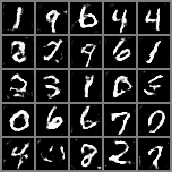

epoch: 3/300, batch: 110/600, G_loss: 0.2878078520298004, D_loss: (0.006943351123481989, 2.305394172668457)
epoch: 3/300, batch: 120/600, G_loss: 2.3293750286102295, D_loss: (0.14959710836410522, 0.1662050038576126)
epoch: 3/300, batch: 130/600, G_loss: 2.2941501140594482, D_loss: (0.1056666374206543, 0.1833275407552719)
epoch: 3/300, batch: 140/600, G_loss: 2.190330743789673, D_loss: (0.0718156173825264, 0.2175845205783844)
epoch: 3/300, batch: 150/600, G_loss: 1.8856924772262573, D_loss: (0.06040075421333313, 0.3513364791870117)
epoch: 3/300, batch: 160/600, G_loss: 5.209041118621826, D_loss: (0.5152268409729004, 0.01184030994772911)
epoch: 3/300, batch: 170/600, G_loss: 1.179602026939392, D_loss: (0.08866564929485321, 0.5986691117286682)
epoch: 3/300, batch: 180/600, G_loss: 2.5122711658477783, D_loss: (0.0420200489461422, 0.12589919567108154)
epoch: 3/300, batch: 190/600, G_loss: 3.0115718841552734, D_loss: (0.2807447612285614, 0.08525924384593964)
epoch: 3/300, batch: 200/600, G_l

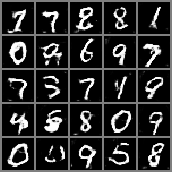

epoch: 3/300, batch: 210/600, G_loss: 4.391866683959961, D_loss: (0.8748016357421875, 0.025937369093298912)
epoch: 3/300, batch: 220/600, G_loss: 3.0698189735412598, D_loss: (0.2644692063331604, 0.08209804445505142)
epoch: 3/300, batch: 230/600, G_loss: 1.6949881315231323, D_loss: (0.14226682484149933, 0.35197049379348755)
epoch: 3/300, batch: 240/600, G_loss: 4.230158805847168, D_loss: (0.48840397596359253, 0.03250464051961899)
epoch: 3/300, batch: 250/600, G_loss: 2.6858019828796387, D_loss: (0.2203214019536972, 0.11793830990791321)
epoch: 3/300, batch: 260/600, G_loss: 2.0234105587005615, D_loss: (0.03475681692361832, 0.25771021842956543)
epoch: 3/300, batch: 270/600, G_loss: 3.3316919803619385, D_loss: (0.3595705032348633, 0.0713132992386818)
epoch: 3/300, batch: 280/600, G_loss: 3.7263402938842773, D_loss: (0.1843739002943039, 0.043546270579099655)
epoch: 3/300, batch: 290/600, G_loss: 1.6088471412658691, D_loss: (0.0232356209307909, 0.32058167457580566)
epoch: 3/300, batch: 300/6

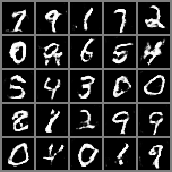

epoch: 3/300, batch: 310/600, G_loss: 3.0075345039367676, D_loss: (0.26088473200798035, 0.07991750538349152)
epoch: 3/300, batch: 320/600, G_loss: 4.640822410583496, D_loss: (0.6675276756286621, 0.01916304975748062)
epoch: 3/300, batch: 330/600, G_loss: 2.8667778968811035, D_loss: (0.11974645406007767, 0.105740487575531)
epoch: 3/300, batch: 340/600, G_loss: 0.6022350788116455, D_loss: (0.015362823382019997, 1.2375444173812866)
epoch: 3/300, batch: 350/600, G_loss: 2.966856002807617, D_loss: (0.4764552414417267, 0.09145708382129669)
epoch: 3/300, batch: 360/600, G_loss: 3.1084935665130615, D_loss: (0.173421248793602, 0.07794754207134247)
epoch: 3/300, batch: 370/600, G_loss: 1.6951771974563599, D_loss: (0.036709558218717575, 0.34765422344207764)
epoch: 3/300, batch: 380/600, G_loss: 2.2905023097991943, D_loss: (0.05322354659438133, 0.1925119161605835)
epoch: 3/300, batch: 390/600, G_loss: 2.6266982555389404, D_loss: (0.16644041240215302, 0.15140268206596375)
epoch: 3/300, batch: 400/60

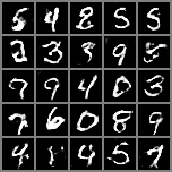

epoch: 3/300, batch: 410/600, G_loss: 2.0342464447021484, D_loss: (0.2492443472146988, 0.22263716161251068)
epoch: 3/300, batch: 420/600, G_loss: 4.4024505615234375, D_loss: (0.8416221737861633, 0.018842924386262894)
epoch: 3/300, batch: 430/600, G_loss: 0.7090533375740051, D_loss: (0.021758370101451874, 1.1128127574920654)
epoch: 3/300, batch: 440/600, G_loss: 2.419956922531128, D_loss: (0.09522949159145355, 0.1837143450975418)
epoch: 3/300, batch: 450/600, G_loss: 4.041271209716797, D_loss: (0.611076831817627, 0.0401628352701664)
epoch: 3/300, batch: 460/600, G_loss: 2.9425182342529297, D_loss: (0.38783711194992065, 0.08524125069379807)
epoch: 3/300, batch: 470/600, G_loss: 1.6795083284378052, D_loss: (0.12714582681655884, 0.3397955000400543)
epoch: 3/300, batch: 480/600, G_loss: 0.7085331678390503, D_loss: (0.0379929281771183, 1.0603950023651123)
epoch: 3/300, batch: 490/600, G_loss: 1.7448129653930664, D_loss: (0.03516583889722824, 0.31619730591773987)
epoch: 3/300, batch: 500/600,

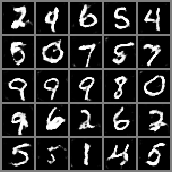

epoch: 3/300, batch: 510/600, G_loss: 2.679292917251587, D_loss: (0.21451732516288757, 0.1382906436920166)
epoch: 3/300, batch: 520/600, G_loss: 3.166626214981079, D_loss: (0.2023676484823227, 0.09091145545244217)
epoch: 3/300, batch: 530/600, G_loss: 3.185910224914551, D_loss: (0.1944189816713333, 0.07568468153476715)
epoch: 3/300, batch: 540/600, G_loss: 4.026796340942383, D_loss: (0.27914807200431824, 0.03284849971532822)
epoch: 3/300, batch: 550/600, G_loss: 3.7851922512054443, D_loss: (0.26926615834236145, 0.03846702352166176)
epoch: 3/300, batch: 560/600, G_loss: 3.228703022003174, D_loss: (0.21693487465381622, 0.06438934803009033)
epoch: 3/300, batch: 570/600, G_loss: 4.976884841918945, D_loss: (0.3463329076766968, 0.01212471816688776)
epoch: 3/300, batch: 580/600, G_loss: 1.4089865684509277, D_loss: (0.11712167412042618, 0.4334387183189392)
epoch: 3/300, batch: 590/600, G_loss: 1.4421964883804321, D_loss: (0.02707325853407383, 0.4411830008029938)
epoch: 4/300, batch: 0/600, G_l

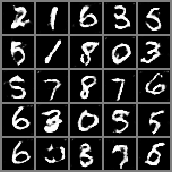

epoch: 4/300, batch: 10/600, G_loss: 2.4293510913848877, D_loss: (0.07171639800071716, 0.1401532143354416)
epoch: 4/300, batch: 20/600, G_loss: 4.449993133544922, D_loss: (0.4933430850505829, 0.019373327493667603)
epoch: 4/300, batch: 30/600, G_loss: 3.294102430343628, D_loss: (0.12762124836444855, 0.064041867852211)
epoch: 4/300, batch: 40/600, G_loss: 2.769205093383789, D_loss: (0.29704970121383667, 0.09559781849384308)
epoch: 4/300, batch: 50/600, G_loss: 3.0483884811401367, D_loss: (0.15694966912269592, 0.0936514288187027)
epoch: 4/300, batch: 60/600, G_loss: 2.8591361045837402, D_loss: (0.10396666824817657, 0.10624230653047562)
epoch: 4/300, batch: 70/600, G_loss: 2.8774402141571045, D_loss: (0.74775230884552, 0.10198510438203812)
epoch: 4/300, batch: 80/600, G_loss: 3.624589204788208, D_loss: (0.05025197193026543, 0.053975049406290054)
epoch: 4/300, batch: 90/600, G_loss: 3.1832761764526367, D_loss: (0.252537339925766, 0.06962192803621292)
epoch: 4/300, batch: 100/600, G_loss: 1.

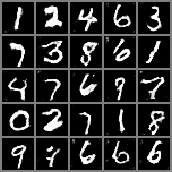

epoch: 4/300, batch: 110/600, G_loss: 3.14570951461792, D_loss: (0.6325604915618896, 0.07634734362363815)
epoch: 4/300, batch: 120/600, G_loss: 3.4366261959075928, D_loss: (0.23653890192508698, 0.06039673462510109)
epoch: 4/300, batch: 130/600, G_loss: 1.62113356590271, D_loss: (0.07958126813173294, 0.38830485939979553)
epoch: 4/300, batch: 140/600, G_loss: 1.3443207740783691, D_loss: (0.06491449475288391, 0.44083747267723083)
epoch: 4/300, batch: 150/600, G_loss: 3.740065574645996, D_loss: (0.23166199028491974, 0.0551474392414093)
epoch: 4/300, batch: 160/600, G_loss: 1.9207912683486938, D_loss: (0.05932573974132538, 0.262276828289032)
epoch: 4/300, batch: 170/600, G_loss: 2.8214962482452393, D_loss: (0.15393415093421936, 0.13024437427520752)
epoch: 4/300, batch: 180/600, G_loss: 3.960488796234131, D_loss: (0.08198503404855728, 0.04234343394637108)
epoch: 4/300, batch: 190/600, G_loss: 1.096228003501892, D_loss: (0.01310613751411438, 0.6116311550140381)
epoch: 4/300, batch: 200/600, G

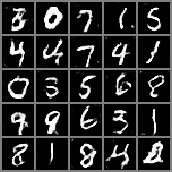

epoch: 4/300, batch: 210/600, G_loss: 5.926894664764404, D_loss: (1.4924745559692383, 0.00724854925647378)
epoch: 4/300, batch: 220/600, G_loss: 3.4291887283325195, D_loss: (0.24741540849208832, 0.04952480271458626)
epoch: 4/300, batch: 230/600, G_loss: 2.674074649810791, D_loss: (0.6204969882965088, 0.12065266817808151)
epoch: 4/300, batch: 240/600, G_loss: 2.0640721321105957, D_loss: (0.2306467443704605, 0.21211153268814087)
epoch: 4/300, batch: 250/600, G_loss: 1.6618647575378418, D_loss: (0.39677074551582336, 0.3420642912387848)
epoch: 4/300, batch: 260/600, G_loss: 3.069584846496582, D_loss: (0.49210965633392334, 0.09904301911592484)
epoch: 4/300, batch: 270/600, G_loss: 2.4800057411193848, D_loss: (0.03498305380344391, 0.13654009997844696)
epoch: 4/300, batch: 280/600, G_loss: 1.676601767539978, D_loss: (0.09333425760269165, 0.34114840626716614)
epoch: 4/300, batch: 290/600, G_loss: 2.4532902240753174, D_loss: (0.3279855251312256, 0.1473463773727417)
epoch: 4/300, batch: 300/600,

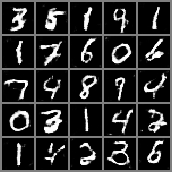

epoch: 4/300, batch: 310/600, G_loss: 5.305367469787598, D_loss: (1.1981585025787354, 0.00862096156924963)
epoch: 4/300, batch: 320/600, G_loss: 2.726655960083008, D_loss: (0.09174008667469025, 0.1293342560529709)
epoch: 4/300, batch: 330/600, G_loss: 2.966902732849121, D_loss: (0.2673789858818054, 0.09091976284980774)
epoch: 4/300, batch: 340/600, G_loss: 1.032024621963501, D_loss: (0.014433844946324825, 0.7101843953132629)
epoch: 4/300, batch: 350/600, G_loss: 1.609038233757019, D_loss: (0.24570505321025848, 0.33480149507522583)
epoch: 4/300, batch: 360/600, G_loss: 3.2412989139556885, D_loss: (0.40101489424705505, 0.06797093152999878)
epoch: 4/300, batch: 370/600, G_loss: 3.1241843700408936, D_loss: (0.07757352292537689, 0.0849689319729805)
epoch: 4/300, batch: 380/600, G_loss: 2.8027865886688232, D_loss: (0.20577457547187805, 0.09185498207807541)
epoch: 4/300, batch: 390/600, G_loss: 1.9684901237487793, D_loss: (0.04706217721104622, 0.2690265476703644)
epoch: 4/300, batch: 400/600,

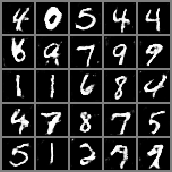

epoch: 4/300, batch: 410/600, G_loss: 4.948497772216797, D_loss: (0.5278838276863098, 0.018820572644472122)
epoch: 4/300, batch: 420/600, G_loss: 4.399089813232422, D_loss: (0.2443716675043106, 0.030194588005542755)
epoch: 4/300, batch: 430/600, G_loss: 2.808382034301758, D_loss: (0.1205630898475647, 0.0955275222659111)
epoch: 4/300, batch: 440/600, G_loss: 4.1239705085754395, D_loss: (0.49816372990608215, 0.04051785543560982)
epoch: 4/300, batch: 450/600, G_loss: 2.970721960067749, D_loss: (0.2281176894903183, 0.08212148398160934)
epoch: 4/300, batch: 460/600, G_loss: 1.7303276062011719, D_loss: (0.22397668659687042, 0.32841601967811584)
epoch: 4/300, batch: 470/600, G_loss: 2.9031870365142822, D_loss: (0.10701904445886612, 0.08380770683288574)
epoch: 4/300, batch: 480/600, G_loss: 1.3049544095993042, D_loss: (0.14069148898124695, 0.4635716378688812)
epoch: 4/300, batch: 490/600, G_loss: 2.0391621589660645, D_loss: (0.16679634153842926, 0.27477002143859863)
epoch: 4/300, batch: 500/60

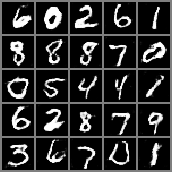

epoch: 4/300, batch: 510/600, G_loss: 2.1969125270843506, D_loss: (0.1322106122970581, 0.23549099266529083)
epoch: 4/300, batch: 520/600, G_loss: 2.5299415588378906, D_loss: (0.266400009393692, 0.16683797538280487)
epoch: 4/300, batch: 530/600, G_loss: 1.6530792713165283, D_loss: (0.04608813673257828, 0.35145702958106995)
epoch: 4/300, batch: 540/600, G_loss: 2.9724950790405273, D_loss: (0.07135137915611267, 0.09309811890125275)
epoch: 4/300, batch: 550/600, G_loss: 1.652046799659729, D_loss: (0.044365640729665756, 0.33022066950798035)
epoch: 4/300, batch: 560/600, G_loss: 3.338352680206299, D_loss: (0.3022659122943878, 0.0646790862083435)
epoch: 4/300, batch: 570/600, G_loss: 2.6943132877349854, D_loss: (0.06256722658872604, 0.1321161687374115)
epoch: 4/300, batch: 580/600, G_loss: 2.0509133338928223, D_loss: (0.022866258397698402, 0.23950286209583282)
epoch: 4/300, batch: 590/600, G_loss: 2.7758429050445557, D_loss: (0.09042409062385559, 0.10415977239608765)
epoch: 5/300, batch: 0/60

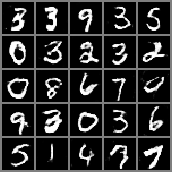

epoch: 5/300, batch: 10/600, G_loss: 3.8259778022766113, D_loss: (0.26829758286476135, 0.0416017547249794)
epoch: 5/300, batch: 20/600, G_loss: 1.7979652881622314, D_loss: (0.37752383947372437, 0.27856218814849854)
epoch: 5/300, batch: 30/600, G_loss: 0.9993471503257751, D_loss: (0.14656224846839905, 0.6944003105163574)
epoch: 5/300, batch: 40/600, G_loss: 1.8735723495483398, D_loss: (0.18698623776435852, 0.24593600630760193)
epoch: 5/300, batch: 50/600, G_loss: 1.6507492065429688, D_loss: (0.1191234365105629, 0.3181664049625397)
epoch: 5/300, batch: 60/600, G_loss: 1.7768659591674805, D_loss: (0.25978946685791016, 0.3281620740890503)
epoch: 5/300, batch: 70/600, G_loss: 3.3357489109039307, D_loss: (0.3304773271083832, 0.06461983919143677)
epoch: 5/300, batch: 80/600, G_loss: 3.1528284549713135, D_loss: (0.7149236798286438, 0.08207928389310837)
epoch: 5/300, batch: 90/600, G_loss: 3.646681308746338, D_loss: (1.2762635946273804, 0.042567696422338486)
epoch: 5/300, batch: 100/600, G_loss

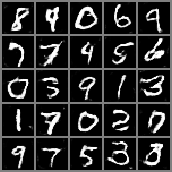

epoch: 5/300, batch: 110/600, G_loss: 3.992494583129883, D_loss: (0.1776077151298523, 0.029296783730387688)
epoch: 5/300, batch: 120/600, G_loss: 2.057398796081543, D_loss: (0.07124722748994827, 0.2183859795331955)
epoch: 5/300, batch: 130/600, G_loss: 1.8138930797576904, D_loss: (0.034445419907569885, 0.30882012844085693)
epoch: 5/300, batch: 140/600, G_loss: 4.6772050857543945, D_loss: (0.22939223051071167, 0.019196875393390656)
epoch: 5/300, batch: 150/600, G_loss: 1.9970611333847046, D_loss: (0.4102611839771271, 0.2577354907989502)
epoch: 5/300, batch: 160/600, G_loss: 2.0039448738098145, D_loss: (0.2018725574016571, 0.21012911200523376)
epoch: 5/300, batch: 170/600, G_loss: 2.9053757190704346, D_loss: (0.08792784810066223, 0.10903439670801163)
epoch: 5/300, batch: 180/600, G_loss: 4.245676517486572, D_loss: (0.4752803146839142, 0.02867732010781765)
epoch: 5/300, batch: 190/600, G_loss: 3.6359071731567383, D_loss: (0.08182255923748016, 0.04203447327017784)
epoch: 5/300, batch: 200/

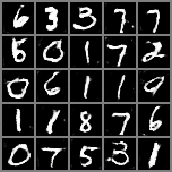

epoch: 5/300, batch: 210/600, G_loss: 3.012310266494751, D_loss: (0.044235892593860626, 0.08375139534473419)
epoch: 5/300, batch: 220/600, G_loss: 1.8659570217132568, D_loss: (0.07516216486692429, 0.284879207611084)
epoch: 5/300, batch: 230/600, G_loss: 2.6330764293670654, D_loss: (0.35534095764160156, 0.13518796861171722)
epoch: 5/300, batch: 240/600, G_loss: 1.7848385572433472, D_loss: (0.2544829547405243, 0.38767001032829285)
epoch: 5/300, batch: 250/600, G_loss: 2.9792368412017822, D_loss: (0.1006876677274704, 0.11287696659564972)
epoch: 5/300, batch: 260/600, G_loss: 1.0921095609664917, D_loss: (0.01748037338256836, 0.7157223224639893)
epoch: 5/300, batch: 270/600, G_loss: 4.921276569366455, D_loss: (0.46112480759620667, 0.013857327401638031)
epoch: 5/300, batch: 280/600, G_loss: 1.312904715538025, D_loss: (0.18010424077510834, 0.45790332555770874)
epoch: 5/300, batch: 290/600, G_loss: 2.2641522884368896, D_loss: (0.36527833342552185, 0.17748036980628967)
epoch: 5/300, batch: 300/

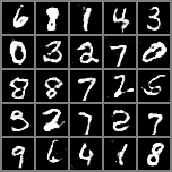

epoch: 5/300, batch: 310/600, G_loss: 3.1005029678344727, D_loss: (0.16757331788539886, 0.08374567329883575)
epoch: 5/300, batch: 320/600, G_loss: 1.5581753253936768, D_loss: (0.23074287176132202, 0.3800710439682007)
epoch: 5/300, batch: 330/600, G_loss: 0.9980027079582214, D_loss: (0.06651023030281067, 0.8192090392112732)
epoch: 5/300, batch: 340/600, G_loss: 2.7266955375671387, D_loss: (0.25873276591300964, 0.11398979276418686)
epoch: 5/300, batch: 350/600, G_loss: 2.105227470397949, D_loss: (0.07022033631801605, 0.20032356679439545)
epoch: 5/300, batch: 360/600, G_loss: 3.8994550704956055, D_loss: (0.33276671171188354, 0.03820826858282089)
epoch: 5/300, batch: 370/600, G_loss: 1.841459035873413, D_loss: (0.045990921556949615, 0.25722241401672363)
epoch: 5/300, batch: 380/600, G_loss: 3.121269464492798, D_loss: (0.23343034088611603, 0.0823444053530693)
epoch: 5/300, batch: 390/600, G_loss: 2.2798073291778564, D_loss: (0.26676619052886963, 0.1841471642255783)
epoch: 5/300, batch: 400/

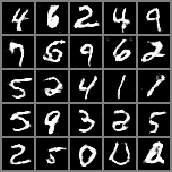

epoch: 5/300, batch: 410/600, G_loss: 6.607989311218262, D_loss: (2.6764299869537354, 0.0029097048100084066)
epoch: 5/300, batch: 420/600, G_loss: 0.8639276623725891, D_loss: (0.1104050800204277, 0.7917681336402893)
epoch: 5/300, batch: 430/600, G_loss: 2.6677615642547607, D_loss: (0.8631551265716553, 0.10498560965061188)
epoch: 5/300, batch: 440/600, G_loss: 1.3545629978179932, D_loss: (0.356227308511734, 0.429275780916214)
epoch: 5/300, batch: 450/600, G_loss: 1.6207233667373657, D_loss: (0.08101082593202591, 0.38927558064460754)
epoch: 5/300, batch: 460/600, G_loss: 4.165618419647217, D_loss: (0.7004005908966064, 0.027480600401759148)
epoch: 5/300, batch: 470/600, G_loss: 1.0097565650939941, D_loss: (0.02720089629292488, 0.6895737648010254)
epoch: 5/300, batch: 480/600, G_loss: 2.5983879566192627, D_loss: (0.3881894648075104, 0.12683413922786713)
epoch: 5/300, batch: 490/600, G_loss: 1.8388844728469849, D_loss: (0.14573363959789276, 0.29942771792411804)
epoch: 5/300, batch: 500/600,

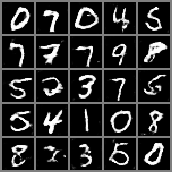

epoch: 5/300, batch: 510/600, G_loss: 2.3068315982818604, D_loss: (0.2602371573448181, 0.20083904266357422)
epoch: 5/300, batch: 520/600, G_loss: 2.8578810691833496, D_loss: (0.21805451810359955, 0.09326700121164322)
epoch: 5/300, batch: 530/600, G_loss: 2.459977626800537, D_loss: (0.3248838782310486, 0.13723918795585632)
epoch: 5/300, batch: 540/600, G_loss: 2.1662261486053467, D_loss: (0.23045989871025085, 0.19493918120861053)
epoch: 5/300, batch: 550/600, G_loss: 3.220921277999878, D_loss: (0.4205353558063507, 0.0803975835442543)
epoch: 5/300, batch: 560/600, G_loss: 3.4959497451782227, D_loss: (0.4519987404346466, 0.05549691990017891)
epoch: 5/300, batch: 570/600, G_loss: 4.757780075073242, D_loss: (0.8484578728675842, 0.017180319875478745)
epoch: 5/300, batch: 580/600, G_loss: 0.6567947864532471, D_loss: (0.015726173296570778, 1.0014536380767822)
epoch: 5/300, batch: 590/600, G_loss: 0.6748583912849426, D_loss: (0.10210026800632477, 1.0217220783233643)
epoch: 6/300, batch: 0/600, 

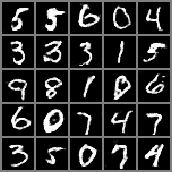

epoch: 6/300, batch: 10/600, G_loss: 1.996002197265625, D_loss: (0.1288691759109497, 0.2746206820011139)
epoch: 6/300, batch: 20/600, G_loss: 2.821110486984253, D_loss: (0.20624567568302155, 0.1284290850162506)
epoch: 6/300, batch: 30/600, G_loss: 1.6819344758987427, D_loss: (0.07599259167909622, 0.33911898732185364)
epoch: 6/300, batch: 40/600, G_loss: 2.237389326095581, D_loss: (0.06058143451809883, 0.1674777865409851)
epoch: 6/300, batch: 50/600, G_loss: 3.818556547164917, D_loss: (0.6903083324432373, 0.03741496428847313)
epoch: 6/300, batch: 60/600, G_loss: 0.6830583810806274, D_loss: (0.02757256105542183, 1.0851129293441772)
epoch: 6/300, batch: 70/600, G_loss: 1.6660735607147217, D_loss: (0.017827054485678673, 0.26924899220466614)
epoch: 6/300, batch: 80/600, G_loss: 2.451819658279419, D_loss: (0.13824547827243805, 0.1677418202161789)
epoch: 6/300, batch: 90/600, G_loss: 4.540436744689941, D_loss: (0.5050468444824219, 0.018312467262148857)
epoch: 6/300, batch: 100/600, G_loss: 2.

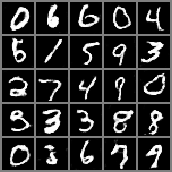

epoch: 6/300, batch: 110/600, G_loss: 1.7334604263305664, D_loss: (0.04537910595536232, 0.26559895277023315)
epoch: 6/300, batch: 120/600, G_loss: 5.4854559898376465, D_loss: (0.8975266814231873, 0.014614241197705269)
epoch: 6/300, batch: 130/600, G_loss: 4.713674545288086, D_loss: (0.7514457702636719, 0.01734967529773712)
epoch: 6/300, batch: 140/600, G_loss: 5.133110523223877, D_loss: (0.7811437845230103, 0.015494678169488907)
epoch: 6/300, batch: 150/600, G_loss: 5.263471603393555, D_loss: (1.4483413696289062, 0.009512718766927719)
epoch: 6/300, batch: 160/600, G_loss: 2.419593572616577, D_loss: (0.1951405107975006, 0.13329827785491943)
epoch: 6/300, batch: 170/600, G_loss: 0.5299942493438721, D_loss: (0.025357959792017937, 1.3390933275222778)
epoch: 6/300, batch: 180/600, G_loss: 0.7186682224273682, D_loss: (0.048672065138816833, 1.0615496635437012)
epoch: 6/300, batch: 190/600, G_loss: 0.7680939435958862, D_loss: (0.014197244308888912, 0.865365743637085)
epoch: 6/300, batch: 200/6

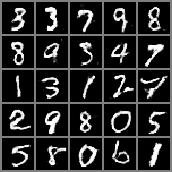

epoch: 6/300, batch: 210/600, G_loss: 2.170978546142578, D_loss: (0.07428698986768723, 0.19299966096878052)
epoch: 6/300, batch: 220/600, G_loss: 2.5470728874206543, D_loss: (0.033867381513118744, 0.14668557047843933)
epoch: 6/300, batch: 230/600, G_loss: 1.4063409566879272, D_loss: (0.09834577888250351, 0.4131576120853424)
epoch: 6/300, batch: 240/600, G_loss: 1.3498563766479492, D_loss: (0.24109145998954773, 0.4187943637371063)
epoch: 6/300, batch: 250/600, G_loss: 2.5796823501586914, D_loss: (0.49376940727233887, 0.12790483236312866)
epoch: 6/300, batch: 260/600, G_loss: 4.432631015777588, D_loss: (0.8797283172607422, 0.020552126690745354)
epoch: 6/300, batch: 270/600, G_loss: 1.9780596494674683, D_loss: (0.10915429890155792, 0.21607133746147156)
epoch: 6/300, batch: 280/600, G_loss: 2.1095807552337646, D_loss: (0.06265770643949509, 0.2139541059732437)
epoch: 6/300, batch: 290/600, G_loss: 2.7461209297180176, D_loss: (0.04132900387048721, 0.09970235079526901)
epoch: 6/300, batch: 30

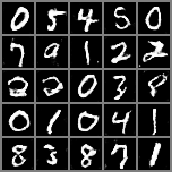

epoch: 6/300, batch: 310/600, G_loss: 2.9946088790893555, D_loss: (0.2888742685317993, 0.12966284155845642)
epoch: 6/300, batch: 320/600, G_loss: 1.8523216247558594, D_loss: (0.03993904963135719, 0.24925649166107178)
epoch: 6/300, batch: 330/600, G_loss: 2.73193359375, D_loss: (0.25415199995040894, 0.12590083479881287)
epoch: 6/300, batch: 340/600, G_loss: 0.960500955581665, D_loss: (0.03519691899418831, 0.6535406708717346)
epoch: 6/300, batch: 350/600, G_loss: 3.0214061737060547, D_loss: (0.3512517809867859, 0.08472046256065369)
epoch: 6/300, batch: 360/600, G_loss: 2.587292432785034, D_loss: (0.15572786331176758, 0.12637324631214142)
epoch: 6/300, batch: 370/600, G_loss: 0.9756873846054077, D_loss: (0.035880789160728455, 0.7064642310142517)
epoch: 6/300, batch: 380/600, G_loss: 1.819769024848938, D_loss: (0.04541894048452377, 0.3067808449268341)
epoch: 6/300, batch: 390/600, G_loss: 3.571401596069336, D_loss: (0.13483957946300507, 0.049836039543151855)
epoch: 6/300, batch: 400/600, G

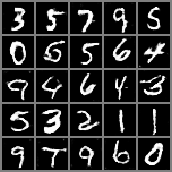

epoch: 6/300, batch: 410/600, G_loss: 3.0587568283081055, D_loss: (0.1874392181634903, 0.07944504916667938)
epoch: 6/300, batch: 420/600, G_loss: 4.02105188369751, D_loss: (0.17514866590499878, 0.03429754823446274)
epoch: 6/300, batch: 430/600, G_loss: 2.8725745677948, D_loss: (0.08677718043327332, 0.10141194611787796)
epoch: 6/300, batch: 440/600, G_loss: 3.25211238861084, D_loss: (0.3082267642021179, 0.07626377046108246)
epoch: 6/300, batch: 450/600, G_loss: 1.8905667066574097, D_loss: (0.088225357234478, 0.2926696240901947)
epoch: 6/300, batch: 460/600, G_loss: 3.1536452770233154, D_loss: (0.49663257598876953, 0.0697672963142395)
epoch: 6/300, batch: 470/600, G_loss: 2.0302932262420654, D_loss: (0.14924252033233643, 0.22914905846118927)
epoch: 6/300, batch: 480/600, G_loss: 2.336775779724121, D_loss: (0.23162071406841278, 0.17150619626045227)
epoch: 6/300, batch: 490/600, G_loss: 3.487852096557617, D_loss: (0.5231332182884216, 0.06352100521326065)
epoch: 6/300, batch: 500/600, G_los

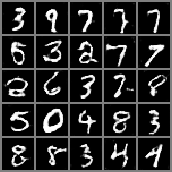

epoch: 6/300, batch: 510/600, G_loss: 1.4559167623519897, D_loss: (0.08535069227218628, 0.4314340353012085)
epoch: 6/300, batch: 520/600, G_loss: 3.1036572456359863, D_loss: (0.30141904950141907, 0.08177059888839722)
epoch: 6/300, batch: 530/600, G_loss: 2.3107411861419678, D_loss: (0.08307215571403503, 0.18821033835411072)
epoch: 6/300, batch: 540/600, G_loss: 2.4778316020965576, D_loss: (0.03629576042294502, 0.16821178793907166)
epoch: 6/300, batch: 550/600, G_loss: 3.3345072269439697, D_loss: (0.4966592788696289, 0.05790264531970024)
epoch: 6/300, batch: 560/600, G_loss: 2.9963510036468506, D_loss: (0.21364782750606537, 0.07999829202890396)
epoch: 6/300, batch: 570/600, G_loss: 1.7428911924362183, D_loss: (0.0602063313126564, 0.28264862298965454)
epoch: 6/300, batch: 580/600, G_loss: 1.5872818231582642, D_loss: (0.7321430444717407, 0.3143472969532013)
epoch: 6/300, batch: 590/600, G_loss: 1.1607651710510254, D_loss: (0.21807464957237244, 0.5516077280044556)
epoch: 7/300, batch: 0/60

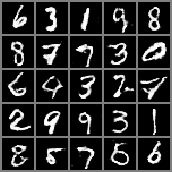

epoch: 7/300, batch: 10/600, G_loss: 1.6507319211959839, D_loss: (0.19644537568092346, 0.3064747154712677)
epoch: 7/300, batch: 20/600, G_loss: 1.7812302112579346, D_loss: (0.1608438938856125, 0.3077648878097534)
epoch: 7/300, batch: 30/600, G_loss: 2.2141966819763184, D_loss: (0.1710413098335266, 0.20702210068702698)
epoch: 7/300, batch: 40/600, G_loss: 2.7257938385009766, D_loss: (0.0894826352596283, 0.1392289400100708)
epoch: 7/300, batch: 50/600, G_loss: 1.3404029607772827, D_loss: (0.03575517609715462, 0.44404706358909607)
epoch: 7/300, batch: 60/600, G_loss: 2.7171318531036377, D_loss: (0.11789512634277344, 0.12287300080060959)
epoch: 7/300, batch: 70/600, G_loss: 2.635570764541626, D_loss: (0.37085285782814026, 0.13067810237407684)
epoch: 7/300, batch: 80/600, G_loss: 3.0067248344421387, D_loss: (0.3236473500728607, 0.08694417774677277)
epoch: 7/300, batch: 90/600, G_loss: 2.905743360519409, D_loss: (0.2995336651802063, 0.09217217564582825)
epoch: 7/300, batch: 100/600, G_loss: 

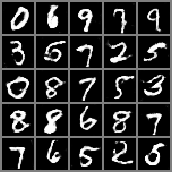

epoch: 7/300, batch: 110/600, G_loss: 3.088887929916382, D_loss: (0.7902885675430298, 0.08546102792024612)
epoch: 7/300, batch: 120/600, G_loss: 2.0051679611206055, D_loss: (0.17446166276931763, 0.2064911425113678)
epoch: 7/300, batch: 130/600, G_loss: 2.7325174808502197, D_loss: (0.10592011362314224, 0.12207622826099396)
epoch: 7/300, batch: 140/600, G_loss: 1.9206228256225586, D_loss: (0.034657541662454605, 0.29790589213371277)
epoch: 7/300, batch: 150/600, G_loss: 3.7335598468780518, D_loss: (0.18993882834911346, 0.044968824833631516)
epoch: 7/300, batch: 160/600, G_loss: 3.2942559719085693, D_loss: (0.11946160346269608, 0.0705961063504219)
epoch: 7/300, batch: 170/600, G_loss: 3.1159398555755615, D_loss: (0.09082555025815964, 0.07811960577964783)
epoch: 7/300, batch: 180/600, G_loss: 1.8883700370788574, D_loss: (0.04817661643028259, 0.24829435348510742)
epoch: 7/300, batch: 190/600, G_loss: 1.9586076736450195, D_loss: (0.4257034361362457, 0.22804246842861176)
epoch: 7/300, batch: 2

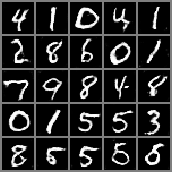

epoch: 7/300, batch: 210/600, G_loss: 2.1997013092041016, D_loss: (0.08308407664299011, 0.17241664230823517)
epoch: 7/300, batch: 220/600, G_loss: 2.1641955375671387, D_loss: (0.05176748335361481, 0.18783752620220184)
epoch: 7/300, batch: 230/600, G_loss: 1.4937564134597778, D_loss: (0.028857067227363586, 0.4348188638687134)
epoch: 7/300, batch: 240/600, G_loss: 4.938648223876953, D_loss: (0.7718729376792908, 0.011315123178064823)
epoch: 7/300, batch: 250/600, G_loss: 1.5874390602111816, D_loss: (0.11548637598752975, 0.3766013979911804)
epoch: 7/300, batch: 260/600, G_loss: 1.2539206743240356, D_loss: (0.007343800738453865, 0.5328786373138428)
epoch: 7/300, batch: 270/600, G_loss: 5.6939616203308105, D_loss: (0.6163127422332764, 0.00798861961811781)
epoch: 7/300, batch: 280/600, G_loss: 3.634765863418579, D_loss: (0.36147308349609375, 0.04825578257441521)
epoch: 7/300, batch: 290/600, G_loss: 0.5836580395698547, D_loss: (0.02008584886789322, 1.2447593212127686)
epoch: 7/300, batch: 300

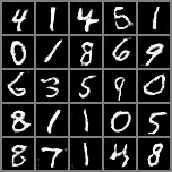

epoch: 7/300, batch: 310/600, G_loss: 3.703813076019287, D_loss: (0.3337365388870239, 0.04671917110681534)
epoch: 7/300, batch: 320/600, G_loss: 2.417933464050293, D_loss: (0.14363163709640503, 0.15038226544857025)
epoch: 7/300, batch: 330/600, G_loss: 2.3299009799957275, D_loss: (0.08260209113359451, 0.21680469810962677)
epoch: 7/300, batch: 340/600, G_loss: 2.5179948806762695, D_loss: (0.0686926394701004, 0.1430596113204956)
epoch: 7/300, batch: 350/600, G_loss: 3.6463711261749268, D_loss: (0.06934759020805359, 0.04615737870335579)
epoch: 7/300, batch: 360/600, G_loss: 3.524339199066162, D_loss: (0.16435913741588593, 0.052511490881443024)
epoch: 7/300, batch: 370/600, G_loss: 1.795046329498291, D_loss: (0.07797978073358536, 0.29984748363494873)
epoch: 7/300, batch: 380/600, G_loss: 1.6214282512664795, D_loss: (0.23306864500045776, 0.34832751750946045)
epoch: 7/300, batch: 390/600, G_loss: 3.060793399810791, D_loss: (0.21254871785640717, 0.08832962810993195)
epoch: 7/300, batch: 400/6

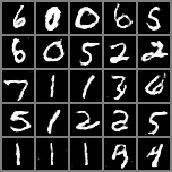

epoch: 7/300, batch: 410/600, G_loss: 2.26265025138855, D_loss: (0.5022462606430054, 0.17151622474193573)
epoch: 7/300, batch: 420/600, G_loss: 3.217909812927246, D_loss: (0.3526570796966553, 0.07820095866918564)
epoch: 7/300, batch: 430/600, G_loss: 1.1765872240066528, D_loss: (0.0355982668697834, 0.5493701100349426)
epoch: 7/300, batch: 440/600, G_loss: 2.244215250015259, D_loss: (0.1959959864616394, 0.1711568832397461)
epoch: 7/300, batch: 450/600, G_loss: 3.3996686935424805, D_loss: (0.4848489761352539, 0.06030572950839996)
epoch: 7/300, batch: 460/600, G_loss: 3.279494047164917, D_loss: (0.17768096923828125, 0.05455011501908302)
epoch: 7/300, batch: 470/600, G_loss: 1.5275030136108398, D_loss: (0.057307809591293335, 0.3599332869052887)
epoch: 7/300, batch: 480/600, G_loss: 5.28737735748291, D_loss: (0.747351884841919, 0.010455852374434471)
epoch: 7/300, batch: 490/600, G_loss: 3.4694275856018066, D_loss: (0.14501678943634033, 0.06477051973342896)
epoch: 7/300, batch: 500/600, G_lo

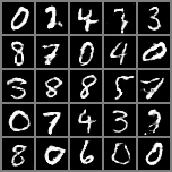

epoch: 7/300, batch: 510/600, G_loss: 3.0339114665985107, D_loss: (0.7777988314628601, 0.0963917076587677)
epoch: 7/300, batch: 520/600, G_loss: 3.7689197063446045, D_loss: (0.1437273919582367, 0.04225773736834526)
epoch: 7/300, batch: 530/600, G_loss: 1.635683536529541, D_loss: (0.11130088567733765, 0.3164493441581726)
epoch: 7/300, batch: 540/600, G_loss: 1.0353962182998657, D_loss: (0.017109239473938942, 0.6267955303192139)
epoch: 7/300, batch: 550/600, G_loss: 1.1167407035827637, D_loss: (0.0725998654961586, 0.5907151103019714)
epoch: 7/300, batch: 560/600, G_loss: 0.9139161705970764, D_loss: (0.015066931024193764, 0.8018234968185425)
epoch: 7/300, batch: 570/600, G_loss: 0.4354780316352844, D_loss: (0.01950795203447342, 1.490455150604248)
epoch: 7/300, batch: 580/600, G_loss: 1.135444164276123, D_loss: (0.05618061125278473, 0.5437142848968506)
epoch: 7/300, batch: 590/600, G_loss: 2.4466350078582764, D_loss: (0.7924243807792664, 0.14492756128311157)
epoch: 8/300, batch: 0/600, G_l

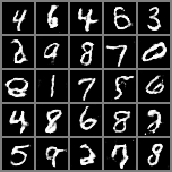

epoch: 8/300, batch: 10/600, G_loss: 2.947981595993042, D_loss: (0.07217156141996384, 0.089666947722435)
epoch: 8/300, batch: 20/600, G_loss: 1.912002682685852, D_loss: (0.1710338592529297, 0.27850401401519775)
epoch: 8/300, batch: 30/600, G_loss: 3.1045172214508057, D_loss: (0.23361682891845703, 0.08646468073129654)
epoch: 8/300, batch: 40/600, G_loss: 2.318863868713379, D_loss: (0.25072187185287476, 0.146210178732872)
epoch: 8/300, batch: 50/600, G_loss: 2.106841802597046, D_loss: (0.09278583526611328, 0.20415546000003815)
epoch: 8/300, batch: 60/600, G_loss: 3.2712512016296387, D_loss: (0.564273476600647, 0.06154831871390343)
epoch: 8/300, batch: 70/600, G_loss: 1.818312168121338, D_loss: (0.2740706503391266, 0.2771771550178528)
epoch: 8/300, batch: 80/600, G_loss: 2.344602346420288, D_loss: (0.04866233468055725, 0.15662233531475067)
epoch: 8/300, batch: 90/600, G_loss: 2.211405038833618, D_loss: (0.0445682667195797, 0.18587030470371246)
epoch: 8/300, batch: 100/600, G_loss: 3.54371

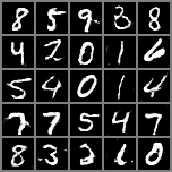

epoch: 8/300, batch: 110/600, G_loss: 4.194988250732422, D_loss: (0.4855838418006897, 0.027355993166565895)
epoch: 8/300, batch: 120/600, G_loss: 4.66155481338501, D_loss: (0.4349312484264374, 0.015430446714162827)
epoch: 8/300, batch: 130/600, G_loss: 1.2760547399520874, D_loss: (0.4702039659023285, 0.514083206653595)
epoch: 8/300, batch: 140/600, G_loss: 2.0653297901153564, D_loss: (0.3382812440395355, 0.19663941860198975)
epoch: 8/300, batch: 150/600, G_loss: 2.466982126235962, D_loss: (0.3760826885700226, 0.14829760789871216)
epoch: 8/300, batch: 160/600, G_loss: 1.4719070196151733, D_loss: (0.07612178474664688, 0.3528582453727722)
epoch: 8/300, batch: 170/600, G_loss: 1.956681251525879, D_loss: (0.26066115498542786, 0.24008163809776306)
epoch: 8/300, batch: 180/600, G_loss: 0.6912349462509155, D_loss: (0.038869332522153854, 1.0606937408447266)
epoch: 8/300, batch: 190/600, G_loss: 3.4612600803375244, D_loss: (0.4213496446609497, 0.060539718717336655)
epoch: 8/300, batch: 200/600, 

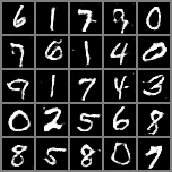

epoch: 8/300, batch: 210/600, G_loss: 2.4076428413391113, D_loss: (0.13388019800186157, 0.13946682214736938)
epoch: 8/300, batch: 220/600, G_loss: 1.0860424041748047, D_loss: (0.04925645887851715, 0.6786676049232483)
epoch: 8/300, batch: 230/600, G_loss: 2.542567253112793, D_loss: (0.14736324548721313, 0.1472109854221344)
epoch: 8/300, batch: 240/600, G_loss: 2.7964084148406982, D_loss: (0.18594080209732056, 0.10869812220335007)
epoch: 8/300, batch: 250/600, G_loss: 1.429795742034912, D_loss: (0.06374568492174149, 0.4512195885181427)
epoch: 8/300, batch: 260/600, G_loss: 1.0225465297698975, D_loss: (0.10045573860406876, 0.6527451872825623)
epoch: 8/300, batch: 270/600, G_loss: 2.5631601810455322, D_loss: (0.2655563950538635, 0.10998111963272095)
epoch: 8/300, batch: 280/600, G_loss: 2.7900214195251465, D_loss: (0.25287100672721863, 0.10011274367570877)
epoch: 8/300, batch: 290/600, G_loss: 1.0421228408813477, D_loss: (0.043166857212781906, 0.6571282744407654)
epoch: 8/300, batch: 300/6

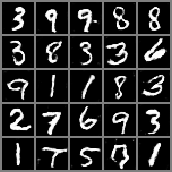

epoch: 8/300, batch: 310/600, G_loss: 2.312887191772461, D_loss: (0.21985004842281342, 0.15270724892616272)
epoch: 8/300, batch: 320/600, G_loss: 1.8032677173614502, D_loss: (0.06366252154111862, 0.2667747735977173)
epoch: 8/300, batch: 330/600, G_loss: 3.941164016723633, D_loss: (0.2573559582233429, 0.030561180785298347)
epoch: 8/300, batch: 340/600, G_loss: 4.305073261260986, D_loss: (0.10356033593416214, 0.020908784121274948)
epoch: 8/300, batch: 350/600, G_loss: 1.139999270439148, D_loss: (0.020975839346647263, 0.5546248555183411)
epoch: 8/300, batch: 360/600, G_loss: 2.970975875854492, D_loss: (0.15921445190906525, 0.09008911997079849)
epoch: 8/300, batch: 370/600, G_loss: 1.2544996738433838, D_loss: (0.020531874150037766, 0.5351904034614563)
epoch: 8/300, batch: 380/600, G_loss: 2.2499873638153076, D_loss: (0.12720999121665955, 0.18311335146427155)
epoch: 8/300, batch: 390/600, G_loss: 4.673955917358398, D_loss: (0.22466705739498138, 0.017612462863326073)
epoch: 8/300, batch: 400

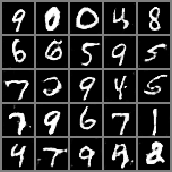

epoch: 8/300, batch: 410/600, G_loss: 1.988398551940918, D_loss: (0.1921548843383789, 0.2629551589488983)
epoch: 8/300, batch: 420/600, G_loss: 4.166901111602783, D_loss: (0.8146717548370361, 0.02702033706009388)
epoch: 8/300, batch: 430/600, G_loss: 2.3150289058685303, D_loss: (0.12239479273557663, 0.16833841800689697)
epoch: 8/300, batch: 440/600, G_loss: 0.955725908279419, D_loss: (0.014416039921343327, 0.7574286460876465)
epoch: 8/300, batch: 450/600, G_loss: 3.0445241928100586, D_loss: (0.1866074949502945, 0.07767389714717865)
epoch: 8/300, batch: 460/600, G_loss: 2.2038185596466064, D_loss: (0.07378224283456802, 0.2202925831079483)
epoch: 8/300, batch: 470/600, G_loss: 4.4144487380981445, D_loss: (0.5796129107475281, 0.025309765711426735)
epoch: 8/300, batch: 480/600, G_loss: 3.928030490875244, D_loss: (0.19961808621883392, 0.03876028209924698)
epoch: 8/300, batch: 490/600, G_loss: 3.071152448654175, D_loss: (0.05782357230782509, 0.0912344828248024)
epoch: 8/300, batch: 500/600, 

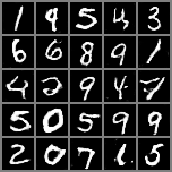

epoch: 8/300, batch: 510/600, G_loss: 2.550416946411133, D_loss: (0.02256903611123562, 0.13291795551776886)
epoch: 8/300, batch: 520/600, G_loss: 2.8310396671295166, D_loss: (0.8204525709152222, 0.09688220918178558)
epoch: 8/300, batch: 530/600, G_loss: 1.4090691804885864, D_loss: (0.2778474688529968, 0.3852134644985199)
epoch: 8/300, batch: 540/600, G_loss: 1.142701506614685, D_loss: (0.22785423696041107, 0.5769160389900208)
epoch: 8/300, batch: 550/600, G_loss: 2.6897025108337402, D_loss: (0.17379917204380035, 0.13869696855545044)
epoch: 8/300, batch: 560/600, G_loss: 2.5419368743896484, D_loss: (0.09066253900527954, 0.15034152567386627)
epoch: 8/300, batch: 570/600, G_loss: 4.447973728179932, D_loss: (0.9362750053405762, 0.020045572891831398)
epoch: 8/300, batch: 580/600, G_loss: 2.649733066558838, D_loss: (0.19331040978431702, 0.11614411324262619)
epoch: 8/300, batch: 590/600, G_loss: 2.624967098236084, D_loss: (0.044312089681625366, 0.11460601538419724)
epoch: 9/300, batch: 0/600,

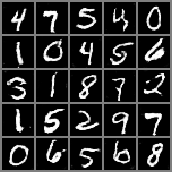

epoch: 9/300, batch: 10/600, G_loss: 2.3061037063598633, D_loss: (0.282840758562088, 0.2085740864276886)
epoch: 9/300, batch: 20/600, G_loss: 5.239452362060547, D_loss: (1.2277579307556152, 0.017419487237930298)
epoch: 9/300, batch: 30/600, G_loss: 2.1466825008392334, D_loss: (0.08142676204442978, 0.1995798498392105)
epoch: 9/300, batch: 40/600, G_loss: 2.5062499046325684, D_loss: (0.24927490949630737, 0.13274402916431427)
epoch: 9/300, batch: 50/600, G_loss: 2.8491592407226562, D_loss: (0.21171027421951294, 0.11109653115272522)
epoch: 9/300, batch: 60/600, G_loss: 2.193037748336792, D_loss: (0.01854139193892479, 0.22475795447826385)
epoch: 9/300, batch: 70/600, G_loss: 4.254661560058594, D_loss: (0.25080037117004395, 0.026637760922312737)
epoch: 9/300, batch: 80/600, G_loss: 2.081277370452881, D_loss: (0.0378793440759182, 0.2174634486436844)
epoch: 9/300, batch: 90/600, G_loss: 2.286720037460327, D_loss: (0.20375388860702515, 0.17812122404575348)
epoch: 9/300, batch: 100/600, G_loss: 

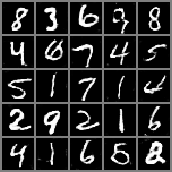

epoch: 9/300, batch: 110/600, G_loss: 3.4225571155548096, D_loss: (0.19696760177612305, 0.05927503481507301)
epoch: 9/300, batch: 120/600, G_loss: 1.5527853965759277, D_loss: (0.14789704978466034, 0.4292100667953491)
epoch: 9/300, batch: 130/600, G_loss: 1.8656331300735474, D_loss: (0.339813768863678, 0.2898709774017334)
epoch: 9/300, batch: 140/600, G_loss: 2.6721832752227783, D_loss: (0.3933977782726288, 0.1268107295036316)
epoch: 9/300, batch: 150/600, G_loss: 2.2637500762939453, D_loss: (0.07559514790773392, 0.19026519358158112)
epoch: 9/300, batch: 160/600, G_loss: 4.984455108642578, D_loss: (0.6630287766456604, 0.012473713606595993)
epoch: 9/300, batch: 170/600, G_loss: 4.2541279792785645, D_loss: (0.47478610277175903, 0.026910018175840378)
epoch: 9/300, batch: 180/600, G_loss: 3.1047732830047607, D_loss: (0.5198913812637329, 0.07692615687847137)
epoch: 9/300, batch: 190/600, G_loss: 2.303331136703491, D_loss: (0.0463189072906971, 0.16042588651180267)
epoch: 9/300, batch: 200/600

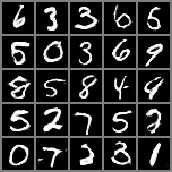

epoch: 9/300, batch: 210/600, G_loss: 1.6988178491592407, D_loss: (0.08679748326539993, 0.3602429926395416)
epoch: 9/300, batch: 220/600, G_loss: 4.673823833465576, D_loss: (0.043444398790597916, 0.01716066151857376)
epoch: 9/300, batch: 230/600, G_loss: 1.1146762371063232, D_loss: (0.13121390342712402, 0.6439720392227173)
epoch: 9/300, batch: 240/600, G_loss: 0.750749945640564, D_loss: (0.09103439003229141, 0.8588026165962219)
epoch: 9/300, batch: 250/600, G_loss: 2.9775304794311523, D_loss: (0.5368216037750244, 0.10138501971960068)
epoch: 9/300, batch: 260/600, G_loss: 0.5277623534202576, D_loss: (0.007823826745152473, 1.2018074989318848)
epoch: 9/300, batch: 270/600, G_loss: 0.8167424201965332, D_loss: (0.022503357380628586, 0.8691534996032715)
epoch: 9/300, batch: 280/600, G_loss: 5.387406826019287, D_loss: (1.0962798595428467, 0.009422069415450096)
epoch: 9/300, batch: 290/600, G_loss: 2.9906091690063477, D_loss: (0.607479453086853, 0.14013828337192535)
epoch: 9/300, batch: 300/60

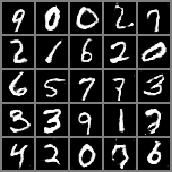

epoch: 9/300, batch: 310/600, G_loss: 2.319459915161133, D_loss: (0.04709574207663536, 0.19560688734054565)
epoch: 9/300, batch: 320/600, G_loss: 3.3096725940704346, D_loss: (0.10124072432518005, 0.06355640292167664)
epoch: 9/300, batch: 330/600, G_loss: 1.9281082153320312, D_loss: (0.12441594153642654, 0.2405189871788025)
epoch: 9/300, batch: 340/600, G_loss: 3.374547004699707, D_loss: (0.25369587540626526, 0.06858973205089569)
epoch: 9/300, batch: 350/600, G_loss: 2.400141477584839, D_loss: (0.05229140445590019, 0.14776398241519928)
epoch: 9/300, batch: 360/600, G_loss: 4.1213202476501465, D_loss: (0.22441266477108002, 0.028659984469413757)
epoch: 9/300, batch: 370/600, G_loss: 1.844915747642517, D_loss: (0.02276510000228882, 0.25743797421455383)
epoch: 9/300, batch: 380/600, G_loss: 2.0429978370666504, D_loss: (0.03416537120938301, 0.21427863836288452)
epoch: 9/300, batch: 390/600, G_loss: 1.8480923175811768, D_loss: (0.34151795506477356, 0.2750096023082733)
epoch: 9/300, batch: 400

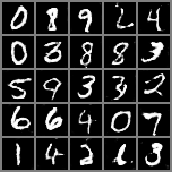

epoch: 9/300, batch: 410/600, G_loss: 0.9096778631210327, D_loss: (0.023062938824295998, 0.8591334819793701)
epoch: 9/300, batch: 420/600, G_loss: 4.385262966156006, D_loss: (0.785968542098999, 0.02842830680310726)
epoch: 9/300, batch: 430/600, G_loss: 3.8234927654266357, D_loss: (0.07281266152858734, 0.04579070955514908)
epoch: 9/300, batch: 440/600, G_loss: 2.5208754539489746, D_loss: (0.10272105038166046, 0.1371758133172989)
epoch: 9/300, batch: 450/600, G_loss: 3.813302516937256, D_loss: (0.15080909430980682, 0.03804580867290497)
epoch: 9/300, batch: 460/600, G_loss: 3.0078084468841553, D_loss: (0.11168636381626129, 0.08394656330347061)
epoch: 9/300, batch: 470/600, G_loss: 1.6414049863815308, D_loss: (0.09741923958063126, 0.3850288689136505)
epoch: 9/300, batch: 480/600, G_loss: 2.404440402984619, D_loss: (0.19091014564037323, 0.16804863512516022)
epoch: 9/300, batch: 490/600, G_loss: 0.6847931742668152, D_loss: (0.03872685134410858, 0.9935817718505859)
epoch: 9/300, batch: 500/60

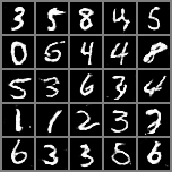

epoch: 9/300, batch: 510/600, G_loss: 2.6967926025390625, D_loss: (0.08141493052244186, 0.1105773001909256)
epoch: 9/300, batch: 520/600, G_loss: 2.0096912384033203, D_loss: (0.04356065392494202, 0.248280331492424)
epoch: 9/300, batch: 530/600, G_loss: 3.8860857486724854, D_loss: (0.14376801252365112, 0.052788715809583664)
epoch: 9/300, batch: 540/600, G_loss: 3.631814479827881, D_loss: (0.4220477044582367, 0.056763339787721634)
epoch: 9/300, batch: 550/600, G_loss: 3.2237708568573, D_loss: (0.1382238268852234, 0.06411343812942505)
epoch: 9/300, batch: 560/600, G_loss: 2.5634491443634033, D_loss: (0.22106346487998962, 0.1498209834098816)
epoch: 9/300, batch: 570/600, G_loss: 2.480591058731079, D_loss: (0.35473397374153137, 0.14536720514297485)
epoch: 9/300, batch: 580/600, G_loss: 3.9115352630615234, D_loss: (0.9834659099578857, 0.04084904491901398)
epoch: 9/300, batch: 590/600, G_loss: 2.737727403640747, D_loss: (0.4658418297767639, 0.10208289325237274)
epoch: 10/300, batch: 0/600, G_

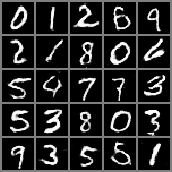

epoch: 10/300, batch: 10/600, G_loss: 4.205411434173584, D_loss: (0.3951394557952881, 0.026057343930006027)
epoch: 10/300, batch: 20/600, G_loss: 2.6364550590515137, D_loss: (0.238089919090271, 0.11603199690580368)
epoch: 10/300, batch: 30/600, G_loss: 2.9238088130950928, D_loss: (0.12651953101158142, 0.09021089226007462)
epoch: 10/300, batch: 40/600, G_loss: 2.6512603759765625, D_loss: (0.09716969728469849, 0.11696775257587433)
epoch: 10/300, batch: 50/600, G_loss: 2.002377986907959, D_loss: (0.03589574992656708, 0.252067506313324)
epoch: 10/300, batch: 60/600, G_loss: 4.331090927124023, D_loss: (0.3745104670524597, 0.022897694259881973)
epoch: 10/300, batch: 70/600, G_loss: 1.9506889581680298, D_loss: (0.2630234658718109, 0.25016146898269653)
epoch: 10/300, batch: 80/600, G_loss: 2.4664525985717773, D_loss: (0.06626981496810913, 0.16981716454029083)
epoch: 10/300, batch: 90/600, G_loss: 2.6079275608062744, D_loss: (0.05159153789281845, 0.13181887567043304)
epoch: 10/300, batch: 100/6

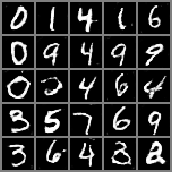

epoch: 10/300, batch: 110/600, G_loss: 6.2424235343933105, D_loss: (1.3526716232299805, 0.00557085731998086)
epoch: 10/300, batch: 120/600, G_loss: 4.246404647827148, D_loss: (0.9875479936599731, 0.02491622045636177)
epoch: 10/300, batch: 130/600, G_loss: 2.236990451812744, D_loss: (0.08197353035211563, 0.17930850386619568)
epoch: 10/300, batch: 140/600, G_loss: 3.3803517818450928, D_loss: (0.22135940194129944, 0.06783340126276016)
epoch: 10/300, batch: 150/600, G_loss: 1.3032389879226685, D_loss: (0.06426367163658142, 0.5370368361473083)
epoch: 10/300, batch: 160/600, G_loss: 1.8505990505218506, D_loss: (0.1939229816198349, 0.3124202787876129)
epoch: 10/300, batch: 170/600, G_loss: 2.402008295059204, D_loss: (0.0951438620686531, 0.13641077280044556)
epoch: 10/300, batch: 180/600, G_loss: 2.499694347381592, D_loss: (0.15348438918590546, 0.14475145936012268)
epoch: 10/300, batch: 190/600, G_loss: 2.6036322116851807, D_loss: (0.16978268325328827, 0.1499495506286621)
epoch: 10/300, batch:

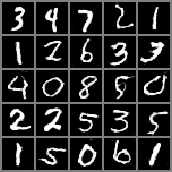

epoch: 10/300, batch: 210/600, G_loss: 5.490561485290527, D_loss: (0.5313530564308167, 0.008571753278374672)
epoch: 10/300, batch: 220/600, G_loss: 2.1171817779541016, D_loss: (0.07192233204841614, 0.20185519754886627)
epoch: 10/300, batch: 230/600, G_loss: 4.034103870391846, D_loss: (0.43157827854156494, 0.03243299946188927)
epoch: 10/300, batch: 240/600, G_loss: 3.186357021331787, D_loss: (0.4444016218185425, 0.06753656268119812)
epoch: 10/300, batch: 250/600, G_loss: 4.6718363761901855, D_loss: (0.1120077520608902, 0.017042025923728943)
epoch: 10/300, batch: 260/600, G_loss: 2.512209892272949, D_loss: (0.020573409274220467, 0.15319035947322845)
epoch: 10/300, batch: 270/600, G_loss: 3.6183581352233887, D_loss: (0.07995903491973877, 0.05231284722685814)
epoch: 10/300, batch: 280/600, G_loss: 3.3018643856048584, D_loss: (0.03704151511192322, 0.06318940967321396)
epoch: 10/300, batch: 290/600, G_loss: 7.22773551940918, D_loss: (1.6468102931976318, 0.001475017867051065)
epoch: 10/300, b

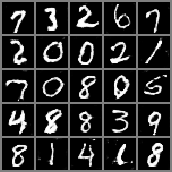

epoch: 10/300, batch: 310/600, G_loss: 2.670588731765747, D_loss: (0.027826275676488876, 0.1402854025363922)
epoch: 10/300, batch: 320/600, G_loss: 3.8361339569091797, D_loss: (0.05753384158015251, 0.04266579449176788)
epoch: 10/300, batch: 330/600, G_loss: 3.229936122894287, D_loss: (0.17898450791835785, 0.0678989514708519)
epoch: 10/300, batch: 340/600, G_loss: 0.8891870379447937, D_loss: (0.10272050648927689, 0.7636891007423401)
epoch: 10/300, batch: 350/600, G_loss: 3.7842588424682617, D_loss: (1.0550496578216553, 0.048812974244356155)
epoch: 10/300, batch: 360/600, G_loss: 1.0544626712799072, D_loss: (0.17810319364070892, 0.6041656732559204)
epoch: 10/300, batch: 370/600, G_loss: 2.275890827178955, D_loss: (0.15079271793365479, 0.21539495885372162)
epoch: 10/300, batch: 380/600, G_loss: 2.285130739212036, D_loss: (0.09575289487838745, 0.17133131623268127)
epoch: 10/300, batch: 390/600, G_loss: 2.542161226272583, D_loss: (0.0398196317255497, 0.1494736522436142)
epoch: 10/300, batch

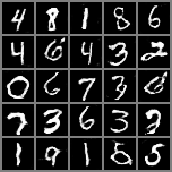

epoch: 10/300, batch: 410/600, G_loss: 3.5207788944244385, D_loss: (0.14660698175430298, 0.05040676146745682)
epoch: 10/300, batch: 420/600, G_loss: 3.315091848373413, D_loss: (0.3257661461830139, 0.07676918804645538)
epoch: 10/300, batch: 430/600, G_loss: 1.0287939310073853, D_loss: (0.02422790601849556, 0.730069100856781)
epoch: 10/300, batch: 440/600, G_loss: 1.7255936861038208, D_loss: (0.07107573002576828, 0.32159045338630676)
epoch: 10/300, batch: 450/600, G_loss: 3.2319674491882324, D_loss: (0.06645485758781433, 0.0649530366063118)
epoch: 10/300, batch: 460/600, G_loss: 4.816451549530029, D_loss: (1.1792311668395996, 0.013860682025551796)
epoch: 10/300, batch: 470/600, G_loss: 0.6333185434341431, D_loss: (0.0755842924118042, 1.0489883422851562)
epoch: 10/300, batch: 480/600, G_loss: 2.3785226345062256, D_loss: (0.052780307829380035, 0.1530078649520874)
epoch: 10/300, batch: 490/600, G_loss: 4.727513313293457, D_loss: (0.16897283494472504, 0.015452468767762184)
epoch: 10/300, bat

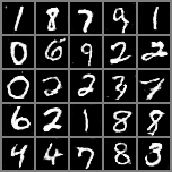

epoch: 10/300, batch: 510/600, G_loss: 1.8380961418151855, D_loss: (0.009145141579210758, 0.2727429270744324)
epoch: 10/300, batch: 520/600, G_loss: 1.7271264791488647, D_loss: (0.010979210957884789, 0.3167095482349396)
epoch: 10/300, batch: 530/600, G_loss: 3.1140663623809814, D_loss: (0.21118684113025665, 0.09329945594072342)
epoch: 10/300, batch: 540/600, G_loss: 2.7369680404663086, D_loss: (0.23596592247486115, 0.11030914634466171)
epoch: 10/300, batch: 550/600, G_loss: 1.273240327835083, D_loss: (0.07159269601106644, 0.5427200794219971)
epoch: 10/300, batch: 560/600, G_loss: 2.588649034500122, D_loss: (0.34309130907058716, 0.12808799743652344)
epoch: 10/300, batch: 570/600, G_loss: 4.545842170715332, D_loss: (0.15471793711185455, 0.022618858143687248)
epoch: 10/300, batch: 580/600, G_loss: 1.6946837902069092, D_loss: (0.08347812294960022, 0.28181982040405273)
epoch: 10/300, batch: 590/600, G_loss: 4.158444404602051, D_loss: (0.2223813831806183, 0.041769370436668396)
epoch: 11/300,

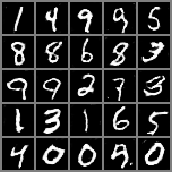

epoch: 11/300, batch: 10/600, G_loss: 2.0739054679870605, D_loss: (0.02914499118924141, 0.27428632974624634)
epoch: 11/300, batch: 20/600, G_loss: 2.216187000274658, D_loss: (0.09759817272424698, 0.19349826872348785)
epoch: 11/300, batch: 30/600, G_loss: 6.9704766273498535, D_loss: (0.8848479986190796, 0.0015675666509196162)
epoch: 11/300, batch: 40/600, G_loss: 2.082564353942871, D_loss: (0.10221684724092484, 0.21405670046806335)
epoch: 11/300, batch: 50/600, G_loss: 4.946044921875, D_loss: (0.24930642545223236, 0.017495861276984215)
epoch: 11/300, batch: 60/600, G_loss: 2.3196613788604736, D_loss: (0.024091849103569984, 0.1674269139766693)
epoch: 11/300, batch: 70/600, G_loss: 2.5985307693481445, D_loss: (0.09991996735334396, 0.12278416752815247)
epoch: 11/300, batch: 80/600, G_loss: 4.1712565422058105, D_loss: (0.11975866556167603, 0.049777742475271225)
epoch: 11/300, batch: 90/600, G_loss: 4.897397041320801, D_loss: (0.9158139824867249, 0.01722613535821438)
epoch: 11/300, batch: 10

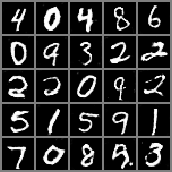

epoch: 11/300, batch: 110/600, G_loss: 1.3832992315292358, D_loss: (0.00843286607414484, 0.4281228184700012)
epoch: 11/300, batch: 120/600, G_loss: 1.4596447944641113, D_loss: (0.01636439748108387, 0.4632768929004669)
epoch: 11/300, batch: 130/600, G_loss: 4.322833061218262, D_loss: (0.20384617149829865, 0.024547763168811798)
epoch: 11/300, batch: 140/600, G_loss: 2.5599794387817383, D_loss: (0.06357084214687347, 0.14362922310829163)
epoch: 11/300, batch: 150/600, G_loss: 1.746713399887085, D_loss: (0.029657535254955292, 0.33380067348480225)
epoch: 11/300, batch: 160/600, G_loss: 5.0174994468688965, D_loss: (0.8289474248886108, 0.01723136380314827)
epoch: 11/300, batch: 170/600, G_loss: 3.0892348289489746, D_loss: (0.12096810340881348, 0.08719155937433243)
epoch: 11/300, batch: 180/600, G_loss: 0.5280150175094604, D_loss: (0.06809858977794647, 1.2612438201904297)
epoch: 11/300, batch: 190/600, G_loss: 4.541958332061768, D_loss: (1.9949613809585571, 0.018425364047288895)
epoch: 11/300, 

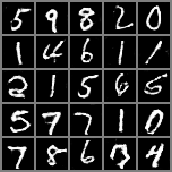

epoch: 11/300, batch: 210/600, G_loss: 0.8295609951019287, D_loss: (0.07303506135940552, 0.8116785287857056)
epoch: 11/300, batch: 220/600, G_loss: 3.049604892730713, D_loss: (0.2114853411912918, 0.11027737706899643)
epoch: 11/300, batch: 230/600, G_loss: 2.029768466949463, D_loss: (0.14878545701503754, 0.21197958290576935)
epoch: 11/300, batch: 240/600, G_loss: 3.04736328125, D_loss: (0.04868298023939133, 0.09367622435092926)
epoch: 11/300, batch: 250/600, G_loss: 3.113067626953125, D_loss: (0.12682567536830902, 0.07287726551294327)
epoch: 11/300, batch: 260/600, G_loss: 2.8452036380767822, D_loss: (0.19055704772472382, 0.10012193024158478)
epoch: 11/300, batch: 270/600, G_loss: 2.6616897583007812, D_loss: (0.22774401307106018, 0.12608015537261963)
epoch: 11/300, batch: 280/600, G_loss: 9.347912788391113, D_loss: (3.736351728439331, 0.0005005776765756309)
epoch: 11/300, batch: 290/600, G_loss: 2.3908138275146484, D_loss: (0.15988513827323914, 0.1411181390285492)
epoch: 11/300, batch: 

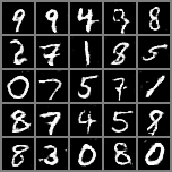

epoch: 11/300, batch: 310/600, G_loss: 2.412355661392212, D_loss: (0.17476387321949005, 0.1775459349155426)
epoch: 11/300, batch: 320/600, G_loss: 2.523191452026367, D_loss: (0.10902299731969833, 0.13152346014976501)
epoch: 11/300, batch: 330/600, G_loss: 2.664677381515503, D_loss: (0.03545250743627548, 0.13843244314193726)
epoch: 11/300, batch: 340/600, G_loss: 4.1203107833862305, D_loss: (0.7274538278579712, 0.03978807106614113)
epoch: 11/300, batch: 350/600, G_loss: 3.6532373428344727, D_loss: (0.1016637310385704, 0.05493544414639473)
epoch: 11/300, batch: 360/600, G_loss: 3.861636161804199, D_loss: (0.18169423937797546, 0.03776345029473305)
epoch: 11/300, batch: 370/600, G_loss: 2.569437265396118, D_loss: (0.03203285112977028, 0.12700197100639343)
epoch: 11/300, batch: 380/600, G_loss: 5.2811174392700195, D_loss: (0.7928439974784851, 0.011009634472429752)
epoch: 11/300, batch: 390/600, G_loss: 3.206752300262451, D_loss: (0.1921767294406891, 0.06698582321405411)
epoch: 11/300, batch

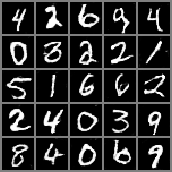

epoch: 11/300, batch: 410/600, G_loss: 0.9472375512123108, D_loss: (0.015386424958705902, 0.8028784990310669)
epoch: 11/300, batch: 420/600, G_loss: 4.744737148284912, D_loss: (0.18089735507965088, 0.014982709661126137)
epoch: 11/300, batch: 430/600, G_loss: 2.792130708694458, D_loss: (0.2209697663784027, 0.10542935132980347)
epoch: 11/300, batch: 440/600, G_loss: 2.889056921005249, D_loss: (0.024438466876745224, 0.09125174582004547)
epoch: 11/300, batch: 450/600, G_loss: 3.3074593544006348, D_loss: (0.04673203453421593, 0.059053946286439896)
epoch: 11/300, batch: 460/600, G_loss: 3.3483099937438965, D_loss: (0.11612211167812347, 0.0675991103053093)
epoch: 11/300, batch: 470/600, G_loss: 4.277474880218506, D_loss: (0.09311116486787796, 0.024738259613513947)
epoch: 11/300, batch: 480/600, G_loss: 2.811781883239746, D_loss: (0.030449621379375458, 0.10234086960554123)
epoch: 11/300, batch: 490/600, G_loss: 4.151730537414551, D_loss: (0.6317484378814697, 0.03640676662325859)
epoch: 11/300,

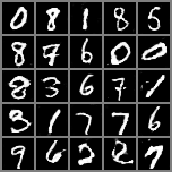

epoch: 11/300, batch: 510/600, G_loss: 5.815208911895752, D_loss: (0.2150782197713852, 0.00915935356169939)
epoch: 11/300, batch: 520/600, G_loss: 1.6669611930847168, D_loss: (0.015342842787504196, 0.29435038566589355)
epoch: 11/300, batch: 530/600, G_loss: 1.396571397781372, D_loss: (0.032980699092149734, 0.5305254459381104)
epoch: 11/300, batch: 540/600, G_loss: 6.107635974884033, D_loss: (1.147814154624939, 0.006220730487257242)
epoch: 11/300, batch: 550/600, G_loss: 3.508355140686035, D_loss: (0.2002011090517044, 0.07134845852851868)
epoch: 11/300, batch: 560/600, G_loss: 2.1357123851776123, D_loss: (0.14920318126678467, 0.19289995729923248)
epoch: 11/300, batch: 570/600, G_loss: 1.6761033535003662, D_loss: (0.06611315906047821, 0.30369120836257935)
epoch: 11/300, batch: 580/600, G_loss: 2.0926406383514404, D_loss: (0.06243380531668663, 0.2002483606338501)
epoch: 11/300, batch: 590/600, G_loss: 2.909996747970581, D_loss: (0.015326348133385181, 0.11115139722824097)
epoch: 12/300, ba

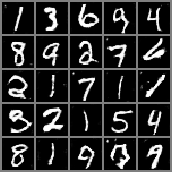

epoch: 12/300, batch: 10/600, G_loss: 2.671590805053711, D_loss: (0.13480731844902039, 0.15284086763858795)
epoch: 12/300, batch: 20/600, G_loss: 0.7300031185150146, D_loss: (0.0035162579733878374, 1.0143263339996338)
epoch: 12/300, batch: 30/600, G_loss: 1.766972303390503, D_loss: (0.08012380450963974, 0.2791561782360077)
epoch: 12/300, batch: 40/600, G_loss: 4.241828441619873, D_loss: (0.5942332744598389, 0.026636458933353424)
epoch: 12/300, batch: 50/600, G_loss: 1.452420949935913, D_loss: (0.06008131429553032, 0.525479257106781)
epoch: 12/300, batch: 60/600, G_loss: 1.7239108085632324, D_loss: (0.13270434737205505, 0.3234596252441406)
epoch: 12/300, batch: 70/600, G_loss: 2.32690691947937, D_loss: (0.03976623713970184, 0.16102857887744904)
epoch: 12/300, batch: 80/600, G_loss: 4.1540727615356445, D_loss: (0.05601115524768829, 0.028597993776202202)
epoch: 12/300, batch: 90/600, G_loss: 1.4628039598464966, D_loss: (0.015219160355627537, 0.4103986322879791)
epoch: 12/300, batch: 100/6

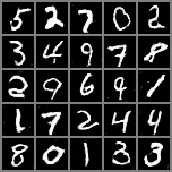

epoch: 12/300, batch: 110/600, G_loss: 2.3198037147521973, D_loss: (0.025609640404582024, 0.18000464141368866)
epoch: 12/300, batch: 120/600, G_loss: 6.708707332611084, D_loss: (1.1461970806121826, 0.0037014412228018045)
epoch: 12/300, batch: 130/600, G_loss: 2.97103214263916, D_loss: (0.06790190935134888, 0.09897357225418091)
epoch: 12/300, batch: 140/600, G_loss: 8.946927070617676, D_loss: (2.1634559631347656, 0.00046700675738975406)
epoch: 12/300, batch: 150/600, G_loss: 3.491196870803833, D_loss: (0.8955875635147095, 0.05427679046988487)
epoch: 12/300, batch: 160/600, G_loss: 1.821702241897583, D_loss: (0.1752799153327942, 0.30524855852127075)
epoch: 12/300, batch: 170/600, G_loss: 1.0584739446640015, D_loss: (0.06433811038732529, 0.5784047842025757)
epoch: 12/300, batch: 180/600, G_loss: 2.728316068649292, D_loss: (0.10771718621253967, 0.10900307446718216)
epoch: 12/300, batch: 190/600, G_loss: 1.1611888408660889, D_loss: (0.03656268119812012, 0.7660614848136902)
epoch: 12/300, ba

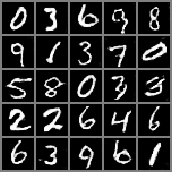

epoch: 12/300, batch: 210/600, G_loss: 3.0510799884796143, D_loss: (0.21863345801830292, 0.08681181818246841)
epoch: 12/300, batch: 220/600, G_loss: 3.602388620376587, D_loss: (0.15830212831497192, 0.03873021900653839)
epoch: 12/300, batch: 230/600, G_loss: 3.3564980030059814, D_loss: (0.235995352268219, 0.060435499995946884)
epoch: 12/300, batch: 240/600, G_loss: 1.1301074028015137, D_loss: (0.017901653423905373, 0.5612678527832031)
epoch: 12/300, batch: 250/600, G_loss: 2.7625856399536133, D_loss: (0.4019477963447571, 0.12932313978672028)
epoch: 12/300, batch: 260/600, G_loss: 5.360426425933838, D_loss: (0.4026690721511841, 0.009345660917460918)
epoch: 12/300, batch: 270/600, G_loss: 3.4494800567626953, D_loss: (0.03242000937461853, 0.05692146718502045)
epoch: 12/300, batch: 280/600, G_loss: 2.123317003250122, D_loss: (0.035730376839637756, 0.22442907094955444)
epoch: 12/300, batch: 290/600, G_loss: 3.142213821411133, D_loss: (0.21620510518550873, 0.07434534281492233)
epoch: 12/300, 

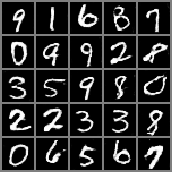

epoch: 12/300, batch: 310/600, G_loss: 2.7105705738067627, D_loss: (0.0964493677020073, 0.11207055300474167)
epoch: 12/300, batch: 320/600, G_loss: 4.931943893432617, D_loss: (0.04444287717342377, 0.013544530607759953)
epoch: 12/300, batch: 330/600, G_loss: 5.870067596435547, D_loss: (0.24036487936973572, 0.005642763338983059)
epoch: 12/300, batch: 340/600, G_loss: 2.7144100666046143, D_loss: (0.02321486547589302, 0.11778269708156586)
epoch: 12/300, batch: 350/600, G_loss: 3.9604172706604004, D_loss: (0.048067908734083176, 0.04003693535923958)
epoch: 12/300, batch: 360/600, G_loss: 6.200092315673828, D_loss: (0.22000308334827423, 0.0040776790119707584)
epoch: 12/300, batch: 370/600, G_loss: 3.234975576400757, D_loss: (0.02121972292661667, 0.07135912775993347)
epoch: 12/300, batch: 380/600, G_loss: 2.8539440631866455, D_loss: (0.019928930327296257, 0.10312830656766891)
epoch: 12/300, batch: 390/600, G_loss: 2.8176934719085693, D_loss: (0.012661853805184364, 0.09908009320497513)
epoch: 1

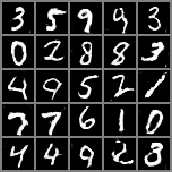

epoch: 12/300, batch: 410/600, G_loss: 2.75095272064209, D_loss: (0.07869477570056915, 0.09957253187894821)
epoch: 12/300, batch: 420/600, G_loss: 2.3019776344299316, D_loss: (0.009089312516152859, 0.1778714805841446)
epoch: 12/300, batch: 430/600, G_loss: 4.303140640258789, D_loss: (0.09431395679712296, 0.028135932981967926)
epoch: 12/300, batch: 440/600, G_loss: 2.766981840133667, D_loss: (0.018551310524344444, 0.10806583613157272)
epoch: 12/300, batch: 450/600, G_loss: 2.3842294216156006, D_loss: (0.117978535592556, 0.208423912525177)
epoch: 12/300, batch: 460/600, G_loss: 3.3658413887023926, D_loss: (0.07315818965435028, 0.06046704202890396)
epoch: 12/300, batch: 470/600, G_loss: 1.1991347074508667, D_loss: (0.006462465040385723, 0.5527088046073914)
epoch: 12/300, batch: 480/600, G_loss: 4.745265007019043, D_loss: (0.2109520137310028, 0.018683748319745064)
epoch: 12/300, batch: 490/600, G_loss: 1.7615197896957397, D_loss: (0.016072221100330353, 0.3063109517097473)
epoch: 12/300, ba

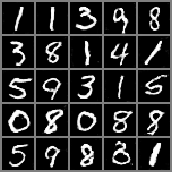

epoch: 12/300, batch: 510/600, G_loss: 4.9776506423950195, D_loss: (0.7155473232269287, 0.012825872749090195)
epoch: 12/300, batch: 520/600, G_loss: 1.3718653917312622, D_loss: (0.018791697919368744, 0.5021817684173584)
epoch: 12/300, batch: 530/600, G_loss: 3.978080987930298, D_loss: (0.3668014407157898, 0.04143613949418068)
epoch: 12/300, batch: 540/600, G_loss: 4.638723373413086, D_loss: (0.08206681162118912, 0.027996810153126717)
epoch: 12/300, batch: 550/600, G_loss: 4.33030891418457, D_loss: (0.042170025408267975, 0.030991993844509125)
epoch: 12/300, batch: 560/600, G_loss: 2.5829522609710693, D_loss: (0.03604196757078171, 0.1408008635044098)
epoch: 12/300, batch: 570/600, G_loss: 3.309382677078247, D_loss: (0.02265625260770321, 0.06967780739068985)
epoch: 12/300, batch: 580/600, G_loss: 1.5991023778915405, D_loss: (0.0074797021225094795, 0.3886268138885498)
epoch: 12/300, batch: 590/600, G_loss: 2.0600905418395996, D_loss: (0.015396591275930405, 0.254474937915802)
epoch: 13/300,

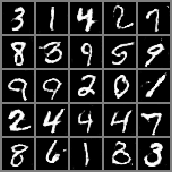

epoch: 13/300, batch: 10/600, G_loss: 4.1443772315979, D_loss: (0.399023175239563, 0.03143233805894852)
epoch: 13/300, batch: 20/600, G_loss: 2.302112340927124, D_loss: (0.26138409972190857, 0.18232372403144836)
epoch: 13/300, batch: 30/600, G_loss: 1.5745021104812622, D_loss: (0.043967362493276596, 0.39254096150398254)
epoch: 13/300, batch: 40/600, G_loss: 4.640396595001221, D_loss: (0.4682185649871826, 0.017632558941841125)
epoch: 13/300, batch: 50/600, G_loss: 4.6332106590271, D_loss: (0.11826737225055695, 0.01916142925620079)
epoch: 13/300, batch: 60/600, G_loss: 1.6657052040100098, D_loss: (0.0106102479621768, 0.3671669363975525)
epoch: 13/300, batch: 70/600, G_loss: 2.896066665649414, D_loss: (0.05720358341932297, 0.09992765635251999)
epoch: 13/300, batch: 80/600, G_loss: 4.4678754806518555, D_loss: (0.05954036861658096, 0.024118706583976746)
epoch: 13/300, batch: 90/600, G_loss: 3.362381935119629, D_loss: (0.029597079381346703, 0.05355319380760193)
epoch: 13/300, batch: 100/600,

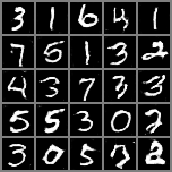

epoch: 13/300, batch: 110/600, G_loss: 2.6527798175811768, D_loss: (0.017123611643910408, 0.14088097214698792)
epoch: 13/300, batch: 120/600, G_loss: 4.552212715148926, D_loss: (0.15560181438922882, 0.017314640805125237)
epoch: 13/300, batch: 130/600, G_loss: 1.7577377557754517, D_loss: (0.0037129244301468134, 0.3617497384548187)
epoch: 13/300, batch: 140/600, G_loss: 2.7154932022094727, D_loss: (0.20415250957012177, 0.14309915900230408)
epoch: 13/300, batch: 150/600, G_loss: 4.443673610687256, D_loss: (0.418605238199234, 0.030863890424370766)
epoch: 13/300, batch: 160/600, G_loss: 2.963736057281494, D_loss: (0.03922322764992714, 0.08839641511440277)
epoch: 13/300, batch: 170/600, G_loss: 4.103812217712402, D_loss: (0.13496574759483337, 0.02868901751935482)
epoch: 13/300, batch: 180/600, G_loss: 4.602475643157959, D_loss: (0.16816964745521545, 0.022339656949043274)
epoch: 13/300, batch: 190/600, G_loss: 2.9355084896087646, D_loss: (0.04366882145404816, 0.11130663007497787)
epoch: 13/30

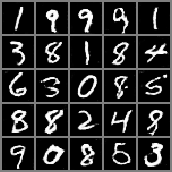

epoch: 13/300, batch: 210/600, G_loss: 3.497236728668213, D_loss: (0.17891612648963928, 0.05686941742897034)
epoch: 13/300, batch: 220/600, G_loss: 4.635329723358154, D_loss: (0.09902974218130112, 0.019656596705317497)
epoch: 13/300, batch: 230/600, G_loss: 4.021782398223877, D_loss: (0.12860971689224243, 0.032609209418296814)
epoch: 13/300, batch: 240/600, G_loss: 4.617177963256836, D_loss: (0.06854765117168427, 0.019024183973670006)
epoch: 13/300, batch: 250/600, G_loss: 3.4350404739379883, D_loss: (0.03551778569817543, 0.05964233726263046)
epoch: 13/300, batch: 260/600, G_loss: 4.674676418304443, D_loss: (0.06982897967100143, 0.014984620735049248)
epoch: 13/300, batch: 270/600, G_loss: 3.8345513343811035, D_loss: (0.06431061774492264, 0.043222054839134216)
epoch: 13/300, batch: 280/600, G_loss: 4.297471046447754, D_loss: (0.04604092612862587, 0.028051801025867462)
epoch: 13/300, batch: 290/600, G_loss: 3.9110159873962402, D_loss: (0.05865976959466934, 0.03740563243627548)
epoch: 13/

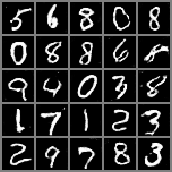

epoch: 13/300, batch: 310/600, G_loss: 2.9586875438690186, D_loss: (0.06266338378190994, 0.09911300987005234)
epoch: 13/300, batch: 320/600, G_loss: 1.9324008226394653, D_loss: (0.07316896319389343, 0.3788577914237976)
epoch: 13/300, batch: 330/600, G_loss: 2.198192596435547, D_loss: (0.030580412596464157, 0.19714680314064026)
epoch: 13/300, batch: 340/600, G_loss: 3.9358859062194824, D_loss: (0.016282126307487488, 0.03430021554231644)
epoch: 13/300, batch: 350/600, G_loss: 0.6212196350097656, D_loss: (0.010188189335167408, 1.0748894214630127)
epoch: 13/300, batch: 360/600, G_loss: 4.8264641761779785, D_loss: (0.6403729915618896, 0.014389045536518097)
epoch: 13/300, batch: 370/600, G_loss: 3.389012336730957, D_loss: (0.596331775188446, 0.0637490525841713)
epoch: 13/300, batch: 380/600, G_loss: 2.567699670791626, D_loss: (0.04651869833469391, 0.17815345525741577)
epoch: 13/300, batch: 390/600, G_loss: 1.8932256698608398, D_loss: (0.017708616331219673, 0.2780284285545349)
epoch: 13/300, 

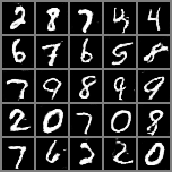

epoch: 13/300, batch: 410/600, G_loss: 1.1646572351455688, D_loss: (0.035755496472120285, 0.5742856860160828)
epoch: 13/300, batch: 420/600, G_loss: 2.4694325923919678, D_loss: (0.22554096579551697, 0.17529332637786865)
epoch: 13/300, batch: 430/600, G_loss: 3.9052929878234863, D_loss: (0.04177652299404144, 0.04199467599391937)
epoch: 13/300, batch: 440/600, G_loss: 4.487346172332764, D_loss: (0.3852657079696655, 0.027724996209144592)
epoch: 13/300, batch: 450/600, G_loss: 1.4722034931182861, D_loss: (0.0468539334833622, 0.40677958726882935)
epoch: 13/300, batch: 460/600, G_loss: 2.0188992023468018, D_loss: (0.0200977586209774, 0.2362973988056183)
epoch: 13/300, batch: 470/600, G_loss: 3.821657180786133, D_loss: (0.08181624114513397, 0.04282539710402489)
epoch: 13/300, batch: 480/600, G_loss: 2.1844542026519775, D_loss: (0.01421861257404089, 0.2172202318906784)
epoch: 13/300, batch: 490/600, G_loss: 4.926076889038086, D_loss: (0.1655621975660324, 0.012443920597434044)
epoch: 13/300, ba

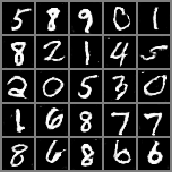

epoch: 13/300, batch: 510/600, G_loss: 5.236761569976807, D_loss: (0.05046536400914192, 0.01068425178527832)
epoch: 13/300, batch: 520/600, G_loss: 8.178557395935059, D_loss: (0.6557077169418335, 0.0009895394323393703)
epoch: 13/300, batch: 530/600, G_loss: 3.968510627746582, D_loss: (0.26365676522254944, 0.0394979789853096)
epoch: 13/300, batch: 540/600, G_loss: 1.5128960609436035, D_loss: (0.01616198942065239, 0.4697956442832947)
epoch: 13/300, batch: 550/600, G_loss: 3.583207368850708, D_loss: (0.036201536655426025, 0.04733093082904816)
epoch: 13/300, batch: 560/600, G_loss: 5.471574783325195, D_loss: (1.1622111797332764, 0.007776436861604452)
epoch: 13/300, batch: 570/600, G_loss: 3.9678163528442383, D_loss: (0.32887500524520874, 0.04610737785696983)
epoch: 13/300, batch: 580/600, G_loss: 2.420370578765869, D_loss: (0.03595656529068947, 0.17535817623138428)
epoch: 13/300, batch: 590/600, G_loss: 2.200918674468994, D_loss: (0.3010091185569763, 0.20813177525997162)
epoch: 14/300, bat

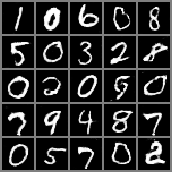

epoch: 14/300, batch: 10/600, G_loss: 4.098615646362305, D_loss: (0.8407612442970276, 0.042244669049978256)
epoch: 14/300, batch: 20/600, G_loss: 1.9414979219436646, D_loss: (0.08507991582155228, 0.2462536245584488)
epoch: 14/300, batch: 30/600, G_loss: 2.6999707221984863, D_loss: (0.01968037150800228, 0.21151016652584076)
epoch: 14/300, batch: 40/600, G_loss: 3.1941263675689697, D_loss: (0.057443033903837204, 0.07715616375207901)
epoch: 14/300, batch: 50/600, G_loss: 4.60444450378418, D_loss: (0.040847066789865494, 0.02839997597038746)
epoch: 14/300, batch: 60/600, G_loss: 3.57817006111145, D_loss: (0.03365721553564072, 0.05323450639843941)
epoch: 14/300, batch: 70/600, G_loss: 5.045913219451904, D_loss: (0.04172724112868309, 0.012636332772672176)
epoch: 14/300, batch: 80/600, G_loss: 3.510593891143799, D_loss: (0.0032918897923082113, 0.0540553443133831)
epoch: 14/300, batch: 90/600, G_loss: 4.154766082763672, D_loss: (0.03796939179301262, 0.03317626565694809)
epoch: 14/300, batch: 10

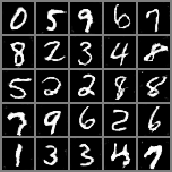

epoch: 14/300, batch: 110/600, G_loss: 2.783689260482788, D_loss: (0.03571266308426857, 0.11494486033916473)
epoch: 14/300, batch: 120/600, G_loss: 4.199023246765137, D_loss: (0.17205891013145447, 0.026998553425073624)
epoch: 14/300, batch: 130/600, G_loss: 2.6745858192443848, D_loss: (0.03158119320869446, 0.12281977385282516)
epoch: 14/300, batch: 140/600, G_loss: 7.724635601043701, D_loss: (1.1170549392700195, 0.0010806912323459983)
epoch: 14/300, batch: 150/600, G_loss: 4.082716941833496, D_loss: (0.42540398240089417, 0.04291868582367897)
epoch: 14/300, batch: 160/600, G_loss: 5.611268997192383, D_loss: (0.1085260808467865, 0.0066267456859350204)
epoch: 14/300, batch: 170/600, G_loss: 3.1934704780578613, D_loss: (0.032569725066423416, 0.07063791900873184)
epoch: 14/300, batch: 180/600, G_loss: 4.299055576324463, D_loss: (0.015041297301650047, 0.02342480979859829)
epoch: 14/300, batch: 190/600, G_loss: 3.00819730758667, D_loss: (0.03758823499083519, 0.09639760106801987)
epoch: 14/300

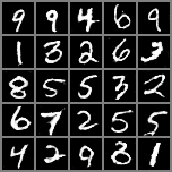

epoch: 14/300, batch: 210/600, G_loss: 3.9245386123657227, D_loss: (0.0334632582962513, 0.036700524389743805)
epoch: 14/300, batch: 220/600, G_loss: 2.997276544570923, D_loss: (0.0036964600440114737, 0.0854349434375763)
epoch: 14/300, batch: 230/600, G_loss: 5.115230560302734, D_loss: (0.012178569100797176, 0.00967163871973753)
epoch: 14/300, batch: 240/600, G_loss: 4.904702186584473, D_loss: (0.18315058946609497, 0.01783592812716961)
epoch: 14/300, batch: 250/600, G_loss: 3.7048299312591553, D_loss: (0.2125268131494522, 0.05021332576870918)
epoch: 14/300, batch: 260/600, G_loss: 2.8730645179748535, D_loss: (0.05538363382220268, 0.11939270794391632)
epoch: 14/300, batch: 270/600, G_loss: 4.441163063049316, D_loss: (0.0713280662894249, 0.02565249241888523)
epoch: 14/300, batch: 280/600, G_loss: 5.242115497589111, D_loss: (0.26124846935272217, 0.011699672788381577)
epoch: 14/300, batch: 290/600, G_loss: 3.8882498741149902, D_loss: (0.27323055267333984, 0.03626829758286476)
epoch: 14/300,

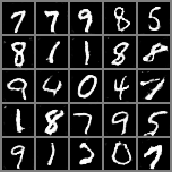

epoch: 14/300, batch: 310/600, G_loss: 3.275376558303833, D_loss: (0.012114268727600574, 0.06677277386188507)
epoch: 14/300, batch: 320/600, G_loss: 3.415278911590576, D_loss: (0.08467338234186172, 0.05777224525809288)
epoch: 14/300, batch: 330/600, G_loss: 5.168797016143799, D_loss: (0.028563957661390305, 0.008947405032813549)
epoch: 14/300, batch: 340/600, G_loss: 5.176394462585449, D_loss: (0.0182493906468153, 0.009290793910622597)
epoch: 14/300, batch: 350/600, G_loss: 3.2939460277557373, D_loss: (0.00852812360972166, 0.071539506316185)
epoch: 14/300, batch: 360/600, G_loss: 3.3348734378814697, D_loss: (0.148777037858963, 0.07948021590709686)
epoch: 14/300, batch: 370/600, G_loss: 6.350338935852051, D_loss: (1.040718674659729, 0.007987159304320812)
epoch: 14/300, batch: 380/600, G_loss: 1.6098233461380005, D_loss: (0.13535800576210022, 0.5129877924919128)
epoch: 14/300, batch: 390/600, G_loss: 3.8812973499298096, D_loss: (0.16902002692222595, 0.03646691143512726)
epoch: 14/300, bat

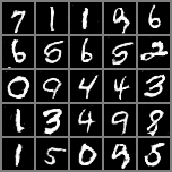

epoch: 14/300, batch: 410/600, G_loss: 3.8084213733673096, D_loss: (0.02358744665980339, 0.03642939031124115)
epoch: 14/300, batch: 420/600, G_loss: 6.129952430725098, D_loss: (0.23169441521167755, 0.0043800706043839455)
epoch: 14/300, batch: 430/600, G_loss: 4.069366455078125, D_loss: (0.020045408979058266, 0.037182580679655075)
epoch: 14/300, batch: 440/600, G_loss: 1.9095286130905151, D_loss: (0.22471006214618683, 0.3355042338371277)
epoch: 14/300, batch: 450/600, G_loss: 5.208927154541016, D_loss: (0.5005491375923157, 0.015255041420459747)
epoch: 14/300, batch: 460/600, G_loss: 0.8133496642112732, D_loss: (0.009392419829964638, 1.0912508964538574)
epoch: 14/300, batch: 470/600, G_loss: 3.0589380264282227, D_loss: (0.07829160988330841, 0.08798673748970032)
epoch: 14/300, batch: 480/600, G_loss: 1.1137875318527222, D_loss: (0.0023101414553821087, 1.016662359237671)
epoch: 14/300, batch: 490/600, G_loss: 1.7891992330551147, D_loss: (0.06048664450645447, 0.3419029116630554)
epoch: 14/3

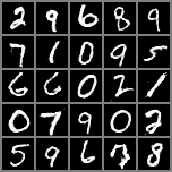

epoch: 14/300, batch: 510/600, G_loss: 3.027143955230713, D_loss: (0.0887678787112236, 0.08065212517976761)
epoch: 14/300, batch: 520/600, G_loss: 4.500662326812744, D_loss: (0.13417258858680725, 0.026779549196362495)
epoch: 14/300, batch: 530/600, G_loss: 2.9359405040740967, D_loss: (0.10604208707809448, 0.10324179381132126)
epoch: 14/300, batch: 540/600, G_loss: 2.1345317363739014, D_loss: (0.010006018914282322, 0.20627182722091675)
epoch: 14/300, batch: 550/600, G_loss: 0.6041340231895447, D_loss: (0.0009407743928022683, 1.2661585807800293)
epoch: 14/300, batch: 560/600, G_loss: 1.7179850339889526, D_loss: (0.030182475224137306, 0.32619068026542664)
epoch: 14/300, batch: 570/600, G_loss: 3.382526159286499, D_loss: (0.04477529972791672, 0.0709097608923912)
epoch: 14/300, batch: 580/600, G_loss: 3.3848819732666016, D_loss: (0.253017395734787, 0.09326369315385818)
epoch: 14/300, batch: 590/600, G_loss: 0.7851192951202393, D_loss: (0.005157462786883116, 0.8517912030220032)
epoch: 15/300

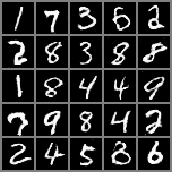

epoch: 15/300, batch: 10/600, G_loss: 6.176961898803711, D_loss: (0.5426918864250183, 0.010469295084476471)
epoch: 15/300, batch: 20/600, G_loss: 4.461942672729492, D_loss: (0.6132117509841919, 0.023877350613474846)
epoch: 15/300, batch: 30/600, G_loss: 2.3789961338043213, D_loss: (0.018946677446365356, 0.1659032255411148)
epoch: 15/300, batch: 40/600, G_loss: 4.463919162750244, D_loss: (0.17485564947128296, 0.024014027789235115)
epoch: 15/300, batch: 50/600, G_loss: 1.2477182149887085, D_loss: (0.057182084769010544, 0.5573334693908691)
epoch: 15/300, batch: 60/600, G_loss: 3.6077017784118652, D_loss: (0.07356008887290955, 0.04931853711605072)
epoch: 15/300, batch: 70/600, G_loss: 3.3467185497283936, D_loss: (0.16007907688617706, 0.05693972483277321)
epoch: 15/300, batch: 80/600, G_loss: 1.2741658687591553, D_loss: (0.07664641737937927, 0.5084297060966492)
epoch: 15/300, batch: 90/600, G_loss: 3.928964138031006, D_loss: (0.7785620093345642, 0.04802580922842026)
epoch: 15/300, batch: 10

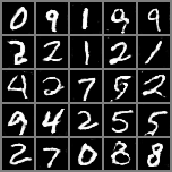

epoch: 15/300, batch: 110/600, G_loss: 2.625209093093872, D_loss: (0.010249512270092964, 0.11744260787963867)
epoch: 15/300, batch: 120/600, G_loss: 3.8193182945251465, D_loss: (0.1039188951253891, 0.04278964176774025)
epoch: 15/300, batch: 130/600, G_loss: 2.4703831672668457, D_loss: (0.00920845940709114, 0.1451951116323471)
epoch: 15/300, batch: 140/600, G_loss: 2.9327890872955322, D_loss: (0.25258079171180725, 0.08501532673835754)
epoch: 15/300, batch: 150/600, G_loss: 2.4576897621154785, D_loss: (0.040348559617996216, 0.15818104147911072)
epoch: 15/300, batch: 160/600, G_loss: 3.6604247093200684, D_loss: (0.039556872099637985, 0.05062121897935867)
epoch: 15/300, batch: 170/600, G_loss: 2.5947787761688232, D_loss: (0.056873247027397156, 0.15355107188224792)
epoch: 15/300, batch: 180/600, G_loss: 2.9012458324432373, D_loss: (0.02223695069551468, 0.13440115749835968)
epoch: 15/300, batch: 190/600, G_loss: 3.5085079669952393, D_loss: (0.2182687520980835, 0.05431488901376724)
epoch: 15/

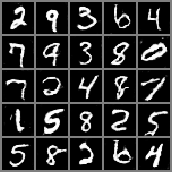

epoch: 15/300, batch: 210/600, G_loss: 6.51181697845459, D_loss: (0.700116753578186, 0.0030931117944419384)
epoch: 15/300, batch: 220/600, G_loss: 4.731324195861816, D_loss: (0.2346542328596115, 0.020813021808862686)
epoch: 15/300, batch: 230/600, G_loss: 2.0498874187469482, D_loss: (0.042100127786397934, 0.21595947444438934)
epoch: 15/300, batch: 240/600, G_loss: 5.040149688720703, D_loss: (0.10297179222106934, 0.013360097073018551)
epoch: 15/300, batch: 250/600, G_loss: 3.5801100730895996, D_loss: (0.04964939132332802, 0.050355326384305954)
epoch: 15/300, batch: 260/600, G_loss: 4.8448944091796875, D_loss: (0.07913704216480255, 0.014772479422390461)
epoch: 15/300, batch: 270/600, G_loss: 3.0225512981414795, D_loss: (0.02045581117272377, 0.09291359037160873)
epoch: 15/300, batch: 280/600, G_loss: 2.84321928024292, D_loss: (0.11468464881181717, 0.11226148903369904)
epoch: 15/300, batch: 290/600, G_loss: 2.1163384914398193, D_loss: (0.08906394988298416, 0.19999557733535767)
epoch: 15/30

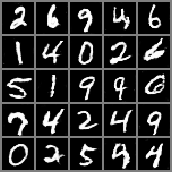

epoch: 15/300, batch: 310/600, G_loss: 2.7914023399353027, D_loss: (0.06647884100675583, 0.11004534363746643)
epoch: 15/300, batch: 320/600, G_loss: 0.6702980995178223, D_loss: (0.0007054515299387276, 1.1330946683883667)
epoch: 15/300, batch: 330/600, G_loss: 2.3357608318328857, D_loss: (0.02828107587993145, 0.15249355137348175)
epoch: 15/300, batch: 340/600, G_loss: 1.326810598373413, D_loss: (0.001841563731431961, 0.45987579226493835)
epoch: 15/300, batch: 350/600, G_loss: 3.759883403778076, D_loss: (0.029869133606553078, 0.040848731994628906)
epoch: 15/300, batch: 360/600, G_loss: 4.082612037658691, D_loss: (0.0147561552003026, 0.030237775295972824)
epoch: 15/300, batch: 370/600, G_loss: 6.2697978019714355, D_loss: (0.15429706871509552, 0.003113109851256013)
epoch: 15/300, batch: 380/600, G_loss: 3.5937201976776123, D_loss: (0.07080647349357605, 0.0465821735560894)
epoch: 15/300, batch: 390/600, G_loss: 5.027688980102539, D_loss: (0.061168551445007324, 0.010329073294997215)
epoch: 1

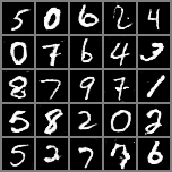

epoch: 15/300, batch: 410/600, G_loss: 4.696115016937256, D_loss: (0.0276526790112257, 0.01762494072318077)
epoch: 15/300, batch: 420/600, G_loss: 5.324102878570557, D_loss: (0.09730762243270874, 0.010155152529478073)
epoch: 15/300, batch: 430/600, G_loss: 1.1848564147949219, D_loss: (0.016666853800415993, 0.6099205613136292)
epoch: 15/300, batch: 440/600, G_loss: 2.4624741077423096, D_loss: (0.07039130479097366, 0.1808086335659027)
epoch: 15/300, batch: 450/600, G_loss: 4.130850315093994, D_loss: (0.041593436151742935, 0.03213920816779137)
epoch: 15/300, batch: 460/600, G_loss: 6.436530590057373, D_loss: (0.9713790416717529, 0.003599808318540454)
epoch: 15/300, batch: 470/600, G_loss: 5.128262996673584, D_loss: (0.08445900678634644, 0.016123220324516296)
epoch: 15/300, batch: 480/600, G_loss: 1.6412501335144043, D_loss: (0.023307926952838898, 0.3244915008544922)
epoch: 15/300, batch: 490/600, G_loss: 5.39924430847168, D_loss: (0.1775328516960144, 0.008316298946738243)
epoch: 15/300, b

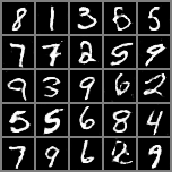

epoch: 15/300, batch: 510/600, G_loss: 5.200656890869141, D_loss: (0.025475122034549713, 0.00942869670689106)
epoch: 15/300, batch: 520/600, G_loss: 7.520866870880127, D_loss: (0.6233962178230286, 0.0018254716414958239)
epoch: 15/300, batch: 530/600, G_loss: 4.223831653594971, D_loss: (0.0806795284152031, 0.031228655949234962)
epoch: 15/300, batch: 540/600, G_loss: 1.8009223937988281, D_loss: (0.011569950729608536, 0.2750120460987091)
epoch: 15/300, batch: 550/600, G_loss: 3.107501268386841, D_loss: (0.02091887965798378, 0.07093778252601624)
epoch: 15/300, batch: 560/600, G_loss: 4.634679317474365, D_loss: (0.01061535719782114, 0.018629658967256546)
epoch: 15/300, batch: 570/600, G_loss: 2.8335142135620117, D_loss: (0.004730353131890297, 0.10511777549982071)
epoch: 15/300, batch: 580/600, G_loss: 2.9986279010772705, D_loss: (0.015361212193965912, 0.10725928097963333)
epoch: 15/300, batch: 590/600, G_loss: 4.694024562835693, D_loss: (0.015004894696176052, 0.01821603812277317)
epoch: 16/

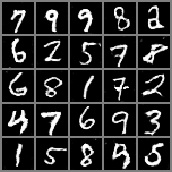

epoch: 16/300, batch: 10/600, G_loss: 0.8621737957000732, D_loss: (0.0019607837311923504, 0.8857437968254089)
epoch: 16/300, batch: 20/600, G_loss: 3.0680313110351562, D_loss: (0.014976758509874344, 0.07284431159496307)
epoch: 16/300, batch: 30/600, G_loss: 4.837038516998291, D_loss: (0.15380534529685974, 0.01763983629643917)
epoch: 16/300, batch: 40/600, G_loss: 4.444451808929443, D_loss: (0.13031351566314697, 0.019725237041711807)
epoch: 16/300, batch: 50/600, G_loss: 4.224430084228516, D_loss: (0.060169946402311325, 0.027203822508454323)
epoch: 16/300, batch: 60/600, G_loss: 4.109766006469727, D_loss: (0.060081228613853455, 0.030588684603571892)
epoch: 16/300, batch: 70/600, G_loss: 3.366941213607788, D_loss: (0.006593429017812014, 0.06846324354410172)
epoch: 16/300, batch: 80/600, G_loss: 4.827104091644287, D_loss: (0.01466130930930376, 0.015612601302564144)
epoch: 16/300, batch: 90/600, G_loss: 4.632556915283203, D_loss: (0.016607802361249924, 0.023591136559844017)
epoch: 16/300, 

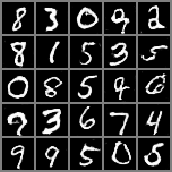

epoch: 16/300, batch: 110/600, G_loss: 5.4573655128479, D_loss: (0.00471154460683465, 0.011055313050746918)
epoch: 16/300, batch: 120/600, G_loss: 4.88552713394165, D_loss: (0.013687141239643097, 0.016467751935124397)
epoch: 16/300, batch: 130/600, G_loss: 4.798230171203613, D_loss: (0.032358814030885696, 0.015616020187735558)
epoch: 16/300, batch: 140/600, G_loss: 3.8823578357696533, D_loss: (0.01672598347067833, 0.03775591775774956)
epoch: 16/300, batch: 150/600, G_loss: 4.582258224487305, D_loss: (0.01793518476188183, 0.02213677205145359)
epoch: 16/300, batch: 160/600, G_loss: 3.673344373703003, D_loss: (0.014270155690610409, 0.04466937854886055)
epoch: 16/300, batch: 170/600, G_loss: 1.393530249595642, D_loss: (0.14866547286510468, 0.6080407500267029)
epoch: 16/300, batch: 180/600, G_loss: 4.0047407150268555, D_loss: (1.0503108501434326, 0.04230187460780144)
epoch: 16/300, batch: 190/600, G_loss: 1.4169340133666992, D_loss: (0.0507207028567791, 0.4782339334487915)
epoch: 16/300, ba

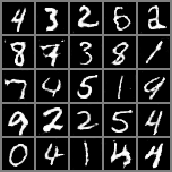

epoch: 16/300, batch: 210/600, G_loss: 0.8985819220542908, D_loss: (0.00880351010710001, 0.9835652112960815)
epoch: 16/300, batch: 220/600, G_loss: 2.3828587532043457, D_loss: (0.0676843523979187, 0.1685512512922287)
epoch: 16/300, batch: 230/600, G_loss: 2.220808744430542, D_loss: (0.017132490873336792, 0.22876371443271637)
epoch: 16/300, batch: 240/600, G_loss: 3.5052907466888428, D_loss: (0.32697001099586487, 0.07665906101465225)
epoch: 16/300, batch: 250/600, G_loss: 1.768947720527649, D_loss: (0.1184333860874176, 0.37468913197517395)
epoch: 16/300, batch: 260/600, G_loss: 4.6705241203308105, D_loss: (0.2049914002418518, 0.027992254123091698)
epoch: 16/300, batch: 270/600, G_loss: 2.08396577835083, D_loss: (0.0036266751121729612, 0.23413605988025665)
epoch: 16/300, batch: 280/600, G_loss: 0.9935092329978943, D_loss: (0.019175192341208458, 0.7862213850021362)
epoch: 16/300, batch: 290/600, G_loss: 0.4815862774848938, D_loss: (0.02691776677966118, 1.3989523649215698)
epoch: 16/300, b

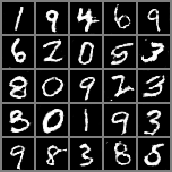

epoch: 16/300, batch: 310/600, G_loss: 2.6794304847717285, D_loss: (0.06934994459152222, 0.11213862150907516)
epoch: 16/300, batch: 320/600, G_loss: 7.341510772705078, D_loss: (1.0815407037734985, 0.0020677908323705196)
epoch: 16/300, batch: 330/600, G_loss: 7.168054103851318, D_loss: (1.7340672016143799, 0.013969795778393745)
epoch: 16/300, batch: 340/600, G_loss: 1.389847993850708, D_loss: (0.12181303650140762, 0.528469979763031)
epoch: 16/300, batch: 350/600, G_loss: 2.687199115753174, D_loss: (0.029675109311938286, 0.12234725058078766)
epoch: 16/300, batch: 360/600, G_loss: 2.788226842880249, D_loss: (0.06293844431638718, 0.10120036453008652)
epoch: 16/300, batch: 370/600, G_loss: 4.167937755584717, D_loss: (0.13730445504188538, 0.02604488842189312)
epoch: 16/300, batch: 380/600, G_loss: 3.506154775619507, D_loss: (0.12069740891456604, 0.05856931582093239)
epoch: 16/300, batch: 390/600, G_loss: 3.257171392440796, D_loss: (0.18538135290145874, 0.07393638789653778)
epoch: 16/300, bat

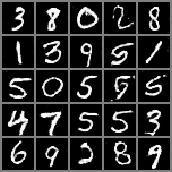

epoch: 16/300, batch: 410/600, G_loss: 3.662515163421631, D_loss: (0.02941177785396576, 0.05526413023471832)
epoch: 16/300, batch: 420/600, G_loss: 4.083605766296387, D_loss: (0.03627696633338928, 0.0290248841047287)
epoch: 16/300, batch: 430/600, G_loss: 4.210495471954346, D_loss: (0.02589777298271656, 0.02826545387506485)
epoch: 16/300, batch: 440/600, G_loss: 3.8110358715057373, D_loss: (0.03852657973766327, 0.047194525599479675)
epoch: 16/300, batch: 450/600, G_loss: 4.966908931732178, D_loss: (0.03664768114686012, 0.014255991205573082)
epoch: 16/300, batch: 460/600, G_loss: 4.638495922088623, D_loss: (0.03288085758686066, 0.01909748464822769)
epoch: 16/300, batch: 470/600, G_loss: 4.392852306365967, D_loss: (0.06585285067558289, 0.02363721840083599)
epoch: 16/300, batch: 480/600, G_loss: 3.136298894882202, D_loss: (0.008349145762622356, 0.09083397686481476)
epoch: 16/300, batch: 490/600, G_loss: 4.388092517852783, D_loss: (0.07176992297172546, 0.024896925315260887)
epoch: 16/300, 

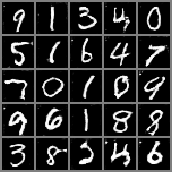

epoch: 16/300, batch: 510/600, G_loss: 2.364255428314209, D_loss: (0.24206824600696564, 0.1775045245885849)
epoch: 16/300, batch: 520/600, G_loss: 3.7346081733703613, D_loss: (0.30697450041770935, 0.043960582464933395)
epoch: 16/300, batch: 530/600, G_loss: 2.1010541915893555, D_loss: (0.03444604575634003, 0.19737118482589722)
epoch: 16/300, batch: 540/600, G_loss: 6.044511318206787, D_loss: (0.0328911691904068, 0.005200342740863562)
epoch: 16/300, batch: 550/600, G_loss: 3.8591244220733643, D_loss: (0.1538597047328949, 0.04349268600344658)
epoch: 16/300, batch: 560/600, G_loss: 0.8552844524383545, D_loss: (0.009850290603935719, 0.7985838055610657)
epoch: 16/300, batch: 570/600, G_loss: 5.060782432556152, D_loss: (0.30037230253219604, 0.013904230669140816)
epoch: 16/300, batch: 580/600, G_loss: 2.529921054840088, D_loss: (0.05527682602405548, 0.1606798619031906)
epoch: 16/300, batch: 590/600, G_loss: 3.772873640060425, D_loss: (0.06559191644191742, 0.03929971531033516)
epoch: 17/300, b

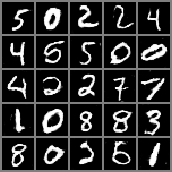

epoch: 17/300, batch: 10/600, G_loss: 4.514222145080566, D_loss: (0.6551912426948547, 0.022528450936079025)
epoch: 17/300, batch: 20/600, G_loss: 1.8455151319503784, D_loss: (0.02850271202623844, 0.26907339692115784)
epoch: 17/300, batch: 30/600, G_loss: 3.722247838973999, D_loss: (0.026822859421372414, 0.06211910769343376)
epoch: 17/300, batch: 40/600, G_loss: 1.0967634916305542, D_loss: (0.005651095416396856, 0.7932641506195068)
epoch: 17/300, batch: 50/600, G_loss: 1.1540734767913818, D_loss: (0.03232121095061302, 0.5801348686218262)
epoch: 17/300, batch: 60/600, G_loss: 3.061307668685913, D_loss: (0.1480793058872223, 0.11620683968067169)
epoch: 17/300, batch: 70/600, G_loss: 2.4396660327911377, D_loss: (0.023830922320485115, 0.15285959839820862)
epoch: 17/300, batch: 80/600, G_loss: 5.283671855926514, D_loss: (0.10721860826015472, 0.015619353391230106)
epoch: 17/300, batch: 90/600, G_loss: 3.750929832458496, D_loss: (0.043260201811790466, 0.047008827328681946)
epoch: 17/300, batch:

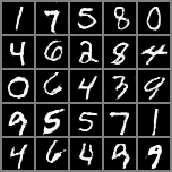

epoch: 17/300, batch: 110/600, G_loss: 1.8897079229354858, D_loss: (0.007745802402496338, 0.2348351627588272)
epoch: 17/300, batch: 120/600, G_loss: 4.851778984069824, D_loss: (0.2816971242427826, 0.015277812257409096)
epoch: 17/300, batch: 130/600, G_loss: 8.577056884765625, D_loss: (0.7206481099128723, 0.00031095443409867585)
epoch: 17/300, batch: 140/600, G_loss: 3.955688714981079, D_loss: (0.07480001449584961, 0.0571243092417717)
epoch: 17/300, batch: 150/600, G_loss: 0.8253792524337769, D_loss: (0.0011333957081660628, 0.8527794480323792)
epoch: 17/300, batch: 160/600, G_loss: 4.834854602813721, D_loss: (0.10827185958623886, 0.019618021324276924)
epoch: 17/300, batch: 170/600, G_loss: 5.698953628540039, D_loss: (0.20199249684810638, 0.00694248266518116)
epoch: 17/300, batch: 180/600, G_loss: 5.07157564163208, D_loss: (0.10409735888242722, 0.013468529097735882)
epoch: 17/300, batch: 190/600, G_loss: 4.500449180603027, D_loss: (0.06168413534760475, 0.022180670872330666)
epoch: 17/300

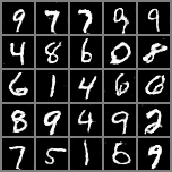

epoch: 17/300, batch: 210/600, G_loss: 4.4739603996276855, D_loss: (0.027596011757850647, 0.02152445539832115)
epoch: 17/300, batch: 220/600, G_loss: 2.9359707832336426, D_loss: (0.01165234949439764, 0.09708013385534286)
epoch: 17/300, batch: 230/600, G_loss: 1.9548242092132568, D_loss: (0.0032720204908400774, 0.2769952416419983)
epoch: 17/300, batch: 240/600, G_loss: 4.110592842102051, D_loss: (0.008302721194922924, 0.027393514290452003)
epoch: 17/300, batch: 250/600, G_loss: 1.6215994358062744, D_loss: (0.004620998166501522, 0.430700421333313)
epoch: 17/300, batch: 260/600, G_loss: 3.4075167179107666, D_loss: (0.06219721958041191, 0.06887736916542053)
epoch: 17/300, batch: 270/600, G_loss: 5.719432353973389, D_loss: (0.037218134850263596, 0.008747633546590805)
epoch: 17/300, batch: 280/600, G_loss: 5.220471382141113, D_loss: (0.025096053257584572, 0.013459223322570324)
epoch: 17/300, batch: 290/600, G_loss: 4.203336238861084, D_loss: (0.09386744350194931, 0.03330792114138603)
epoch: 

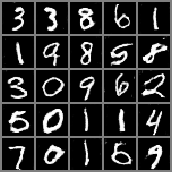

epoch: 17/300, batch: 310/600, G_loss: 3.297842025756836, D_loss: (0.0026154920924454927, 0.07491036504507065)
epoch: 17/300, batch: 320/600, G_loss: 3.9691083431243896, D_loss: (0.01407165639102459, 0.03731207177042961)
epoch: 17/300, batch: 330/600, G_loss: 5.60824728012085, D_loss: (0.02873670868575573, 0.006589776370674372)
epoch: 17/300, batch: 340/600, G_loss: 5.6344757080078125, D_loss: (0.03379002586007118, 0.006815508473664522)
epoch: 17/300, batch: 350/600, G_loss: 4.7770185470581055, D_loss: (0.013525792397558689, 0.017122823745012283)
epoch: 17/300, batch: 360/600, G_loss: 5.0639801025390625, D_loss: (0.053974699229002, 0.014874818734824657)
epoch: 17/300, batch: 370/600, G_loss: 5.874845027923584, D_loss: (0.02293851412832737, 0.005825449712574482)
epoch: 17/300, batch: 380/600, G_loss: 4.519933700561523, D_loss: (0.020450927317142487, 0.026612896472215652)
epoch: 17/300, batch: 390/600, G_loss: 5.607799053192139, D_loss: (0.051733218133449554, 0.010664278641343117)
epoch:

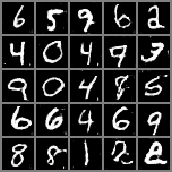

epoch: 17/300, batch: 410/600, G_loss: 5.687368869781494, D_loss: (0.06545177102088928, 0.011565926484763622)
epoch: 17/300, batch: 420/600, G_loss: 4.419787406921387, D_loss: (0.0035395268350839615, 0.02743837609887123)
epoch: 17/300, batch: 430/600, G_loss: 6.46413516998291, D_loss: (0.12240743637084961, 0.004384426400065422)
epoch: 17/300, batch: 440/600, G_loss: 2.8888943195343018, D_loss: (0.31800350546836853, 0.12070294469594955)
epoch: 17/300, batch: 450/600, G_loss: 3.376307487487793, D_loss: (0.4275543987751007, 0.08974109590053558)
epoch: 17/300, batch: 460/600, G_loss: 2.8988561630249023, D_loss: (0.10191506147384644, 0.12675273418426514)
epoch: 17/300, batch: 470/600, G_loss: 4.089193344116211, D_loss: (0.12977167963981628, 0.03461289778351784)
epoch: 17/300, batch: 480/600, G_loss: 4.051785469055176, D_loss: (0.11597137153148651, 0.0501721128821373)
epoch: 17/300, batch: 490/600, G_loss: 4.081271648406982, D_loss: (0.10370268672704697, 0.04230622202157974)
epoch: 17/300, b

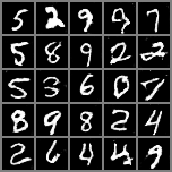

epoch: 17/300, batch: 510/600, G_loss: 3.1276395320892334, D_loss: (0.20511461794376373, 0.11067645251750946)
epoch: 17/300, batch: 520/600, G_loss: 2.0741798877716064, D_loss: (0.023500246927142143, 0.2943088412284851)
epoch: 17/300, batch: 530/600, G_loss: 4.135583400726318, D_loss: (0.018689485266804695, 0.03421340882778168)
epoch: 17/300, batch: 540/600, G_loss: 3.9444785118103027, D_loss: (0.02158319391310215, 0.03950351104140282)
epoch: 17/300, batch: 550/600, G_loss: 4.0200514793396, D_loss: (0.006794551387429237, 0.040685396641492844)
epoch: 17/300, batch: 560/600, G_loss: 2.5088248252868652, D_loss: (0.011185727082192898, 0.14659342169761658)
epoch: 17/300, batch: 570/600, G_loss: 0.721863865852356, D_loss: (0.0007145509589463472, 1.0872814655303955)
epoch: 17/300, batch: 580/600, G_loss: 5.691732883453369, D_loss: (0.38685843348503113, 0.021782826632261276)
epoch: 17/300, batch: 590/600, G_loss: 4.974243640899658, D_loss: (0.022570116445422173, 0.013452121987938881)
epoch: 18

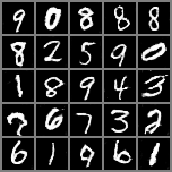

epoch: 18/300, batch: 10/600, G_loss: 4.058751106262207, D_loss: (0.02824285253882408, 0.03035520575940609)
epoch: 18/300, batch: 20/600, G_loss: 4.818210124969482, D_loss: (0.1832072138786316, 0.018359415233135223)
epoch: 18/300, batch: 30/600, G_loss: 3.7996413707733154, D_loss: (0.060576554387807846, 0.033502981066703796)
epoch: 18/300, batch: 40/600, G_loss: 7.898065567016602, D_loss: (0.5920344591140747, 0.000994834117591381)
epoch: 18/300, batch: 50/600, G_loss: 3.9273247718811035, D_loss: (0.02793053537607193, 0.03953265771269798)
epoch: 18/300, batch: 60/600, G_loss: 4.321699619293213, D_loss: (0.018096432089805603, 0.02360185608267784)
epoch: 18/300, batch: 70/600, G_loss: 3.248317003250122, D_loss: (0.013008608482778072, 0.06843005865812302)
epoch: 18/300, batch: 80/600, G_loss: 4.260843276977539, D_loss: (0.005232322029769421, 0.027044476941227913)
epoch: 18/300, batch: 90/600, G_loss: 6.6752705574035645, D_loss: (0.059930458664894104, 0.003814209019765258)
epoch: 18/300, ba

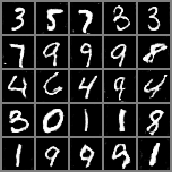

epoch: 18/300, batch: 110/600, G_loss: 6.62497615814209, D_loss: (0.014697974547743797, 0.0028515097219496965)
epoch: 18/300, batch: 120/600, G_loss: 4.940122604370117, D_loss: (0.007995202206075191, 0.01210121251642704)
epoch: 18/300, batch: 130/600, G_loss: 3.538595199584961, D_loss: (0.014601643197238445, 0.05203108489513397)
epoch: 18/300, batch: 140/600, G_loss: 5.721778392791748, D_loss: (0.01687939092516899, 0.006278282962739468)
epoch: 18/300, batch: 150/600, G_loss: 5.118513107299805, D_loss: (0.01053308043628931, 0.013005293905735016)
epoch: 18/300, batch: 160/600, G_loss: 5.362330913543701, D_loss: (0.04090820625424385, 0.0085227582603693)
epoch: 18/300, batch: 170/600, G_loss: 5.6758880615234375, D_loss: (0.025415385141968727, 0.006539823487401009)
epoch: 18/300, batch: 180/600, G_loss: 5.544119358062744, D_loss: (0.011905601248145103, 0.00778141850605607)
epoch: 18/300, batch: 190/600, G_loss: 5.214913368225098, D_loss: (0.013953665271401405, 0.009986483491957188)
epoch: 1

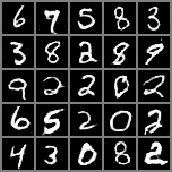

epoch: 18/300, batch: 210/600, G_loss: 2.9363186359405518, D_loss: (1.362833857536316, 0.1402469277381897)
epoch: 18/300, batch: 220/600, G_loss: 1.2280689477920532, D_loss: (0.040016088634729385, 0.5715371966362)
epoch: 18/300, batch: 230/600, G_loss: 1.1767363548278809, D_loss: (0.03864917531609535, 0.5742042660713196)
epoch: 18/300, batch: 240/600, G_loss: 2.531141757965088, D_loss: (0.13847489655017853, 0.16575366258621216)
epoch: 18/300, batch: 250/600, G_loss: 2.3472371101379395, D_loss: (0.17091365158557892, 0.20865684747695923)
epoch: 18/300, batch: 260/600, G_loss: 1.9680829048156738, D_loss: (0.04967062920331955, 0.3126430809497833)
epoch: 18/300, batch: 270/600, G_loss: 1.383571982383728, D_loss: (0.05550593510270119, 0.5304166078567505)
epoch: 18/300, batch: 280/600, G_loss: 6.331925868988037, D_loss: (0.44662556052207947, 0.0036645412910729647)
epoch: 18/300, batch: 290/600, G_loss: 3.8068528175354004, D_loss: (0.2969704270362854, 0.07128379493951797)
epoch: 18/300, batch:

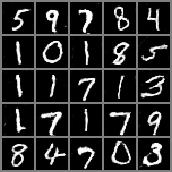

epoch: 18/300, batch: 310/600, G_loss: 5.385498046875, D_loss: (0.7901690006256104, 0.016044067218899727)
epoch: 18/300, batch: 320/600, G_loss: 2.3756964206695557, D_loss: (0.024935677647590637, 0.18605570495128632)
epoch: 18/300, batch: 330/600, G_loss: 5.890866756439209, D_loss: (0.20103086531162262, 0.005534876137971878)
epoch: 18/300, batch: 340/600, G_loss: 2.962923288345337, D_loss: (0.033120159059762955, 0.09368747472763062)
epoch: 18/300, batch: 350/600, G_loss: 4.109713554382324, D_loss: (0.24411898851394653, 0.03503212332725525)
epoch: 18/300, batch: 360/600, G_loss: 3.5712225437164307, D_loss: (0.012388663366436958, 0.05178450420498848)
epoch: 18/300, batch: 370/600, G_loss: 3.1677358150482178, D_loss: (0.018276406452059746, 0.08319596946239471)
epoch: 18/300, batch: 380/600, G_loss: 2.2052698135375977, D_loss: (0.061913613229990005, 0.23979148268699646)
epoch: 18/300, batch: 390/600, G_loss: 0.6741807460784912, D_loss: (0.26019802689552307, 1.060186743736267)
epoch: 18/300

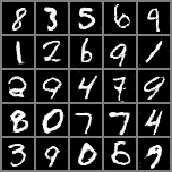

epoch: 18/300, batch: 410/600, G_loss: 2.6085922718048096, D_loss: (0.030669545754790306, 0.1382172554731369)
epoch: 18/300, batch: 420/600, G_loss: 0.3191356062889099, D_loss: (0.0069645061157643795, 1.8141790628433228)
epoch: 18/300, batch: 430/600, G_loss: 1.3067973852157593, D_loss: (0.01063377782702446, 0.5560081601142883)
epoch: 18/300, batch: 440/600, G_loss: 1.9034364223480225, D_loss: (0.03135106712579727, 0.2561657428741455)
epoch: 18/300, batch: 450/600, G_loss: 3.086501121520996, D_loss: (0.014912216924130917, 0.09370438754558563)
epoch: 18/300, batch: 460/600, G_loss: 3.0464425086975098, D_loss: (0.02716614305973053, 0.08286650478839874)
epoch: 18/300, batch: 470/600, G_loss: 5.836802959442139, D_loss: (0.05722789838910103, 0.005571501329541206)
epoch: 18/300, batch: 480/600, G_loss: 4.4340291023254395, D_loss: (0.18630994856357574, 0.02064795047044754)
epoch: 18/300, batch: 490/600, G_loss: 0.711254894733429, D_loss: (0.01040835864841938, 1.0633047819137573)
epoch: 18/300

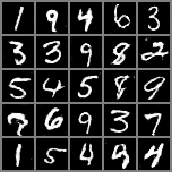

epoch: 18/300, batch: 510/600, G_loss: 3.9556174278259277, D_loss: (0.15451699495315552, 0.03438408300280571)
epoch: 18/300, batch: 520/600, G_loss: 8.68973159790039, D_loss: (0.9373117685317993, 0.000751662184484303)
epoch: 18/300, batch: 530/600, G_loss: 1.805896282196045, D_loss: (0.02772572822868824, 0.3043579161167145)
epoch: 18/300, batch: 540/600, G_loss: 1.5170131921768188, D_loss: (0.09673507511615753, 0.4798136055469513)
epoch: 18/300, batch: 550/600, G_loss: 4.4053120613098145, D_loss: (1.347330927848816, 0.021927885711193085)
epoch: 18/300, batch: 560/600, G_loss: 1.4949097633361816, D_loss: (0.024191906675696373, 0.4040986895561218)
epoch: 18/300, batch: 570/600, G_loss: 5.435116767883301, D_loss: (0.1548709124326706, 0.011740053072571754)
epoch: 18/300, batch: 580/600, G_loss: 4.233630657196045, D_loss: (0.20544902980327606, 0.02362082526087761)
epoch: 18/300, batch: 590/600, G_loss: 3.1991071701049805, D_loss: (0.05325678735971451, 0.07252077758312225)
epoch: 19/300, bat

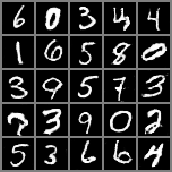

epoch: 19/300, batch: 10/600, G_loss: 4.539340972900391, D_loss: (0.08108945935964584, 0.02575612999498844)
epoch: 19/300, batch: 20/600, G_loss: 2.9600822925567627, D_loss: (0.1886720508337021, 0.10751162469387054)
epoch: 19/300, batch: 30/600, G_loss: 4.699261665344238, D_loss: (0.12188475579023361, 0.019948773086071014)
epoch: 19/300, batch: 40/600, G_loss: 4.583449840545654, D_loss: (0.16656360030174255, 0.023858213797211647)
epoch: 19/300, batch: 50/600, G_loss: 2.9606773853302, D_loss: (0.2111673504114151, 0.1254671812057495)
epoch: 19/300, batch: 60/600, G_loss: 2.7453086376190186, D_loss: (0.024537954479455948, 0.12190494686365128)
epoch: 19/300, batch: 70/600, G_loss: 2.1798434257507324, D_loss: (0.01846124790608883, 0.21007157862186432)
epoch: 19/300, batch: 80/600, G_loss: 3.7108190059661865, D_loss: (0.19316749274730682, 0.042895637452602386)
epoch: 19/300, batch: 90/600, G_loss: 1.8185875415802002, D_loss: (0.10848146677017212, 0.3262149393558502)
epoch: 19/300, batch: 100

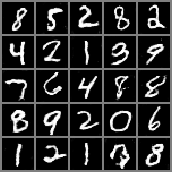

epoch: 19/300, batch: 110/600, G_loss: 4.148927688598633, D_loss: (0.2610257565975189, 0.04156938195228577)
epoch: 19/300, batch: 120/600, G_loss: 7.003469467163086, D_loss: (1.2464818954467773, 0.0019350373186171055)
epoch: 19/300, batch: 130/600, G_loss: 2.2914741039276123, D_loss: (0.024589862674474716, 0.17025986313819885)
epoch: 19/300, batch: 140/600, G_loss: 3.862565040588379, D_loss: (0.15589307248592377, 0.03484983369708061)
epoch: 19/300, batch: 150/600, G_loss: 5.570996284484863, D_loss: (0.0715070366859436, 0.007938824594020844)
epoch: 19/300, batch: 160/600, G_loss: 3.438114643096924, D_loss: (0.031144848093390465, 0.068148672580719)
epoch: 19/300, batch: 170/600, G_loss: 4.784763336181641, D_loss: (0.18030910193920135, 0.014096817933022976)
epoch: 19/300, batch: 180/600, G_loss: 5.346708297729492, D_loss: (0.020206427201628685, 0.009020860306918621)
epoch: 19/300, batch: 190/600, G_loss: 3.8842012882232666, D_loss: (0.010816744528710842, 0.033661048859357834)
epoch: 19/30

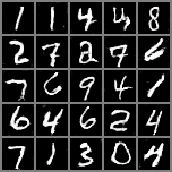

epoch: 19/300, batch: 210/600, G_loss: 4.219425678253174, D_loss: (0.030692992731928825, 0.029448550194501877)
epoch: 19/300, batch: 220/600, G_loss: 6.439547061920166, D_loss: (0.07716209441423416, 0.002758913906291127)
epoch: 19/300, batch: 230/600, G_loss: 2.6653006076812744, D_loss: (0.002350752241909504, 0.12833741307258606)
epoch: 19/300, batch: 240/600, G_loss: 4.109495162963867, D_loss: (0.007271692622452974, 0.04263415187597275)
epoch: 19/300, batch: 250/600, G_loss: 4.684556484222412, D_loss: (0.032957110553979874, 0.01834777742624283)
epoch: 19/300, batch: 260/600, G_loss: 4.3472580909729, D_loss: (0.011257197707891464, 0.022834300994873047)
epoch: 19/300, batch: 270/600, G_loss: 4.17758321762085, D_loss: (0.16605165600776672, 0.036626216024160385)
epoch: 19/300, batch: 280/600, G_loss: 4.087770462036133, D_loss: (0.06894820928573608, 0.03872062638401985)
epoch: 19/300, batch: 290/600, G_loss: 5.172887802124023, D_loss: (0.08130867779254913, 0.009413084015250206)
epoch: 19/3

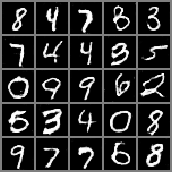

epoch: 19/300, batch: 310/600, G_loss: 3.899184465408325, D_loss: (0.016946446150541306, 0.03614551201462746)
epoch: 19/300, batch: 320/600, G_loss: 1.4600619077682495, D_loss: (0.1352812796831131, 0.4895420968532562)
epoch: 19/300, batch: 330/600, G_loss: 2.6740736961364746, D_loss: (0.028130725026130676, 0.10872848331928253)
epoch: 19/300, batch: 340/600, G_loss: 3.314279794692993, D_loss: (0.043981924653053284, 0.09003172814846039)
epoch: 19/300, batch: 350/600, G_loss: 1.2243212461471558, D_loss: (0.006138557568192482, 0.6444821953773499)
epoch: 19/300, batch: 360/600, G_loss: 2.9235363006591797, D_loss: (0.009243588894605637, 0.11118670552968979)
epoch: 19/300, batch: 370/600, G_loss: 3.635784387588501, D_loss: (0.024311266839504242, 0.05794025957584381)
epoch: 19/300, batch: 380/600, G_loss: 5.096843242645264, D_loss: (0.030604589730501175, 0.012110352516174316)
epoch: 19/300, batch: 390/600, G_loss: 3.5242059230804443, D_loss: (0.009913070127367973, 0.058510154485702515)
epoch: 

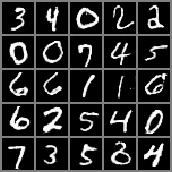

epoch: 19/300, batch: 410/600, G_loss: 5.743170738220215, D_loss: (0.07186173647642136, 0.007609261199831963)
epoch: 19/300, batch: 420/600, G_loss: 2.1893575191497803, D_loss: (0.005971431732177734, 0.19679369032382965)
epoch: 19/300, batch: 430/600, G_loss: 2.7633678913116455, D_loss: (0.008541674353182316, 0.11143047362565994)
epoch: 19/300, batch: 440/600, G_loss: 5.171377182006836, D_loss: (0.0837077721953392, 0.010257666930556297)
epoch: 19/300, batch: 450/600, G_loss: 3.89396595954895, D_loss: (0.020387131720781326, 0.035861674696207047)
epoch: 19/300, batch: 460/600, G_loss: 4.113304138183594, D_loss: (0.004654576536267996, 0.027500996366143227)
epoch: 19/300, batch: 470/600, G_loss: 5.801957607269287, D_loss: (0.05813208222389221, 0.005624005571007729)
epoch: 19/300, batch: 480/600, G_loss: 4.738800525665283, D_loss: (0.2541564702987671, 0.018167441710829735)
epoch: 19/300, batch: 490/600, G_loss: 0.6430100798606873, D_loss: (0.027480578050017357, 1.0456757545471191)
epoch: 19

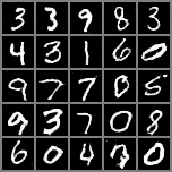

epoch: 19/300, batch: 510/600, G_loss: 5.14476203918457, D_loss: (0.12262213975191116, 0.0096368920058012)
epoch: 19/300, batch: 520/600, G_loss: 4.147894859313965, D_loss: (0.03227951005101204, 0.028272032737731934)
epoch: 19/300, batch: 530/600, G_loss: 5.212589740753174, D_loss: (0.09581158310174942, 0.010879794135689735)
epoch: 19/300, batch: 540/600, G_loss: 2.464423179626465, D_loss: (0.0020223448518663645, 0.13855864107608795)
epoch: 19/300, batch: 550/600, G_loss: 6.225052356719971, D_loss: (0.07297652959823608, 0.003908846527338028)
epoch: 19/300, batch: 560/600, G_loss: 4.874921798706055, D_loss: (0.032919369637966156, 0.015054064802825451)
epoch: 19/300, batch: 570/600, G_loss: 6.6122589111328125, D_loss: (1.1141847372055054, 0.012680616229772568)
epoch: 19/300, batch: 580/600, G_loss: 6.5670647621154785, D_loss: (0.7157164812088013, 0.003739319508895278)
epoch: 19/300, batch: 590/600, G_loss: 2.6134040355682373, D_loss: (0.008146573789417744, 0.13283050060272217)
epoch: 20/

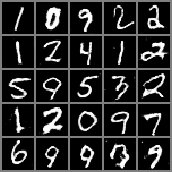

epoch: 20/300, batch: 10/600, G_loss: 3.9340009689331055, D_loss: (0.030902065336704254, 0.04308266565203667)
epoch: 20/300, batch: 20/600, G_loss: 4.060838222503662, D_loss: (0.044215667992830276, 0.032113656401634216)
epoch: 20/300, batch: 30/600, G_loss: 5.080121040344238, D_loss: (0.14852215349674225, 0.011972798965871334)
epoch: 20/300, batch: 40/600, G_loss: 6.084314346313477, D_loss: (0.03256726637482643, 0.004196206107735634)
epoch: 20/300, batch: 50/600, G_loss: 5.049030303955078, D_loss: (0.011466387659311295, 0.013428467325866222)
epoch: 20/300, batch: 60/600, G_loss: 6.676922798156738, D_loss: (0.040360406041145325, 0.0025413879193365574)
epoch: 20/300, batch: 70/600, G_loss: 3.499551773071289, D_loss: (0.0021762182004749775, 0.048270221799612045)
epoch: 20/300, batch: 80/600, G_loss: 2.8394501209259033, D_loss: (0.02309027686715126, 0.15339955687522888)
epoch: 20/300, batch: 90/600, G_loss: 4.866632461547852, D_loss: (0.05633579567074776, 0.015993792563676834)
epoch: 20/30

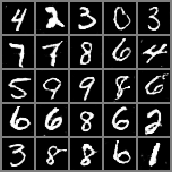

epoch: 20/300, batch: 110/600, G_loss: 4.297600269317627, D_loss: (0.9688319563865662, 0.027283407747745514)
epoch: 20/300, batch: 120/600, G_loss: 2.2641611099243164, D_loss: (0.3433987498283386, 0.20490692555904388)
epoch: 20/300, batch: 130/600, G_loss: 0.6878474354743958, D_loss: (0.010642290115356445, 1.2172528505325317)
epoch: 20/300, batch: 140/600, G_loss: 2.514388084411621, D_loss: (0.21090257167816162, 0.13818275928497314)
epoch: 20/300, batch: 150/600, G_loss: 1.5565720796585083, D_loss: (0.08814571052789688, 0.3842683434486389)
epoch: 20/300, batch: 160/600, G_loss: 2.690358877182007, D_loss: (0.039688292890787125, 0.16156905889511108)
epoch: 20/300, batch: 170/600, G_loss: 4.574051380157471, D_loss: (0.14513006806373596, 0.023174116387963295)
epoch: 20/300, batch: 180/600, G_loss: 4.3729753494262695, D_loss: (0.06178393214941025, 0.025759804993867874)
epoch: 20/300, batch: 190/600, G_loss: 3.4270823001861572, D_loss: (0.009730073623359203, 0.06931690126657486)
epoch: 20/30

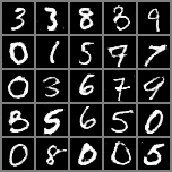

epoch: 20/300, batch: 210/600, G_loss: 1.5191267728805542, D_loss: (0.034902285784482956, 0.43747276067733765)
epoch: 20/300, batch: 220/600, G_loss: 2.7723593711853027, D_loss: (0.0979762077331543, 0.18887832760810852)
epoch: 20/300, batch: 230/600, G_loss: 3.9058992862701416, D_loss: (0.29208847880363464, 0.03571151942014694)
epoch: 20/300, batch: 240/600, G_loss: 3.952270269393921, D_loss: (0.12007392942905426, 0.03619695454835892)
epoch: 20/300, batch: 250/600, G_loss: 3.2644100189208984, D_loss: (0.018761709332466125, 0.06714186072349548)
epoch: 20/300, batch: 260/600, G_loss: 4.103348255157471, D_loss: (0.06297726184129715, 0.038305919617414474)
epoch: 20/300, batch: 270/600, G_loss: 2.8248860836029053, D_loss: (0.00926671177148819, 0.1219981387257576)
epoch: 20/300, batch: 280/600, G_loss: 5.353204250335693, D_loss: (0.07538731396198273, 0.010439608246088028)
epoch: 20/300, batch: 290/600, G_loss: 3.3246355056762695, D_loss: (0.005245445761829615, 0.06331850588321686)
epoch: 20/

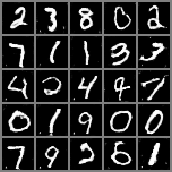

epoch: 20/300, batch: 310/600, G_loss: 4.068366527557373, D_loss: (0.024649538099765778, 0.03206886723637581)
epoch: 20/300, batch: 320/600, G_loss: 3.4877657890319824, D_loss: (0.017228513956069946, 0.05725659057497978)
epoch: 20/300, batch: 330/600, G_loss: 5.194583892822266, D_loss: (0.017520181834697723, 0.011528028175234795)
epoch: 20/300, batch: 340/600, G_loss: 5.238727569580078, D_loss: (0.025599950924515724, 0.016864385455846786)
epoch: 20/300, batch: 350/600, G_loss: 4.0080156326293945, D_loss: (0.01629055291414261, 0.035163093358278275)
epoch: 20/300, batch: 360/600, G_loss: 4.151982307434082, D_loss: (0.06038062274456024, 0.03355924040079117)
epoch: 20/300, batch: 370/600, G_loss: 5.287309646606445, D_loss: (0.02480267360806465, 0.010925212875008583)
epoch: 20/300, batch: 380/600, G_loss: 3.447237968444824, D_loss: (0.020822081714868546, 0.063725546002388)
epoch: 20/300, batch: 390/600, G_loss: 3.877337694168091, D_loss: (0.009282509796321392, 0.038904525339603424)
epoch: 2

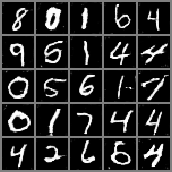

epoch: 20/300, batch: 410/600, G_loss: 3.3014883995056152, D_loss: (0.005614397116005421, 0.07188375294208527)
epoch: 20/300, batch: 420/600, G_loss: 3.4911012649536133, D_loss: (0.023354744538664818, 0.06462398171424866)
epoch: 20/300, batch: 430/600, G_loss: 4.279853820800781, D_loss: (0.03264426812529564, 0.026598963886499405)
epoch: 20/300, batch: 440/600, G_loss: 5.643184661865234, D_loss: (0.03529379516839981, 0.007560637779533863)
epoch: 20/300, batch: 450/600, G_loss: 4.731942653656006, D_loss: (0.013870367780327797, 0.014611695893108845)
epoch: 20/300, batch: 460/600, G_loss: 4.070244312286377, D_loss: (0.058119997382164, 0.04216305911540985)
epoch: 20/300, batch: 470/600, G_loss: 4.874189376831055, D_loss: (0.03236444666981697, 0.013360141776502132)
epoch: 20/300, batch: 480/600, G_loss: 5.272064208984375, D_loss: (0.017613226547837257, 0.0105205699801445)
epoch: 20/300, batch: 490/600, G_loss: 5.9459147453308105, D_loss: (0.01870182901620865, 0.004225857090204954)
epoch: 20/

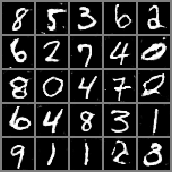

epoch: 20/300, batch: 510/600, G_loss: 4.78092098236084, D_loss: (0.0398268848657608, 0.014708403497934341)
epoch: 20/300, batch: 520/600, G_loss: 5.261080265045166, D_loss: (0.008206663653254509, 0.009918744675815105)
epoch: 20/300, batch: 530/600, G_loss: 5.1548943519592285, D_loss: (0.03015284053981304, 0.012844848446547985)
epoch: 20/300, batch: 540/600, G_loss: 3.805846929550171, D_loss: (0.011013342067599297, 0.05318249762058258)
epoch: 20/300, batch: 550/600, G_loss: 3.9418439865112305, D_loss: (0.045468807220458984, 0.06600559502840042)
epoch: 20/300, batch: 560/600, G_loss: 1.9290324449539185, D_loss: (0.008066357113420963, 0.3528251647949219)
epoch: 20/300, batch: 570/600, G_loss: 2.0564427375793457, D_loss: (0.01079501397907734, 0.28151965141296387)
epoch: 20/300, batch: 580/600, G_loss: 5.251058578491211, D_loss: (0.04504924640059471, 0.011917706578969955)
epoch: 20/300, batch: 590/600, G_loss: 5.770605564117432, D_loss: (0.025950055569410324, 0.0074485065415501595)
epoch: 

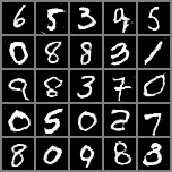

epoch: 21/300, batch: 10/600, G_loss: 4.341280937194824, D_loss: (0.0033093541860580444, 0.029334289953112602)
epoch: 21/300, batch: 20/600, G_loss: 1.0384771823883057, D_loss: (0.00023022398818284273, 0.7420507669448853)
epoch: 21/300, batch: 30/600, G_loss: 1.49467134475708, D_loss: (0.00393792474642396, 0.5325007438659668)
epoch: 21/300, batch: 40/600, G_loss: 2.3042354583740234, D_loss: (0.013634034432470798, 0.2297532707452774)


KeyboardInterrupt: ignored

In [10]:
for epoch in range(num_epochs):
  
    # Train epoch
    for n_batch, (real_samples, real_nums) in enumerate(data_loader):
        
        # Prepare batch data
        real_samples = Variable(real_samples).cuda()
        real_nums = Variable(real_nums).cuda()
          
        # Update model weights
        loss_g, loss_d = model.step_optimization(real_samples, real_nums)
        
        # Show current loss
        if (n_batch) % 10 == 0:
            print(f"epoch: {epoch}/{num_epochs}, batch: {n_batch}/{len(data_loader)}, G_loss: {loss_g}, D_loss: {loss_d}")    
          
        # Show fake samples
        if (n_batch) % 100 == 0:
            val_fake_samples = model.generate_samples(num_val_samples, z=z_val)[0].data.cpu()
            display_batch_images(val_fake_samples)

### 4.5 Results

[[8 6 7 4]
 [3 8 7 0]
 [3 8 9 2]
 [2 4 0 1]] 



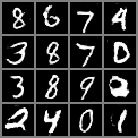

In [18]:
num_val_samples = 16

nums_val = torch.LongTensor(num_val_samples).random_(0, 10).cuda()
print(nums_val.view(4,4).cpu().data.numpy(),'\n')

z_val = norm_noise(num_val_samples).cuda()
val_fake_samples = model._generator(z_val, nums_val)
display_batch_images(val_fake_samples.detach())